In [115]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy import integrate, optimize
from iminuit import Minuit
from tqdm import tqdm
from itertools import product
from multiprocessing import Pool

## Parameters definition
1. bins related parameters (reconstucted top mass)
* bins_width (int): The width of each bin (for both reconstructed top mass and W mass)
* top_bins_min (int): The minimum reco top mass (GeV)
* top_bins_max (int): The maximum reco top mass (GeV)
* top_bins (float array): The boundary of each bin i.g. 120, 121, 122
* top_bins_mid(float array): The central value of bins, it will be generated automatically
* top_bins_dense(float array): Dense version of top bins, which is used to draw fitted line

2. bins related parameters (reconstucted W mass)
* W_bins_min (int): The minimum W mass (GeV)
* W_bins_max (int): The maximum W mass (GeV)
* W_bins (float array): The boundary of each bin
* W_bins_mid(float array): The central value of bins, it will be generated automatically
* W_bins_dense(float array): Dense version of W bins, which is used to draw fitted line

3. True top mass related parameters
* mass(int array): True top mass
* top_mass_dense(float array): Densly true top mass that is used to show the fit result

4. JSF related parameters
* JSF_arr(float array): JSF arr that generates
* JSF_dense(float array): Densly JSF that is used to show the fit result

5. Other parameters
* loglikeli_cut: KLFitter loglikelihood cut, range between -80 to -50
* marginal_prob_cut: SPAnet marginal probility cut, range between 0 to 1
* sudo_event: Toy number of each pseudo experiment

6. Settings
* states: 0 for unmatched, 1 for incorrect, and 2 for correct
* state_labels: The label of three states
* colors: Control the color of drawings
* langau_fit_labels: The label of parameters for reconstructed top mass pdf fit
* twogau_fit_labels: The label of parameters for reconstructed W mass pdf fit

In [2]:
# Fixed the bins, colors, mass arr, and labels for all plots.
# 1. bins related parameters (reconstucted top mass)
bins_width = 1
top_bins_min, top_bins_max = 120, 230
top_bins = np.arange(top_bins_min, top_bins_max+1, bins_width)
top_bins_mid = top_bins[:-1]+bins_width/2
top_bins_dense = np.linspace(top_bins_min, top_bins_max, 1000)

# 2. bins related parameters (reconstucted W mass)
W_bins_min, W_bins_max = 40, 120
W_bins = np.arange(W_bins_min, W_bins_max+1, bins_width)
W_bins_mid = W_bins[:-1]+bins_width/2
W_bins_dense = np.linspace(W_bins_min, W_bins_max, 1000)

# 3. True top mass related parameters
mass = [170, 171, 172, 173, 174, 175, 176]
top_mass_dense = np.linspace(170, 176, 1000)

# 4. JSF related parameters
JSF_arr = [0.97, 0.98, 0.99, 1.0, 1.01, 1.02, 1.03]
JSF_dense = np.linspace(0.97, 1.03, 1000)

# 5. Other paramters
loglikeli_cut = -78
marginal_prob_cut = 0.23
sudo_event = 10000

# 6. Settings
states = [0, 1, 2]
state_labels = ['Unmatched', 'Incorrect', 'Correct']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
langau_fit_labels = ['Peak of Landau', 'Width of Landau', 'Mean of Gaussian', 'Variance of Gaussian', 'Fraction of Gaussian']
twogau_fit_labels = ['Mean of first Gaussian', 'Variance of first Gaussian', 'Mean of second Gaussian', 'Variance of second Gaussian', 'Fraction of second Gaussian']


## Function get_reco_top_mass
Input:
1. h5py_file (h5py_file): The h5py file that contains the KLFitter and SPAnet result
2. target ("klf", "spanet", or "true"): The target to analysis
3. JSF (float): Jet scaling factor, it scales the energy of bjet and the two light jets

Output:
1. reconstructed top mass (float array)
2. reconstructed W mass(float array)
3. state (int array): State of the top mass, 0 for unmatched, 1 for incorrect, and 2 for correct
4. cuts (bool array): reco top mass cut (bins_min < reco top mass < bins_max)
5. likelihood_cut (bool array): 

In [3]:
def get_reco_mass(h5py_file, target, JSF): # Target is spanet or klfitter
    dic = {}

    #Load pt, eta, phi, and mass from file. Where q1, q2 and b are the index.
    q1 = np.array([[i] for i in h5py_file[target + '/right_target/q1'][:]])
    dic['q1_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q1, axis=1).flatten()
    dic['q1_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q1, axis=1).flatten()
    dic['q1_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q1, axis=1).flatten()
    dic['q1_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q1, axis=1).flatten()

    q2 = np.array([[i] for i in h5py_file[target + '/right_target/q2'][:]])
    dic['q2_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], q2, axis=1).flatten()
    dic['q2_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], q2, axis=1).flatten()
    dic['q2_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], q2, axis=1).flatten()
    dic['q2_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], q2, axis=1).flatten()

    b = np.array([[i] for i in h5py_file[target + '/right_target/b'][:]])
    dic['b_pt'] = np.take_along_axis(h5py_file['jet_features/pt'][:], b, axis=1).flatten()
    dic['b_eta'] = np.take_along_axis(h5py_file['jet_features/eta'][:], b, axis=1).flatten()
    dic['b_phi'] = np.take_along_axis(h5py_file['jet_features/phi'][:], b, axis=1).flatten()
    dic['b_mass'] = np.take_along_axis(h5py_file['jet_features/mass'][:], b, axis=1).flatten()
    
    # px = pt*cos(phi)*JSF
    # py = pt*sin(phi)*JSF
    # pz = pt*sinh(eta)*JSF
    # E  = sqrt(m**2 + px**2 + py**2 + pz**2)
    dic['px1'] = dic['q1_pt']*np.cos(dic['q1_phi'])*JSF
    dic['py1'] = dic['q1_pt']*np.sin(dic['q1_phi'])*JSF
    dic['pz1'] = dic['q1_pt']*np.sinh(dic['q1_eta'])*JSF
    dic['E1'] = np.sqrt(dic['q1_mass']**2+dic['px1']**2+dic['py1']**2+dic['pz1']**2)

    dic['px2'] = dic['q2_pt']*np.cos(dic['q2_phi'])*JSF
    dic['py2'] = dic['q2_pt']*np.sin(dic['q2_phi'])*JSF
    dic['pz2'] = dic['q2_pt']*np.sinh(dic['q2_eta'])*JSF
    dic['E2'] = np.sqrt(dic['q2_mass']**2+dic['px2']**2+dic['py2']**2+dic['pz2']**2)

    dic['bx'] = dic['b_pt']*np.cos(dic['b_phi'])*JSF
    dic['by'] = dic['b_pt']*np.sin(dic['b_phi'])*JSF
    dic['bz'] = dic['b_pt']*np.sinh(dic['b_eta'])*JSF
    dic['bE'] = np.sqrt(dic['b_mass']**2+dic['bx']**2+dic['by']**2+dic['bz']**2)
    
    # M = sqrt((m1+m2)**2 + (px1+px2)**2 + (py1+py2)**2 + (pz1+pz2)**2)
    dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2
                    - (dic['px1']+dic['px2'])**2
                    - (dic['py1']+dic['py2'])**2
                    - (dic['pz1']+dic['pz2'])**2)
    
    dic['reconstructed_top_mass'] = np.sqrt((dic['E1']+dic['E2']+dic['bE'])**2
                    - (dic['px1']+dic['px2']+dic['bx'])**2
                    - (dic['py1']+dic['py2']+dic['by'])**2
                    - (dic['pz1']+dic['pz2']+dic['bz'])**2)

    """
    cuts
    top_bins_min < reco_m_top < top_bins_max
    W_bins_min < reco_W_top < W_bins_max
    """
    reco_cuts = np.logical_and.reduce((dic['reconstructed_top_mass'] > top_bins_min, dic['reconstructed_top_mass'] < top_bins_max, 
                                       dic['reconstructed_W_mass'] > W_bins_min, dic['reconstructed_W_mass'] < W_bins_max))

    # Check the state of the event.
    state = [1]*len(h5py_file['target/right_target/q1'][:])

    # Two permutations for q1 and q2.
    permu1 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q1'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q2'][:])
    permu2 = np.logical_and(h5py_file['target/right_target/q1'][:] == h5py_file[target + '/right_target/q2'][:], 
                        h5py_file['target/right_target/q2'][:] == h5py_file[target + '/right_target/q1'][:])
    correct = np.logical_and(np.logical_or(permu1, permu2), h5py_file['target/right_target/b'][:] == h5py_file[target + '/right_target/b'][:])
    state = np.where(correct, 2, state)

    # Check for unmatch
    unmatch = np.logical_or.reduce((h5py_file['target/right_target/q1'][:] == -1,
                        h5py_file['target/right_target/q2'][:] == -1,
                        h5py_file['target/right_target/b'][:] == -1))
    state = np.where(unmatch, 0, state)
    if target == 'klfitter': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['klfitter/score/loglikelihood'][:]>loglikeli_cut
    elif target == 'spanet': return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts, h5py_file['spanet/right_target/marginal_probability'][:]>marginal_prob_cut
    else: return dic['reconstructed_top_mass'], dic['reconstructed_W_mass'], state, reco_cuts


## Data input
Using the function get_reco_top_mass to retrieve the data from the h5py files

In [ ]:
# The reco_top_mss from ttbar_testing_mass_variation
# 0 for unmatched, 1 for incorrect, 2 for correct
reco_klf_dic, W_klf_dic, state_klf_dic, cut_klf_dic, likeli_klf_dic = {}, {}, {}, {}, {}
reco_spanet_dic, W_spanet_dic, state_spanet_dic, cut_spanet_dic, likeli_spanet_dic = {}, {}, {}, {}, {}
reco_perfect_dic, W_perfect_dic, state_perfect_dic, cut_perfect_dic = {}, {}, {}, {}

for m in mass:
    h5py_file = h5py.File(f'ttbar_testing_mass_variation/ttbar_testing_{m}_gev_with_spanet_pdnn_KLFitter.h5', "r")
    for JSF in JSF_arr:
        reco_klf_dic[(m, JSF)], W_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)], cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]  = get_reco_mass(h5py_file, 'klfitter', JSF)
        reco_spanet_dic[(m, JSF)], W_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)], cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)] = get_reco_mass(h5py_file, 'spanet', JSF)
        reco_perfect_dic[(m,JSF)], W_perfect_dic[(m, JSF)], state_perfect_dic[(m,JSF)], cut_perfect_dic[(m,JSF)] = get_reco_mass(h5py_file, 'target', JSF)


/tmp/ipykernel_14704/3069958540.py:43: RuntimeWarning: invalid value encountered in sqrt
  dic['reconstructed_W_mass'] = np.sqrt((dic['E1']+dic['E2'])**2


In [ ]:
# Sum of a Landau distribution and a gaussian distribution. Landau uses moyal as approximation.
def langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    lan_y = (x-lan_loc)/lan_scale
    gau_y = (x-gau_loc)/gau_scale
    return (1-f)*np.exp(-(lan_y+np.exp(-lan_y))/2)/np.sqrt(2*np.pi)/lan_scale + f*np.exp(-gau_y**2/2)/np.sqrt(2*np.pi)/gau_scale

# Normalized between top_bins_min and top_bins_max
def langau_norm(x, lan_loc, lan_scale, gau_loc, gau_scale, f):
    return langau(x, lan_loc, lan_scale, gau_loc, gau_scale, f)/integrate.quad(langau, top_bins_min, top_bins_max, args=(lan_loc, lan_scale, gau_loc, gau_scale, f))[0]

# Two gaussian distributions.
def two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    gau_y1 = (x-gau_loc1)/gau_scale1
    gau_y2 = (x-gau_loc2)/gau_scale2
    return (1-f)*np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1 + f*np.exp(-gau_y2**2/2)/np.sqrt(2*np.pi)/gau_scale2

def two_gau_norm(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f):
    return two_gau(x, gau_loc1, gau_scale1, gau_loc2, gau_scale2, f)/integrate.quad(two_gau, W_bins_min, W_bins_max, args=(gau_loc1, gau_scale1, gau_loc2, gau_scale2, f))[0]

# Gaussian distributions.
def gau(x, gau_loc1, gau_scale1):
    gau_y1 = (x-gau_loc1)/gau_scale1
    return np.exp(-gau_y1**2/2)/np.sqrt(2*np.pi)/gau_scale1

def gau_norm(x, gau_loc1, gau_scale1):
    return gau(x, gau_loc1, gau_scale1)/integrate.quad(gau, x[0]-bins_width/2, x[-1]+bins_width/2, args=(gau_loc1, gau_scale1))[0]

# Linear
def linear(x, a, b):
    return a*x+b

# Function to construct PDF parameters
def linear_linear(x, a, b, c, d):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1))

def linear_parabola(x, a, b, c, d, e):
    return (a + b*(x[0]-173)) * (c + d*(x[1]-1) + e*(x[1]-1)**2)

def fcn_top(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(langau_norm(top_bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event

def fcn_W(lan_loc, lan_scale, gau_loc, gau_scale, f):
    return -2*np.sum(hist*np.log(two_gau_norm(W_bins_mid, lan_loc, lan_scale, gau_loc, gau_scale, f)))*tot_event

#observed is the observation, pdf is the normalized height of the bins from pdf.
def chi2_pdf_top(observed, pdf):
    n1, _ = np.histogram(observed, bins=top_bins)
    n2 = pdf*bins_width*len(observed)
    return np.sum((n1-n2)**2/n2)

def chi2_pdf_W(observed, pdf):
    n1, _ = np.histogram(observed, bins=W_bins)
    n2 = pdf*bins_width*len(observed)
    return np.sum((n1-n2)**2/n2)

## Fraction of each state (class)

In [ ]:
ratio_klf_dic = {i:{} for i in states}

for m, JSF in product(mass, JSF_arr):
    data = state_klf_dic[(m, JSF)][np.logical_and(cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)])]
    counts = np.bincount(data, minlength=3)
    ratios = counts/len(data)
    for state_i in states: ratio_klf_dic[state_i][(m, JSF)] = ratios[state_i]

fpdf_klf_popt = {}
fpdf_klf_perr = {}
for state in [0, 1, 2]:
    x = np.transpose(list(ratio_klf_dic[state].keys()))
    y = [ratio_klf_dic[state][key] for key in ratio_klf_dic[state]]
    p0 = (0.33, 0, 1, 0, 0)
    bounds = ((0, -0.1, 0, -1, -10), (2, 0.1, 2, 1, 10))
    popt, pcov = optimize.curve_fit(linear_parabola, x, y, p0=p0, bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    fpdf_klf_popt[state] = popt
    fpdf_klf_perr[state] = perr

In [ ]:
plt.figure(figsize=(30,20))
for state_i in states:
    plt.subplot(2, 3, state_i+1)
    for JSF in JSF_arr:
        plt.scatter(mass, [ratio_klf_dic[state_i][(m, JSF)] for m in mass], label= f'JSF = {JSF}')
        plt.plot(top_mass_dense, linear_parabola([top_mass_dense, np.array([JSF]*1000)], *fpdf_klf_popt[state_i]), '--')
    plt.title(f'KLFitter {state_labels[state_i]}')
    plt.xlabel('top mass (GeV)')
    plt.ylabel(f'{state_labels[state_i]} ratio')
    plt.legend(loc='upper right')

    plt.subplot(2, 3, state_i+4)
    for m in mass:
        plt.scatter(JSF_arr, [ratio_klf_dic[state_i][(m, JSF)] for JSF in JSF_arr], label=f'top mass = {m}')
        plt.plot(JSF_dense, linear_parabola([np.array([m]*1000), JSF_dense], *fpdf_klf_popt[state_i]), '--')
    plt.title(f'KLFitter {state_labels[state_i]}')
    plt.xlabel('JSF')
    plt.ylabel(f'{state_labels[state_i]} ratio')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass_JSF/Ratio of KLFitter.png', bbox_inches='tight')
plt.close()

In [ ]:
ratio_spanet_dic = {i: {} for i in states}

for m, JSF in product(mass, JSF_arr):
    data = state_spanet_dic[(m, JSF)][np.logical_and(cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)])]
    counts = np.bincount(data, minlength=len(states))
    ratios = counts/len(data)
    for state_i in states: ratio_spanet_dic[state_i][(m, JSF)] = ratios[state_i]

fpdf_spanet_popt = {}
fpdf_spanet_perr = {}
for state_i in states:
    x_data = np.transpose(list(ratio_spanet_dic[state_i].keys()))
    y_data = [ratio_spanet_dic[state_i][key] for key in ratio_spanet_dic[state_i]]
    initial_guess = (0.33, 0, 1, 0, 0)
    bounds = ((0, -0.1, 0, -1, -10), (2, 0.1, 2, 1, 10))
    popt, pcov = optimize.curve_fit(linear_parabola, x_data, y_data, p0=initial_guess, bounds=bounds)
    perr = np.sqrt(np.diag(pcov))
    fpdf_spanet_popt[state_i] = popt
    fpdf_spanet_perr[state_i] = perr

In [ ]:
plt.figure(figsize=(30,20))
for state_i in states:

    plt.subplot(2, 3, state_i+1)
    for JSF in JSF_arr:
        plt.scatter(mass, [ratio_spanet_dic[state_i][(m, JSF)] for m in mass], label= f'JSF = {JSF}')
        plt.plot(top_mass_dense, linear_parabola([top_mass_dense, np.array([JSF]*1000)], *fpdf_spanet_popt[state_i]), '--')
    plt.title(f'SPAnet {state_labels[state_i]}')
    plt.xlabel('top mass (GeV)')
    plt.ylabel(f'{state_labels[state_i]} ratio')
    plt.legend(loc='upper right')

    plt.subplot(2, 3, state_i+4)
    for m in mass:
        plt.scatter(JSF_arr, [ratio_spanet_dic[state_i][(m, JSF)] for JSF in JSF_arr], label=f'top mass = {m}')
        plt.plot(JSF_dense, linear_parabola([np.array([m]*1000), JSF_dense], *fpdf_spanet_popt[state_i]), '--')
    plt.title(f'SPAnet {state_labels[state_i]}')
    plt.xlabel('JSF')
    plt.ylabel(f'{state_labels[state_i]} ratio')
    plt.legend(loc='upper right')
plt.savefig('plots_topmass_JSF/Ratio of SPAnet.png', bbox_inches='tight')
plt.close()

## PDF fit and PDF parameters fit

In [ ]:
pdf_klf_top_dic = {(0, 0): np.array([21.44715708,  0.08092957,  7.7388665 ,  3.48192775]),
             (0, 1): np.array([7.92806793, 0.05128287, 3.44217778, 0.50044212]),
             (0, 2): np.array([25.89424665,  0.13381463,  5.9302268 ,  6.20987623]),
             (0, 3): np.array([13.8577939 ,  0.0239455 ,  2.24168105, -0.03622888]),
             (0, 4): np.array([-1.03073861, -0.01876227, -0.39307679,  0.20412864]),
             (1, 0): np.array([1.55717690e+01, 1.28910554e-02, 9.28225146e+00, 8.65271149e+00]),
             (1, 1): np.array([ 9.69425858, -0.08299345,  2.19074791,  3.58234324]),
             (1, 2): np.array([34.49595962,  0.32725266,  4.66671379,  3.04272843]),
             (1, 3): np.array([ 8.0614485 , -0.19008805,  2.58081814,  5.70841011]),
             (1, 4): np.array([-2.76950565,  0.30432404, -0.08398967, -0.55932987]),
             (2, 0): np.array([34.72884544,  0.20104618,  5.00367253,  4.55129002]),
             (2, 1): np.array([3.37178365, 0.01189015, 2.45588392, 0.65470094]),
             (2, 2): np.array([22.01314503,  0.11451895,  7.60936451,  7.51972104]),
             (2, 3): np.array([8.01686591, 0.04409379, 2.20806135, 2.58136868]),
             (2, 4): np.array([ 5.32999582e+00, -3.65572650e-03,  1.42033428e-01,  4.41383306e-02])}
fit_limit = [(0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1)]

In [ ]:
# Fit KLFitter reconstructed top mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            tot_event = len(fit_target)
            tol = 0.1
            while True:
                try:
                    start = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
                    minuit = Minuit(fcn_top, *start)
                    minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
                    minuit.tol = tol
                    minuit.migrad()
                    minuit.minos()
                except: tol *= 2
                else: break
            popt, errors = list(minuit.values), list(minuit.errors)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt)):.2f}')
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'KLFitter top {state_labels[state_i]} fit, True top mass = {m}, JSF = {JSF}')
            plt.xlabel('Reco top mass (GeV)')
            plt.ylabel('Event density/GeV')
            plt.legend(loc='upper right')
        plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_fit/KLFitter top {state_labels[state_i]} fit, True top mass = {m}.png', bbox_inches='tight')
        plt.close()
        

In [173]:
m, JSF, state_i = 171, 1.03, 2

In [163]:
popt_arr = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]

In [ ]:
index = 1
plt.figure(figsize=(20, 20))
for i in range(1):
    for j in range(i+1, 5):
        print(i, j)
        plt.subplot(4, 3, index)
        x_arr = []
        y_arr = []
        z_arr = []

        for x, y in product(np.linspace(popt_arr[i]*0.9, popt_arr[i]*1.1, 100), np.linspace(popt[j]*0.9, popt[j]*1.1, 100)):        
            popt_arr_copy = popt_arr[:]
            popt_arr_copy[i] = x
            popt_arr_copy[j] = y
            x_arr.append(x)
            y_arr.append(y)
            z_arr.append(fcn_top(*popt_arr))
            plt.scatter(x_arr, y_arr, c=z_arr)
#             plt.colorbar()
plt.show()

0 1


In [152]:
x_arr = [x_arr[i] for i, z in enumerate(z_arr) if z < min(z_arr)+10]
y_arr = [y_arr[i] for i, z in enumerate(z_arr) if z < min(z_arr)+10]
z_arr = [z_arr[i] for i, z in enumerate(z_arr) if z < min(z_arr)+10]

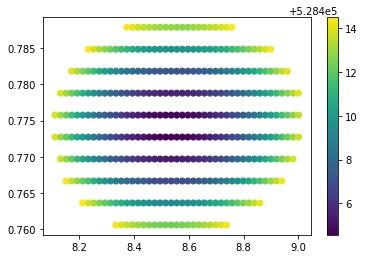

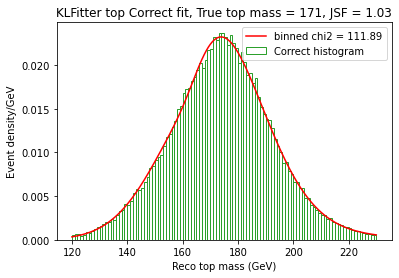

528404.4782177393


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5.284e+05                  │              Nfcn = 832              │
│ EDM = 0.000183 (Goal: 0.0002)    │            time = 1.0 sec            │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name      │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ lan_loc   │   177.2   │    0.6    │    -0.6    │    0.6     │ 158.802 │ 194.091 │       │
│ 1 │ lan_scale │   8.54    │   0.16    │   -0.16    │    0.16    │ 7.45927 │ 9.11688 │       │
│ 2 │ gau_loc   │  170.70   │   0.29    │   -0.30    │    0.28    │ 153.61  │ 187.745 │       │
│ 3 │ gau_scale │   18.06   │   0.14    │   -0.15    │    0.15    │ 16.3089 │ 19.9331 │       │
│ 4 │ f         │   0.774   │   0.013   │   -0.013   │   0.013    │0.688629 │0.841658 │       │
└───┴───────────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │        lan_loc        │       lan_scale       │        gau_loc        │       gau_scale       │           f           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │   -0.6    │    0.6    │   -0.16   │   0.16    │   -0.30   │   0.28    │   -0.15   │   0.15    │  -0.013   │   0.013   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌───────────┬───────────────────────────────────────────────────┐
│           │   lan_loc lan_scale   gau_loc gau_scale         f │
├───────────┼───────────────────────────────────────────────────┤
│   lan_loc │     0.341   0.00863   -0.0705    -0.066  0.000491 │
│ lan_scale │   0.00863     0.026   0.00475  -0.00536  0.000327 │
│   gau_loc │   -0.0705   0.00475    0.0816    0.0249   0.00303 │
│ gau_scale │    -0.066  -0.00536    0.0249    0.0211  0.000457 │
│         f │  0.000491  0.000327   0.00303  0.000457   0.00017 │
└───────────┴───────────────────────────────────────────────────┘

In [174]:
fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
tot_event = len(fit_target)
tol = 0.1
while True:
    try:
        start = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        minuit = Minuit(fcn_top, *start)
        minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
        minuit.tol = tol
        minuit.scan()
        minuit.migrad()
        minuit.minos()
    except: tol *= 2
    else: break
popt, errors = list(minuit.values), list(minuit.errors)
fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt)):.2f}')
plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
plt.title(f'KLFitter top {state_labels[state_i]} fit, True top mass = {m}, JSF = {JSF}')
plt.xlabel('Reco top mass (GeV)')
plt.ylabel('Event density/GeV')
plt.legend(loc='upper right')
plt.show()
print(minuit.fval)
minuit

In [ ]:
pdf_klf_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_klf_top_dic[(state_i, i)] = popt

        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label=f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title(f'KLFitter top PDF {state_labels[state_i]} parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass_JSF/KLFitter_param_fit/KLFitter top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.close()


In [ ]:
pdf_klf_W_dic = {(0, 0): np.array([1.82983953e+01, 8.59918081e-03, 4.52675227e+00, 4.09543440e+00]),
             (0, 1): np.array([5.20438215e+00, 1.17988437e-03, 1.48273973e+00, 7.04131763e-01]),
             (0, 2): np.array([18.67739404, -0.02309519,  4.20207902,  2.61209037]),
             (0, 3): np.array([ 1.43765716e+01, -3.34189714e-02,  2.05400761e+00,  1.25437510e-02]),
             (0, 4): np.array([ 7.59458733e+00,  1.88171264e-03,  1.07975211e-01, -7.26340682e-03]),
             (1, 0): np.array([ 1.67950425e+01, -5.97384532e-04,  4.91104877e+00,  4.53826285e+00]),
             (1, 1): np.array([ 5.38259367, -0.02827962,  1.24574683,  0.82637711]),
             (1, 2): np.array([ 3.45460710e+01, -7.04861019e-03,  2.42248312e+00,  1.69030649e+00]),
             (1, 3): np.array([ 7.65486494, -0.0451477 ,  2.84686729,  0.84147381]),
             (1, 4): np.array([ 3.15390686e-01,  1.07653209e-03,  1.51762530e+00, -1.13283097e-01]),
             (2, 0): np.array([ 1.64064453e+01, -2.48333673e-05,  4.95104453e+00,  4.86776259e+00]),
             (2, 1): np.array([ 4.36425469, -0.02378765,  1.55321629, -1.57888657]),
             (2, 2): np.array([ 2.97384759e+01, -2.07196868e-02,  2.75673319e+00,  2.11837681e+00]),
             (2, 3): np.array([ 7.92900152, -0.01404336,  1.78656706, -1.13166138]),
             (2, 4): np.array([4.27751003e-01, 1.96347361e-03, 1.27425968e+00, 4.78505058e+00])}
fit_limit = [(0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1)]

In [ ]:
# Fit KLFitter reconstucted W mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)]==state_i))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            tot_event = len(fit_target)
            tol = 0.1
            while True:
                try:
                    start = [linear_linear((m, JSF), *pdf_klf_W_dic[(state_i, j)]) for j in range(5)]
                    minuit = Minuit(fcn_W, *start)
                    minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
                    minuit.tol = tol
                    minuit.migrad(iterate=100)
                    minuit.minos()
                except: tol *= 2
                else: break
            popt, errors = list(minuit.values), list(minuit.errors)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label=f'binned chi2 = {chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt)):.2f}')
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'KLFitter W {state_labels[state_i]} fit, True top mass = {m}, JSF = {JSF}')
            plt.xlabel('Reco W mass (GeV)')
            plt.ylabel('Event density/GeV')
        plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_fit/KLFitter W {state_labels[state_i]} fit, True top mass = {m}.png', bbox_inches='tight')
        plt.close()

In [ ]:
pdf_klf_W_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_klf_W_dic[(state_i, i)] = popt

        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label=f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title(f'KLFitter W PDF parameters with errobar')
        plt.xlabel('True top mass (GeV)')
        plt.ylabel(twogau_fit_labels[i])
    plt.savefig(f'plots_topmass_JSF/KLFitter_param_fit/KLFitter W {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.close()

In [ ]:
pdf_spanet_top_dic = {(0, 0): np.array([37.82686918,  0.10258127,  4.00309585,  3.21944186]),
             (0, 1): np.array([7.27236707, 0.03493328, 1.92815801, 4.41375263]),
             (0, 2): np.array([2.44983346e+01, 1.36993781e-02, 6.96662477e+00, 6.92670616e+00]),
             (0, 3): np.array([ 3.29315070e+00, -1.06659581e-03,  7.55658513e+00,  8.68749333e-01]),
             (0, 4): np.array([10.56249729,  0.09416909,  0.07539822, -0.09435835]),
             (1, 0): np.array([23.96224743,  0.20978012,  6.67005659, -1.87762807]),
             (1, 1): np.array([ 1.01734326e+01, -9.81410626e-03,  1.52851746e+00,  3.08001745e+00]),
             (1, 2): np.array([2.47838687e+01, 1.20145587e-02, 6.76850936e+00, 6.80902775e+00]),
             (1, 3): np.array([7.03171816, 0.03506045, 2.81775281, 1.27504115]),
             (1, 4): np.array([8.32815889, 0.0822603 , 0.10613222, 0.02366092]),
             (2, 0): np.array([24.99135397,  0.12776258,  6.9716312 ,  6.4684369 ]),
             (2, 1): np.array([10.02860463, -0.08131741,  0.81711373,  0.26526728]),
             (2, 2): np.array([22.74662157,  0.10771582,  7.39650777,  7.27407517]),
             (2, 3): np.array([7.90226079, 0.04571297, 2.2691823 , 2.46864516]),
             (2, 4): np.array([-5.29891038, -0.01472624, -0.14682059, -0.04055568])}
fit_limit = [(0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1)]

In [ ]:
# Fit SPAnet reconstructed top mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            tot_event = len(fit_target)
            tol = 0.1
            while True:
                try:
                    start = [linear_linear((m, JSF), *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
                    minuit = Minuit(fcn_top, *start)
                    minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
                    minuit.tol = tol
                    minuit.migrad(iterate=100)
                    minuit.minos()
                except: tol *= 2
                else: break
            popt, errors = list(minuit.values), list(minuit.errors)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
            plt.title(f'SPAnet top {state_labels[state_i]} fit, True top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc = 'upper right')
        plt.savefig(f'plots_topmass_JSF/SPAnet_pdf_fit/SPAnet top {state_labels[state_i]} fit, True top mass = {m}.png', bbox_inches='tight')
        plt.close()


In [ ]:
pdf_spanet_top_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_spanet_top_dic[(state_i, i)] = popt
        
        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label= f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title('SPAnet top PDF parameters with errobar')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass_JSF/SPAnet_param_fit/SPAnet top {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.close()
    

In [ ]:
pdf_spanet_W_dic = {(0, 0): np.array([18.11186565,  0.02092059,  3.9413653 ,  0.84865183]),
             (0, 1): np.array([ 5.86058662,  0.01604587,  1.82973169, -1.19898934]),
             (0, 2): np.array([1.67533797e+01, 3.66458037e-03, 5.27510302e+00, 2.16194796e+00]),
             (0, 3): np.array([7.59350108e+00, 2.10177535e-03, 1.94995905e+00, 2.26002189e-01]),
             (0, 4): np.array([-1.86605617e+00, -8.15232547e-04, -3.27606269e-01, -8.99763622e-01]),
             (1, 0): np.array([2.45486185e+01, 1.35271097e-02, 3.28423562e+00, 3.30135620e+00]),
             (1, 1): np.array([9.26178915e+00, 6.76445189e-03, 1.24216493e+00, 1.63320019e+00]),
             (1, 2): np.array([ 2.02422820e+01, -6.37368761e-04,  5.19106564e+00,  8.03683210e+00]),
             (1, 3): np.array([11.08125204, -0.09152342,  0.90279428, -5.86316585]),
             (1, 4): np.array([ 5.72469715,  0.02738392,  0.00995038, -0.10425885]),
             (2, 0): np.array([2.38590734e+01, 3.00808658e-03, 3.37760208e+00, 3.32095422e+00]),
             (2, 1): np.array([ 3.64631035, -0.04621377,  1.99126954, -7.98597885]),
             (2, 2): np.array([ 1.46860192e+01, -1.08694016e-02,  5.62116373e+00,  3.33656406e+00]),
             (2, 3): np.array([ 9.43563788, -0.04356708,  1.43655816, -2.5165282 ]),
             (2, 4): np.array([1.29083136, 0.0176473 , 0.42992515, 4.09009837])}
fit_limit = [(0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1), (0.9, 1.1)]

In [ ]:
# Fit SPAnet reconstucted W mass for every state
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            tot_event = len(fit_target)
            tol = 0.1
            while True:
                try:
                    start = [linear_linear((m, JSF), *pdf_spanet_W_dic[(state_i, j)]) for j in range(5)]
                    minuit = Minuit(fcn_W, *start)
                    minuit.limits = [start[i]*np.array(fit_limit[i]) for i in range(5)]
                    minuit.tol = tol
                    minuit.migrad(iterate=100)
                    minuit.minos()
                except: tol *= 2
                else: break
            popt, errors = list(minuit.values), list(minuit.errors)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='binned chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'SPAnet W {state_labels[state_i]} fit, True top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco W mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc='upper right')
        plt.savefig(f'plots_topmass_JSF/SPAnet_pdf_fit/SPAnet W {state_labels[state_i]} fit, True top mass = {m}.png', bbox_inches='tight')
        plt.close()


In [ ]:
pdf_spanet_W_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_spanet_W_dic[(state_i, i)] = popt
        
        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label= f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title('SPAnet W PDF parameters with errobar')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel(twogau_fit_labels[i])
    plt.savefig(f'plots_topmass_JSF/SPAnet_param_fit/SPAnet W {state_labels[state_i]} parameter fit.png', bbox_inches='tight')
    plt.close()


In [ ]:
# Fit Perfect reconstructed top mass
fit_popt_dic = {i:{} for i in [2]}
fit_perr_dic = {i:{} for i in [2]}

for state_i in [2]:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == state_i))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            tot_event = len(fit_target)
            tol = 0.1
            while True:
                try:
                    minuit = Minuit(fcn_top, 170, 30, 170, 30, 0.5)
                    minuit.limits = [(100, 250), (5, 50), (100, 250), (10, 50), (0.1, 0.9)]
                    minuit.tol = tol
                    minuit.migrad()
                    minuit.minos()
                except: tol *= 10
                else: break
            popt, errors = list(minuit.values), list(minuit.errors)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
            plt.title(f'Perfect top fit, true top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc = 'upper right')
        plt.savefig(f'plots_topmass_JSF/Perfect_pdf_fit/Perfect top fit, True top mass = {m}.png', bbox_inches='tight')
        plt.close()


In [ ]:
pdf_perfect_top_dic = defaultdict(list)
for state_i in [2]:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_perfect_top_dic[(state_i, i)] = popt
        
        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label= f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title('Perfect top PDF parameters with errobar')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass_JSF/Perfect_param_fit/Perfect top fit, True top mass = {m}.png', bbox_inches='tight')
    plt.close()

In [ ]:
# Fit Perfect reconstucted W mass
fit_popt_dic = {i:{} for i in states}
fit_perr_dic = {i:{} for i in states}

for state_i in states:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            tot_event = len(fit_target)
            tol = 0.1
            while True:
                try:
                    minuit = Minuit(fcn_W, 80, 8, 80, 30, 0.5)
                    minuit.limits = [(30, 250), (3, 50), (30, 250), (10, 100), (0.1, 0.9)]
                    minuit.tol = tol
                    minuit.migrad()
                    minuit.minos()
                except: tol *= 10
                else: break
            popt, errors = list(minuit.values), list(minuit.errors)
            fit_popt_dic[state_i][(m, JSF)], fit_perr_dic[state_i][(m, JSF)] = popt, errors
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='binned chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.title(f'Perfect W fit, True top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco W mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc='upper right')
        plt.savefig(f'plots_topmass_JSF/Perfect_pdf_fit/Perfect W fit, True top mass = {m}.png', bbox_inches='tight')
        plt.close()

In [ ]:
pdf_perfect_W_dic = defaultdict(list)
for state_i in states:
    plt.figure(figsize=(30, 20))
    for i in range(5):
        plt.subplot(2, 3, i+1)
        popt, pcov = optimize.curve_fit(linear_linear, np.transpose(list(fit_popt_dic[state_i].keys())), [fit_popt_dic[state_i][key][i] for key in fit_popt_dic[state_i]], sigma = [fit_perr_dic[state_i][key][i] for key in fit_popt_dic[state_i]], method="lm")
        pdf_perfect_W_dic[(state_i, i)] = popt
        
        for j, JSF in enumerate(JSF_arr):
            plt.errorbar(mass, [fit_popt_dic[state_i][(m, JSF)][i] for m in mass], yerr=[fit_perr_dic[state_i][(m, JSF)][i] for m in mass], fmt='o', elinewidth=2, capsize=4, label= f'JSF = {JSF}', c=colors[j])
            plt.plot(top_mass_dense, linear_linear([top_mass_dense, np.array([JSF]*1000)], *popt), '--', c=colors[j])
        plt.legend(loc='upper right')
        plt.title('Perfect W PDF parameters with errobar')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel(langau_fit_labels[i])
    plt.savefig(f'plots_topmass_JSF/Perfect_param_fit/Perfect W fit, True top mass = {m}.png', bbox_inches='tight')
    plt.close()

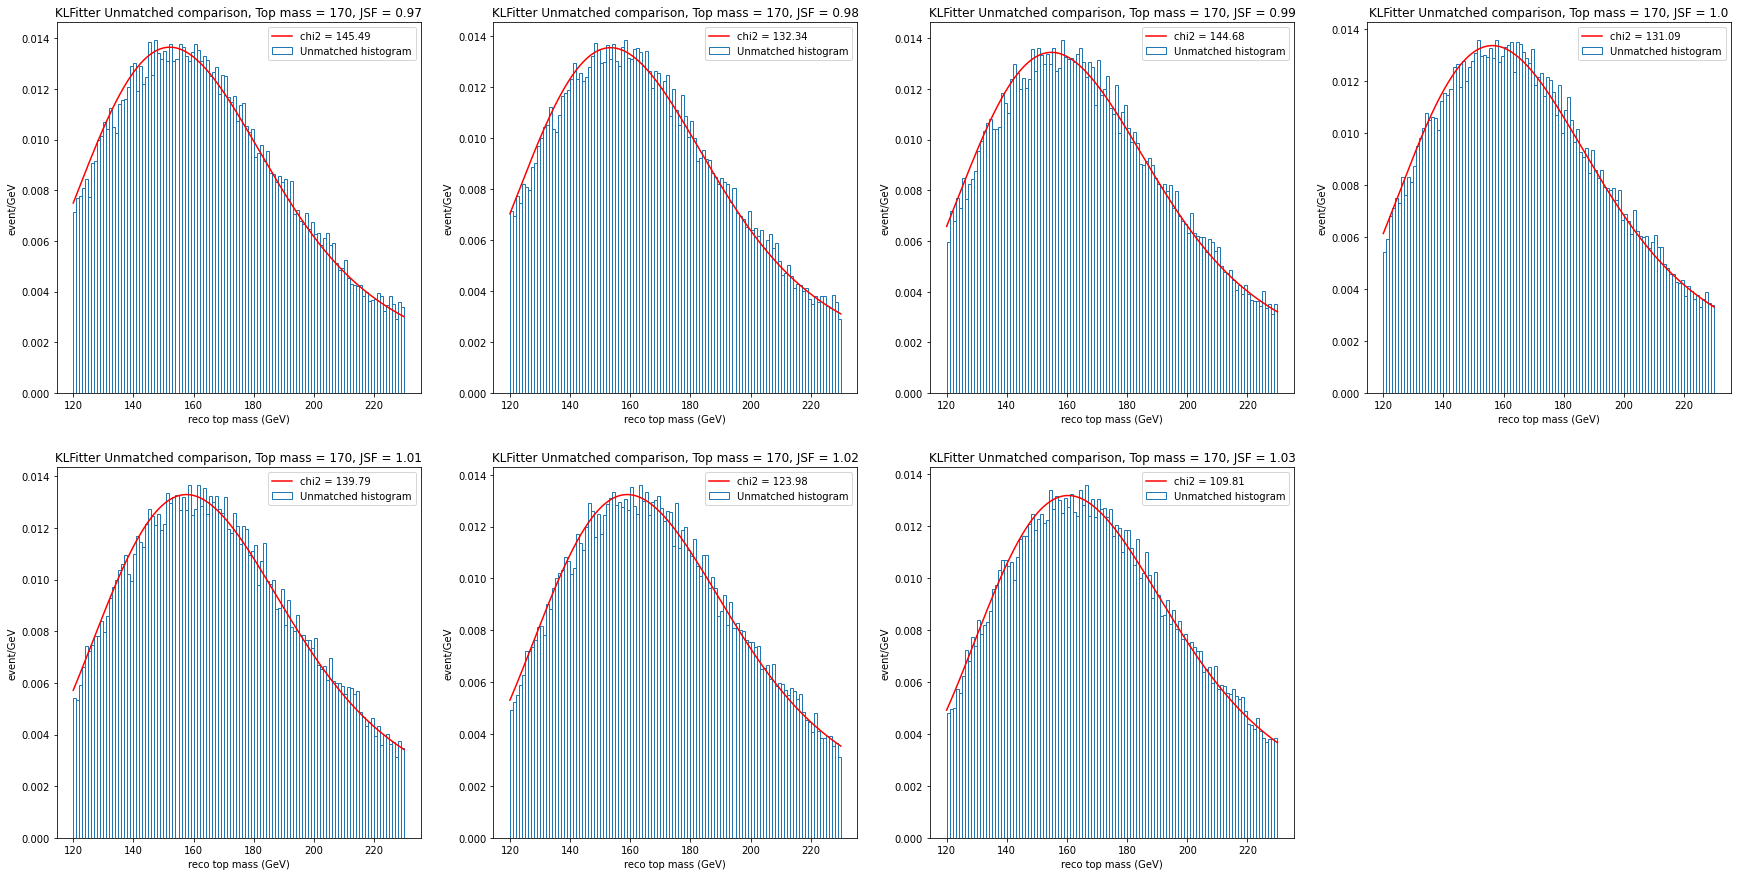

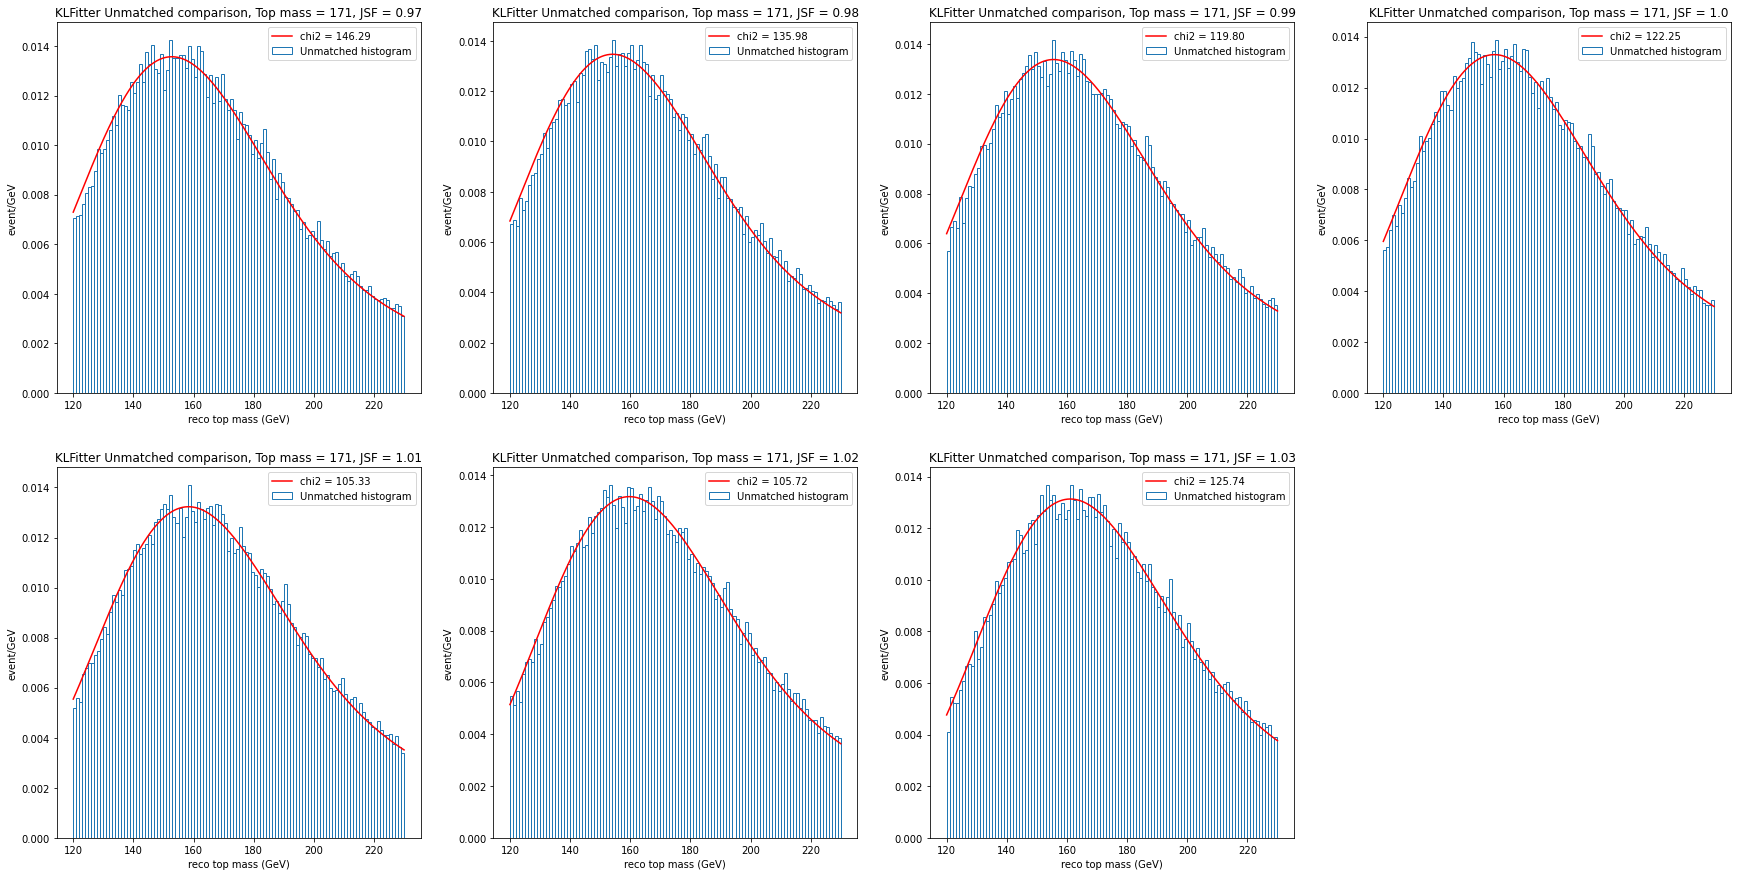

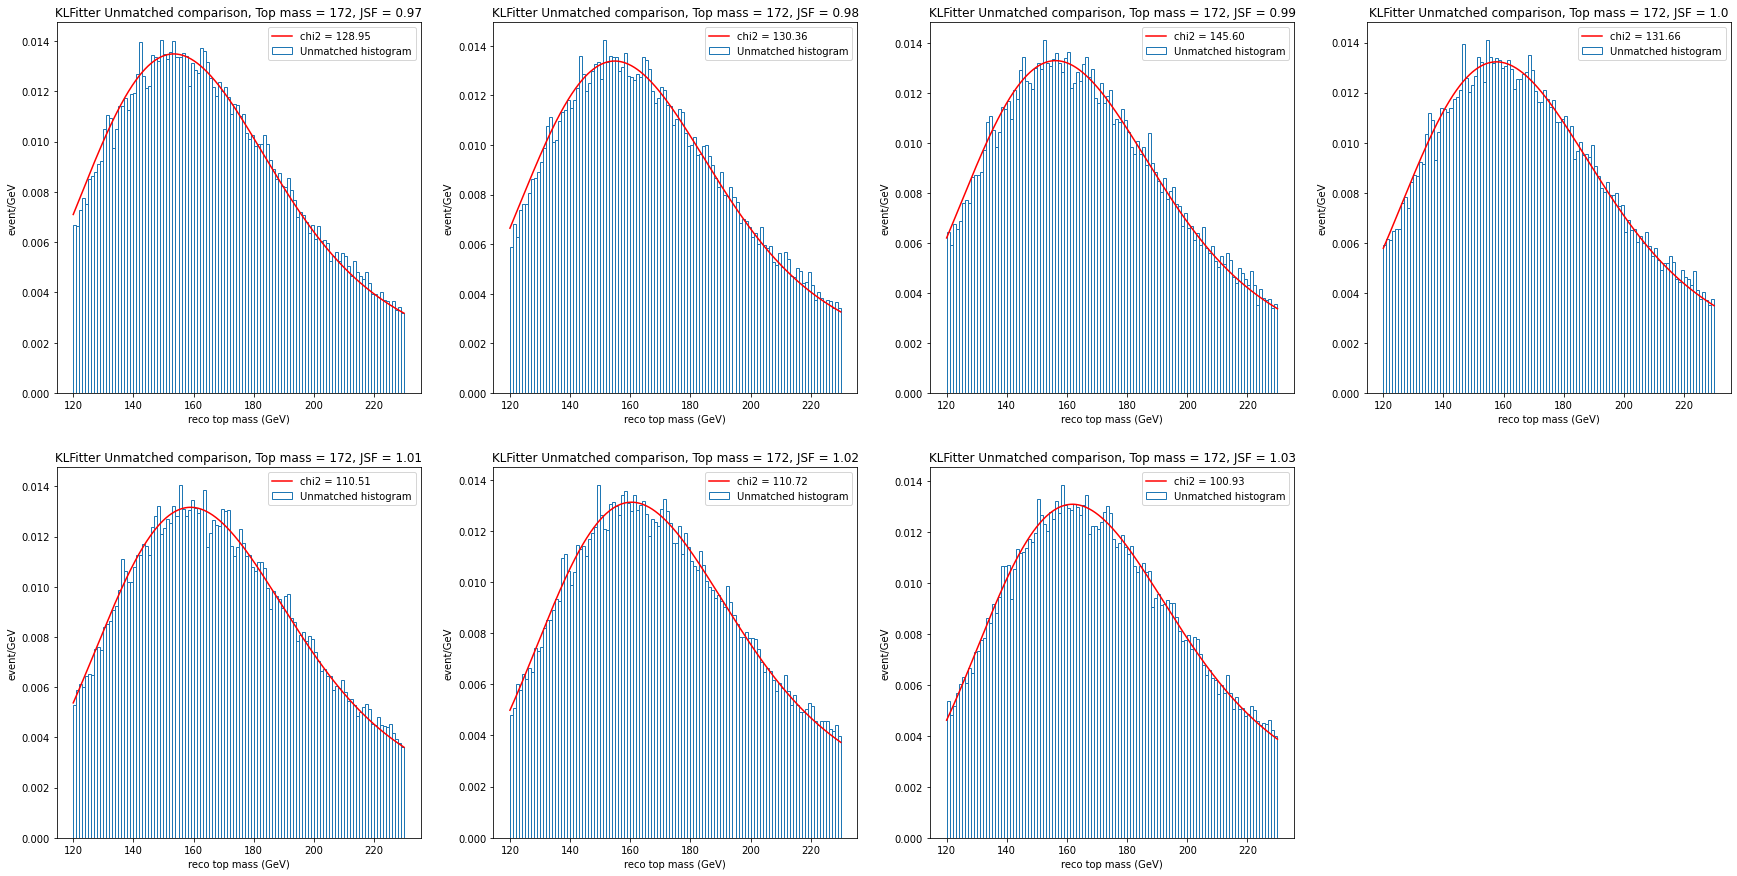

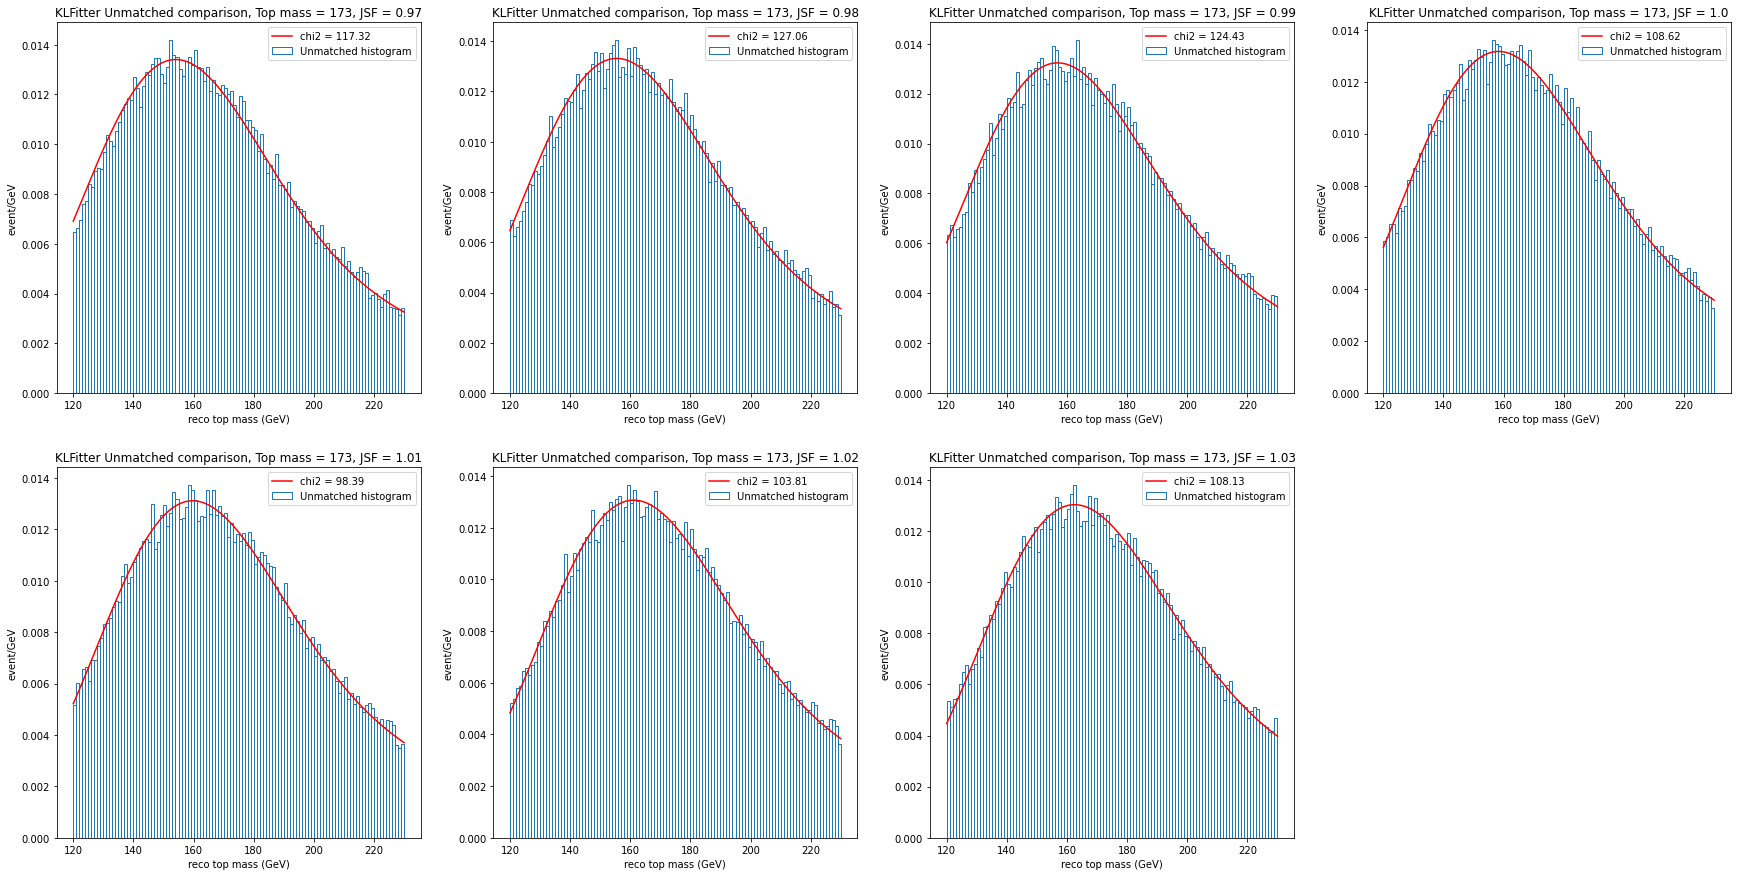

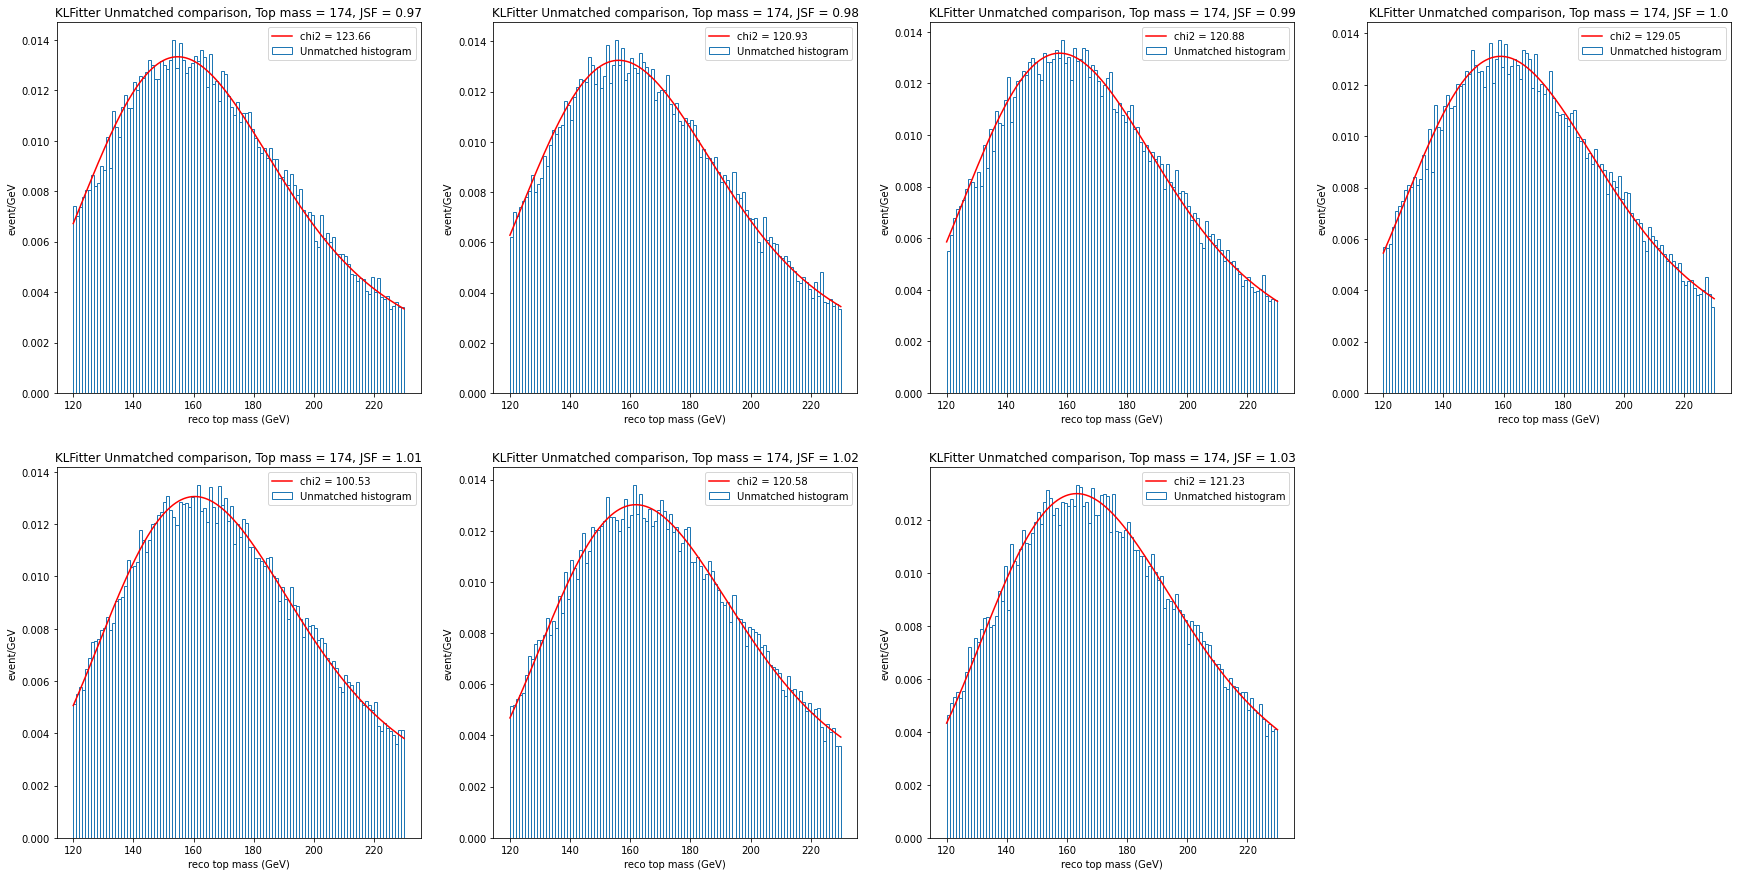

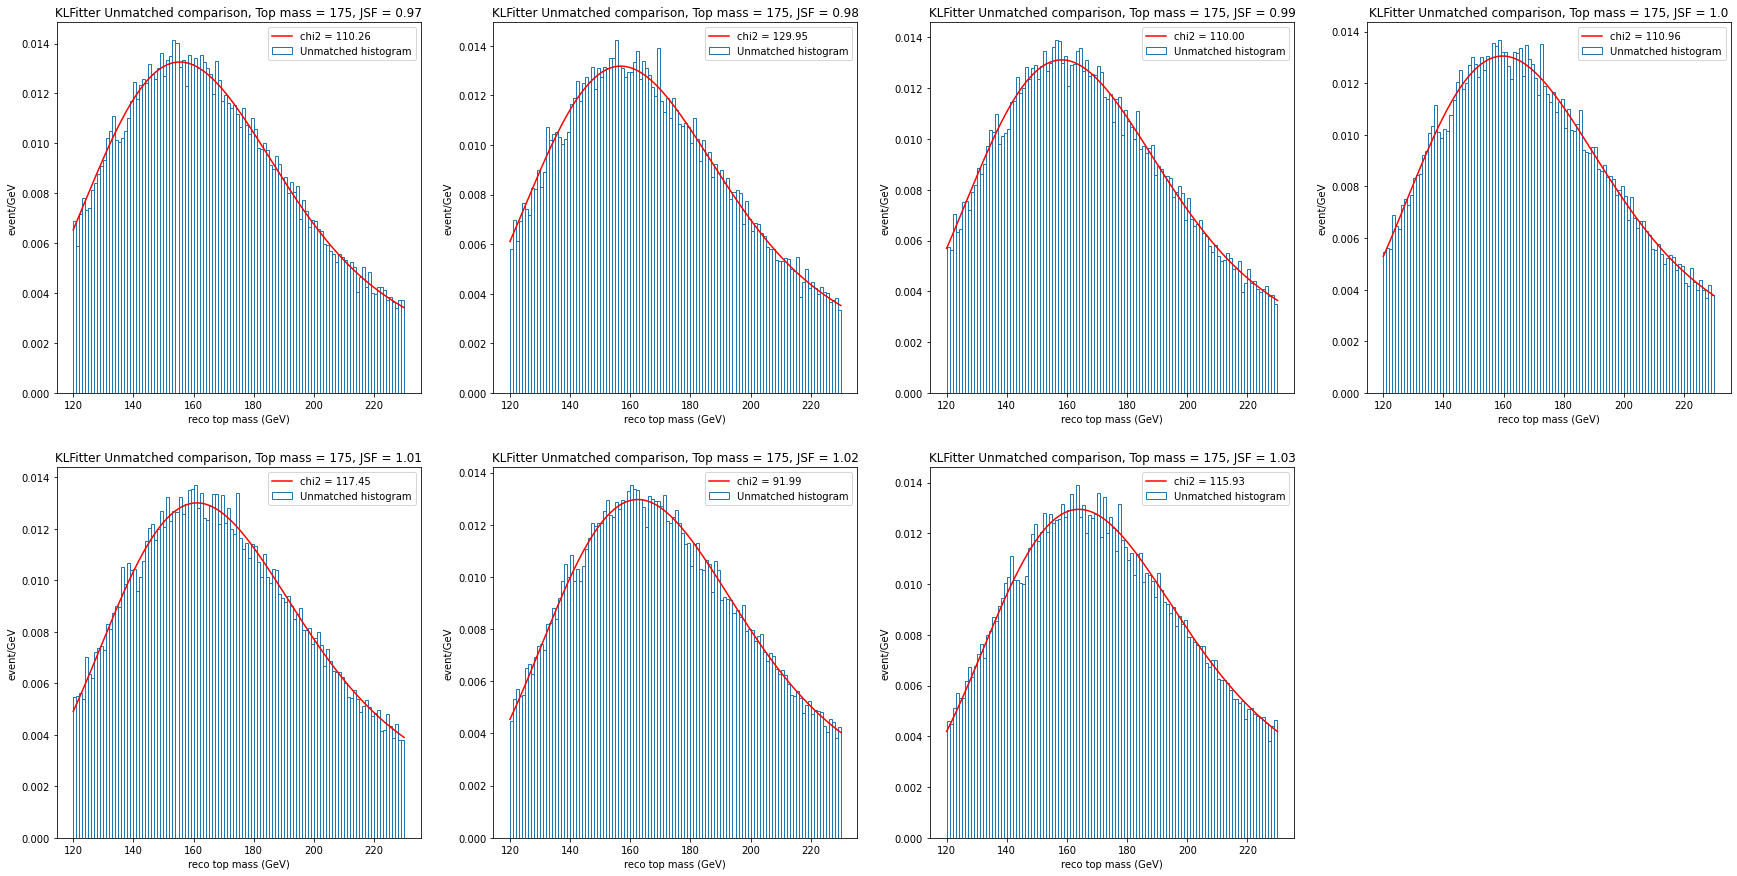

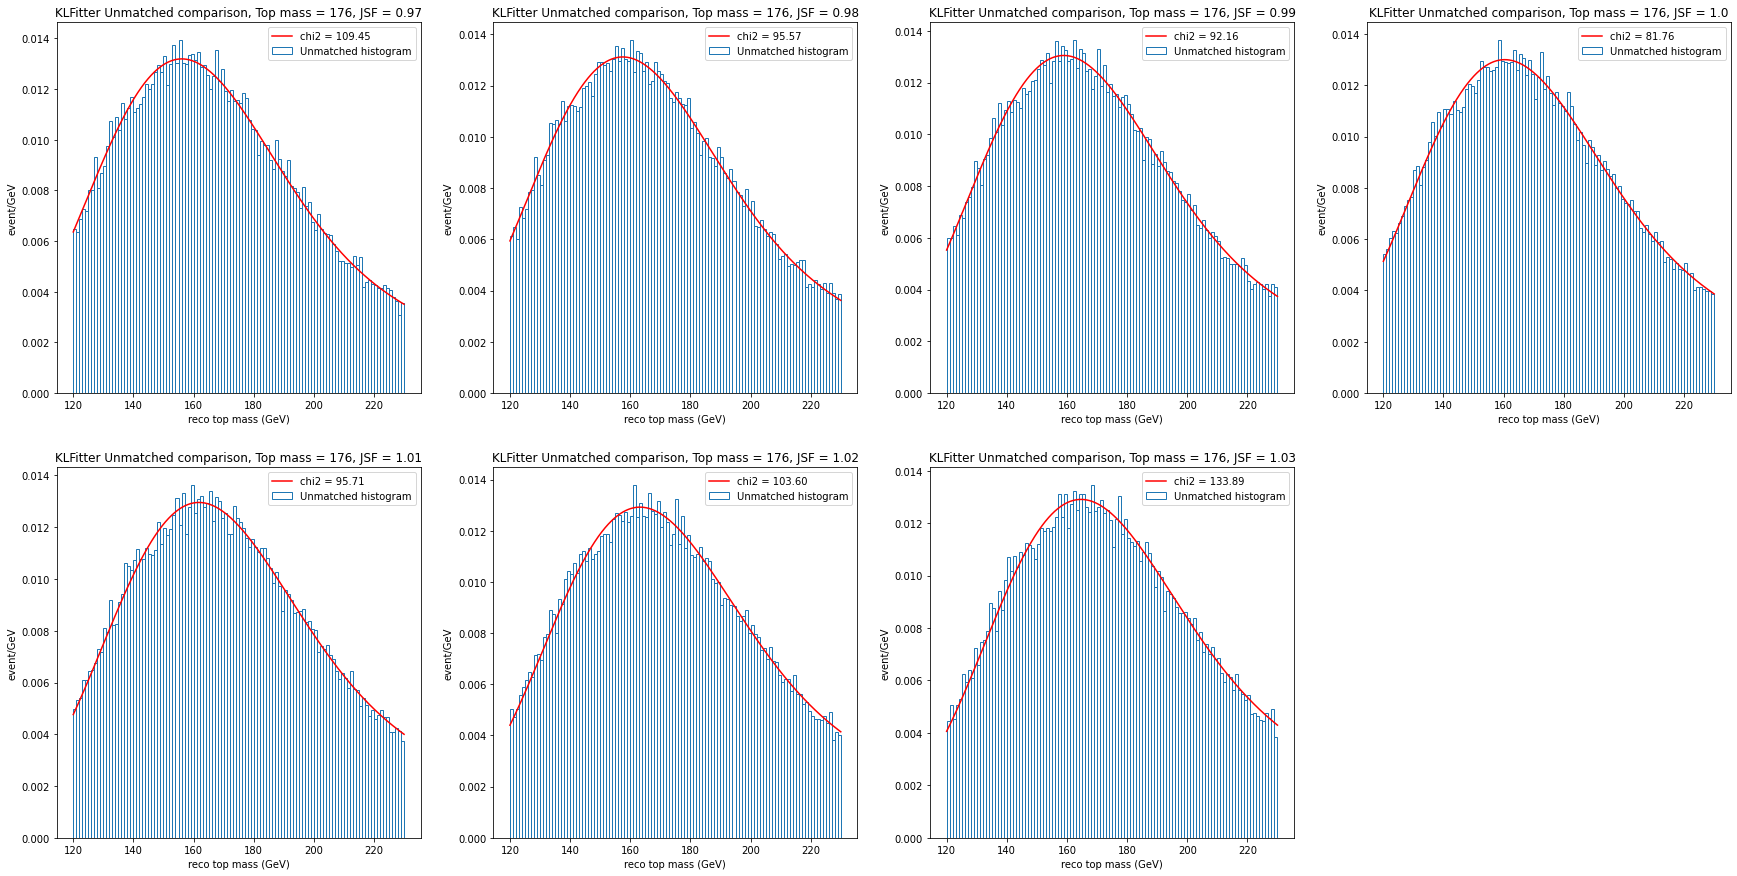

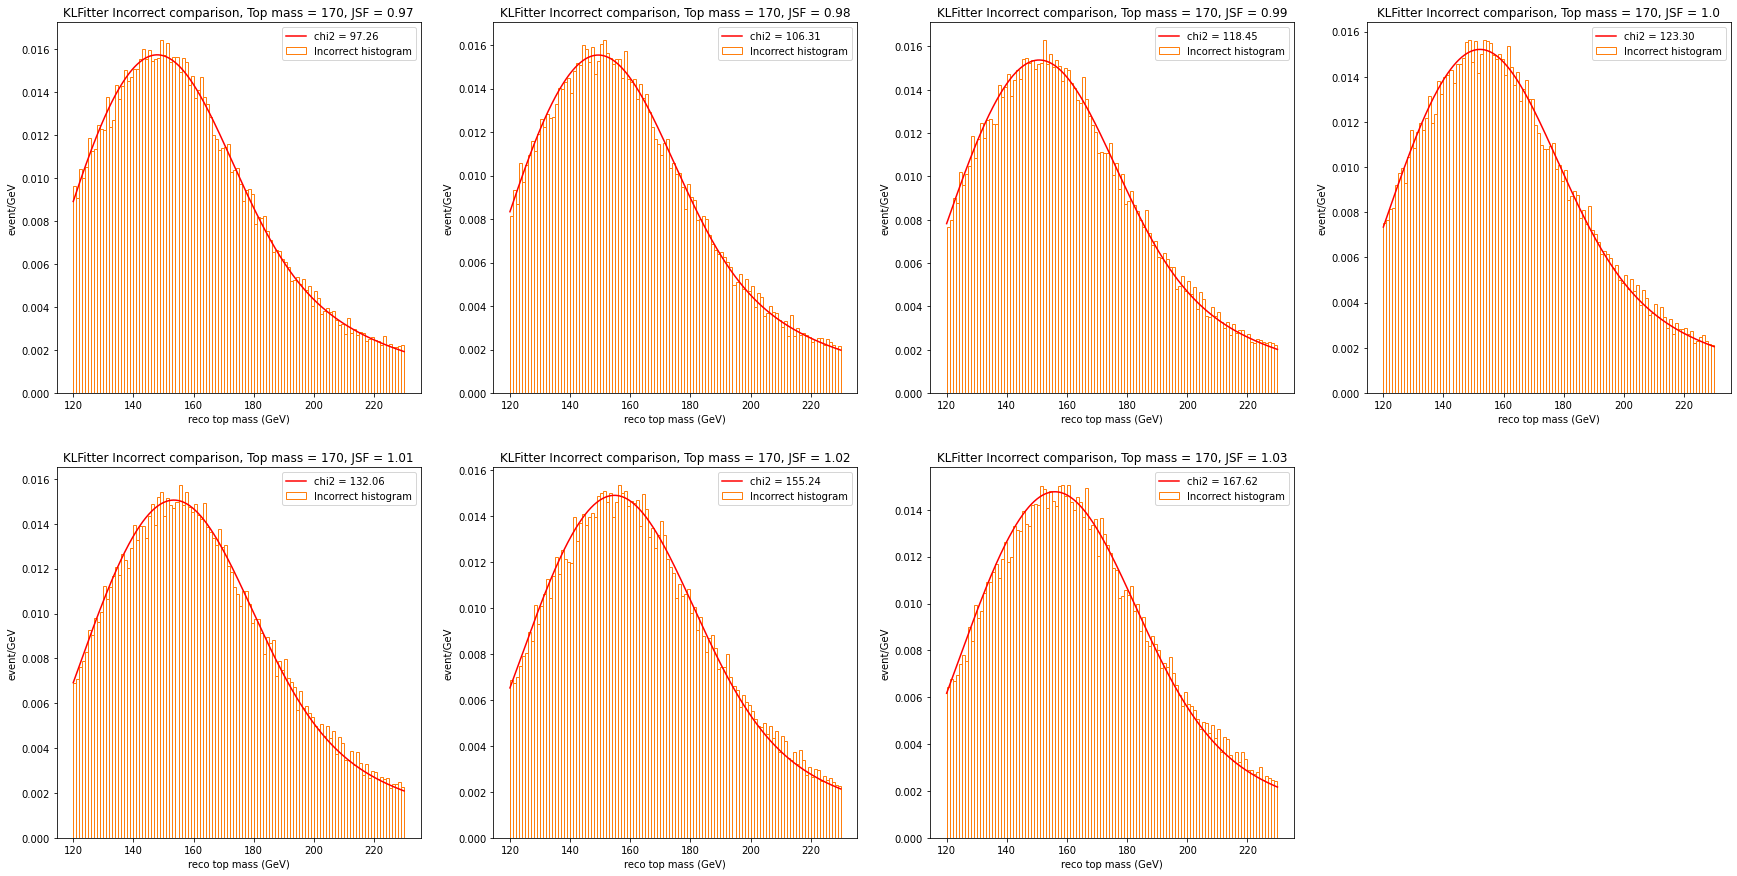

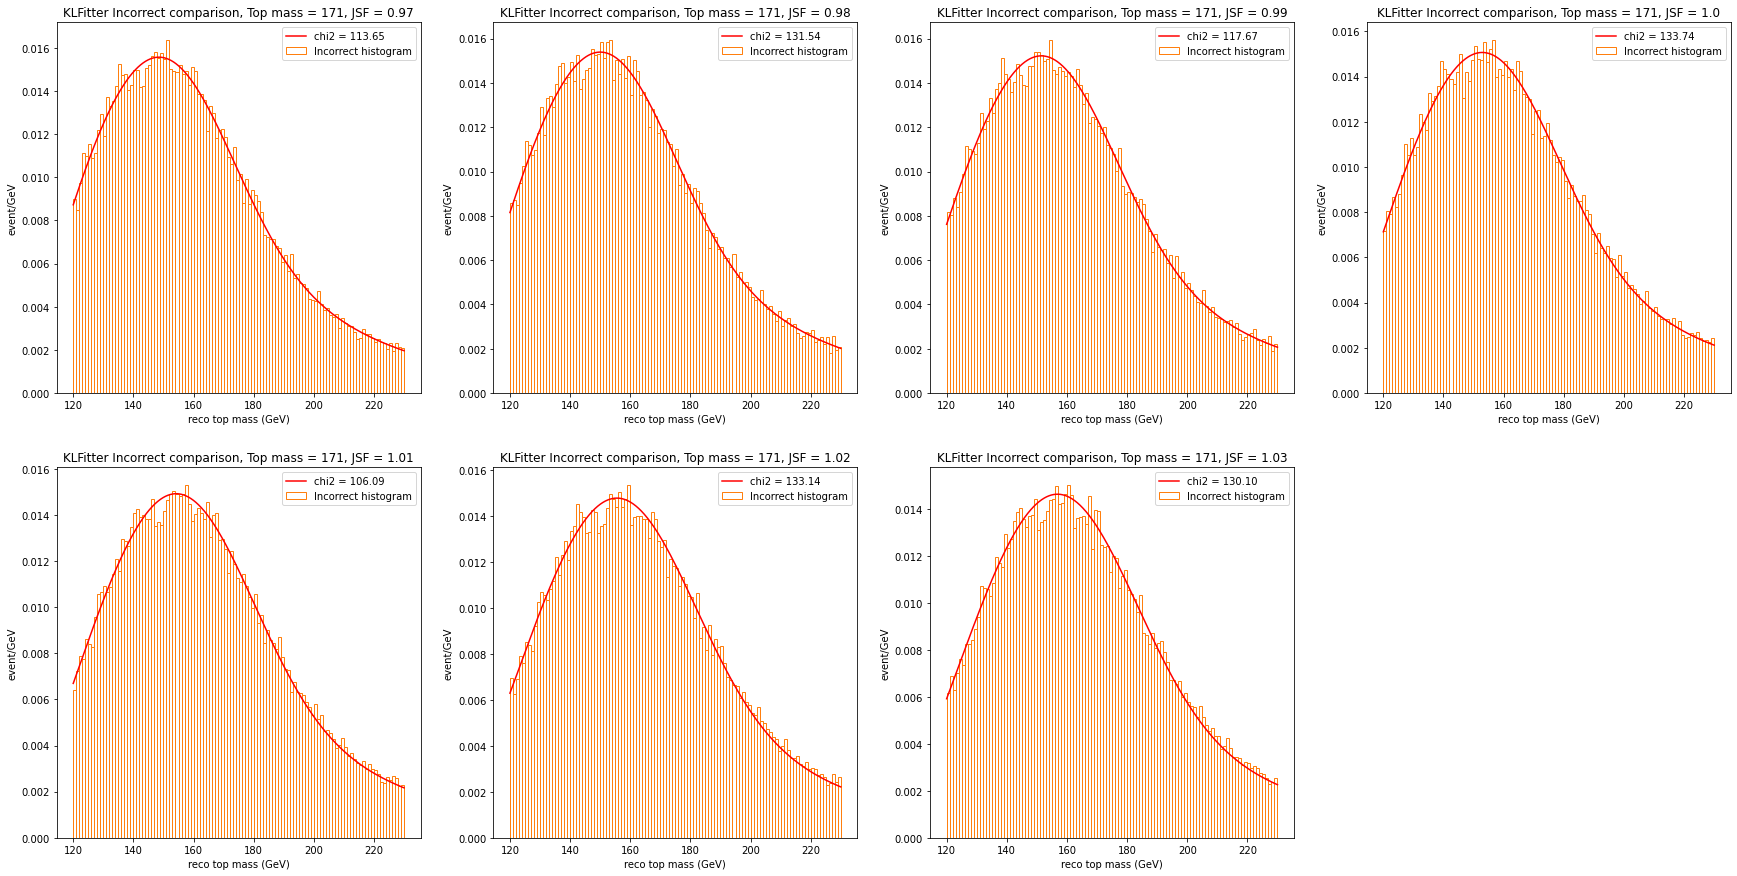

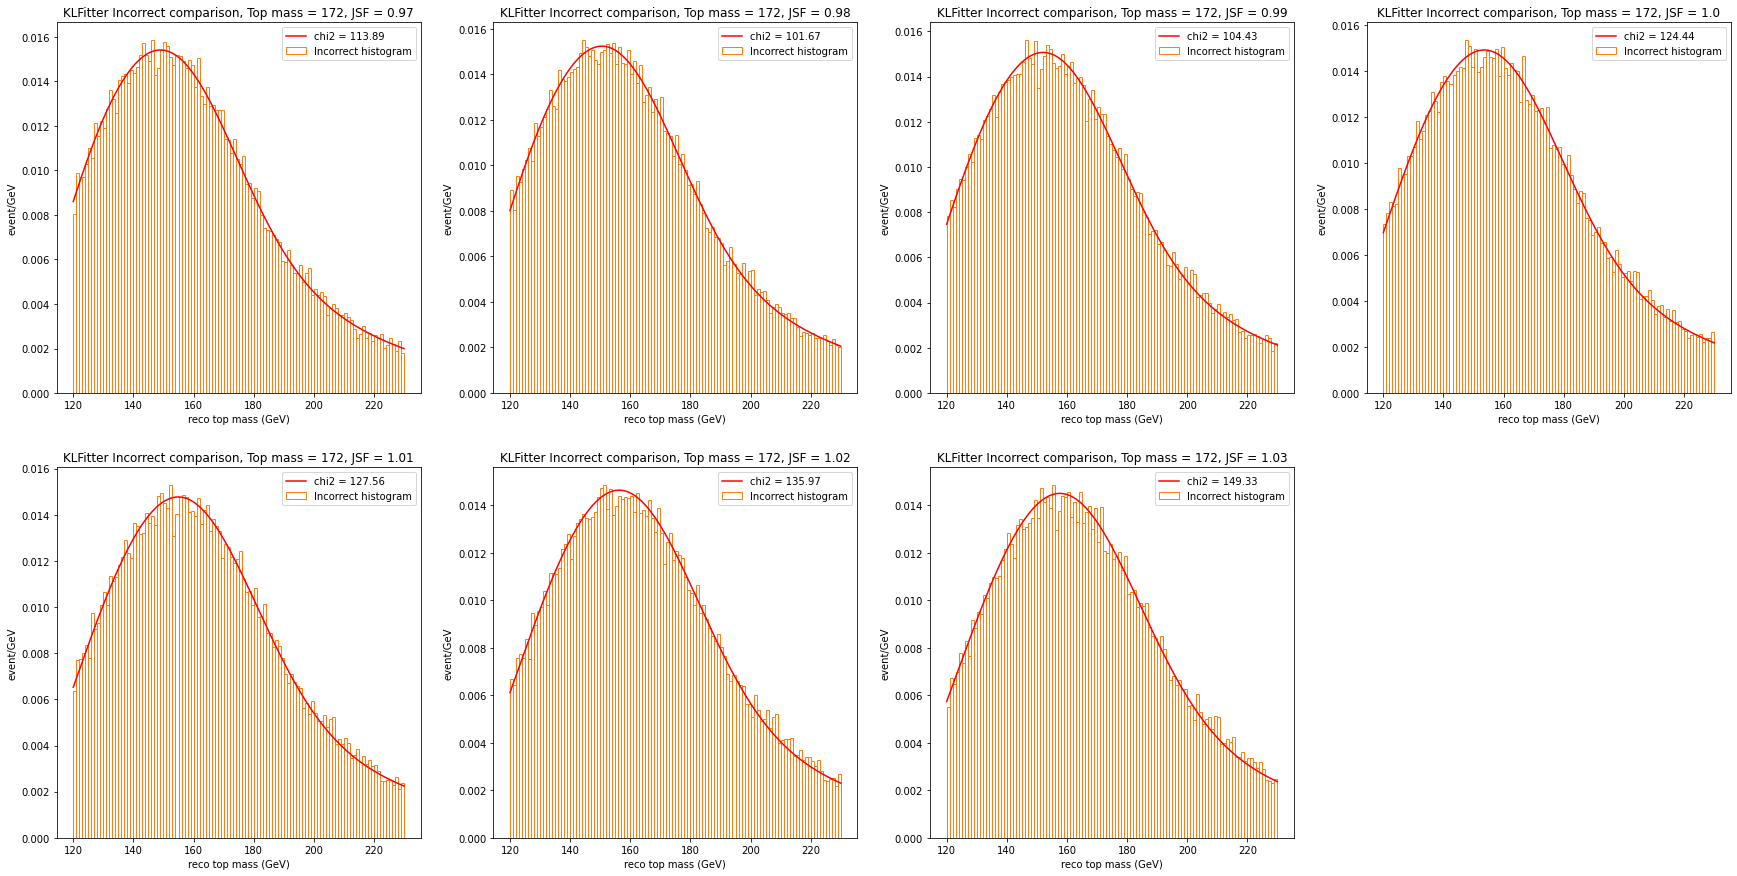

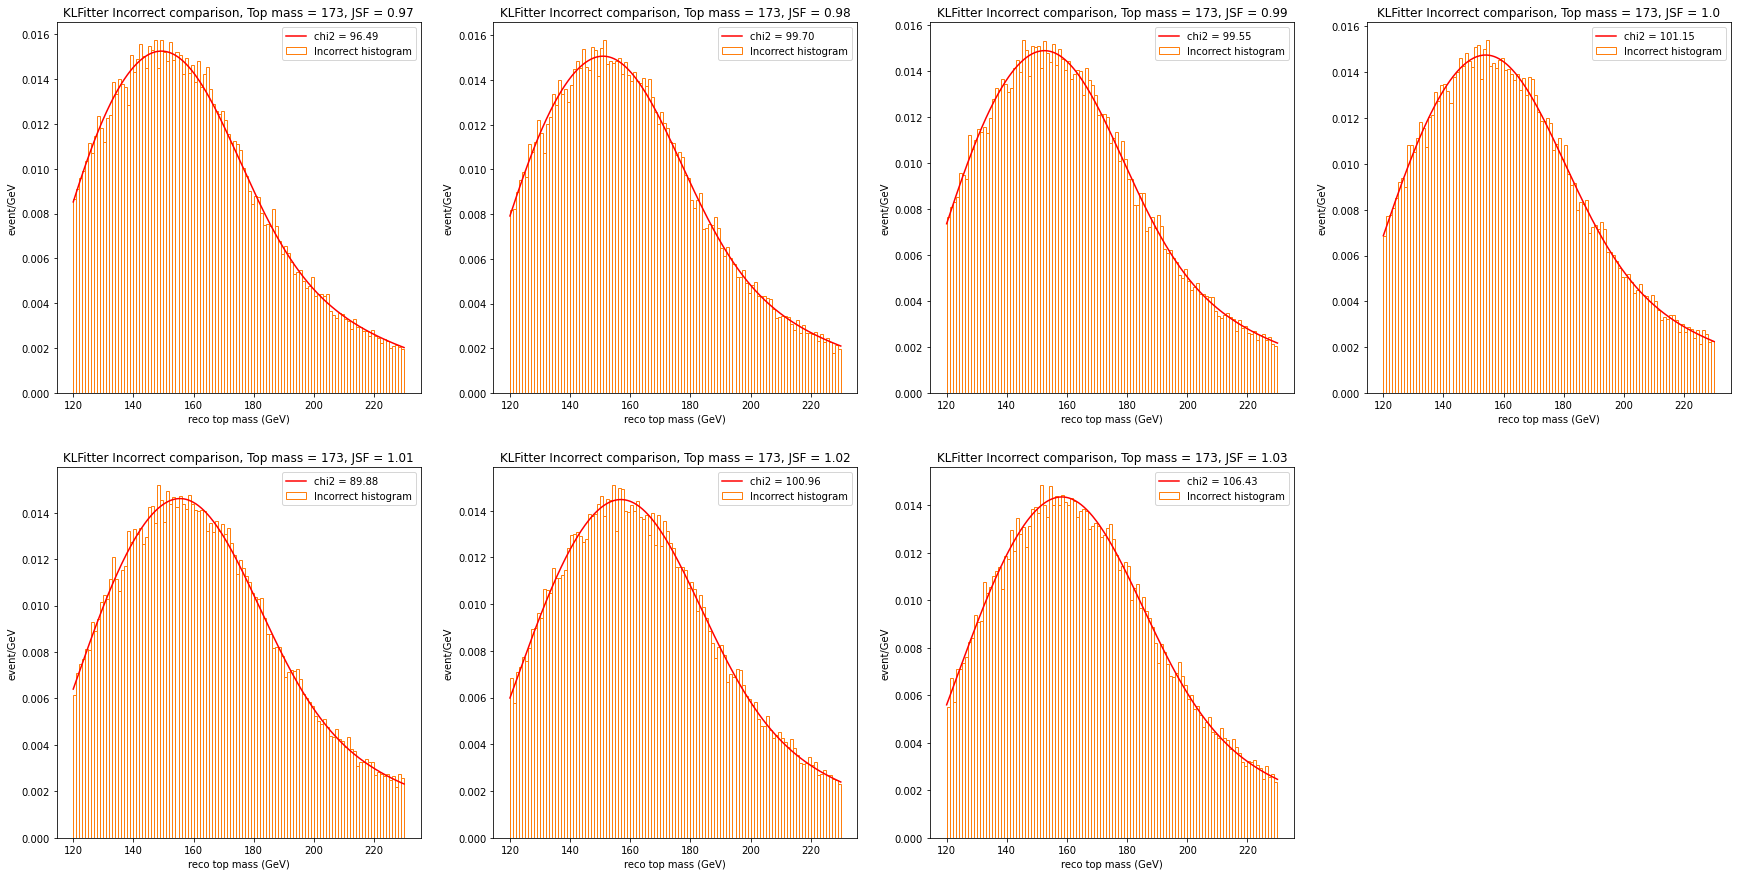

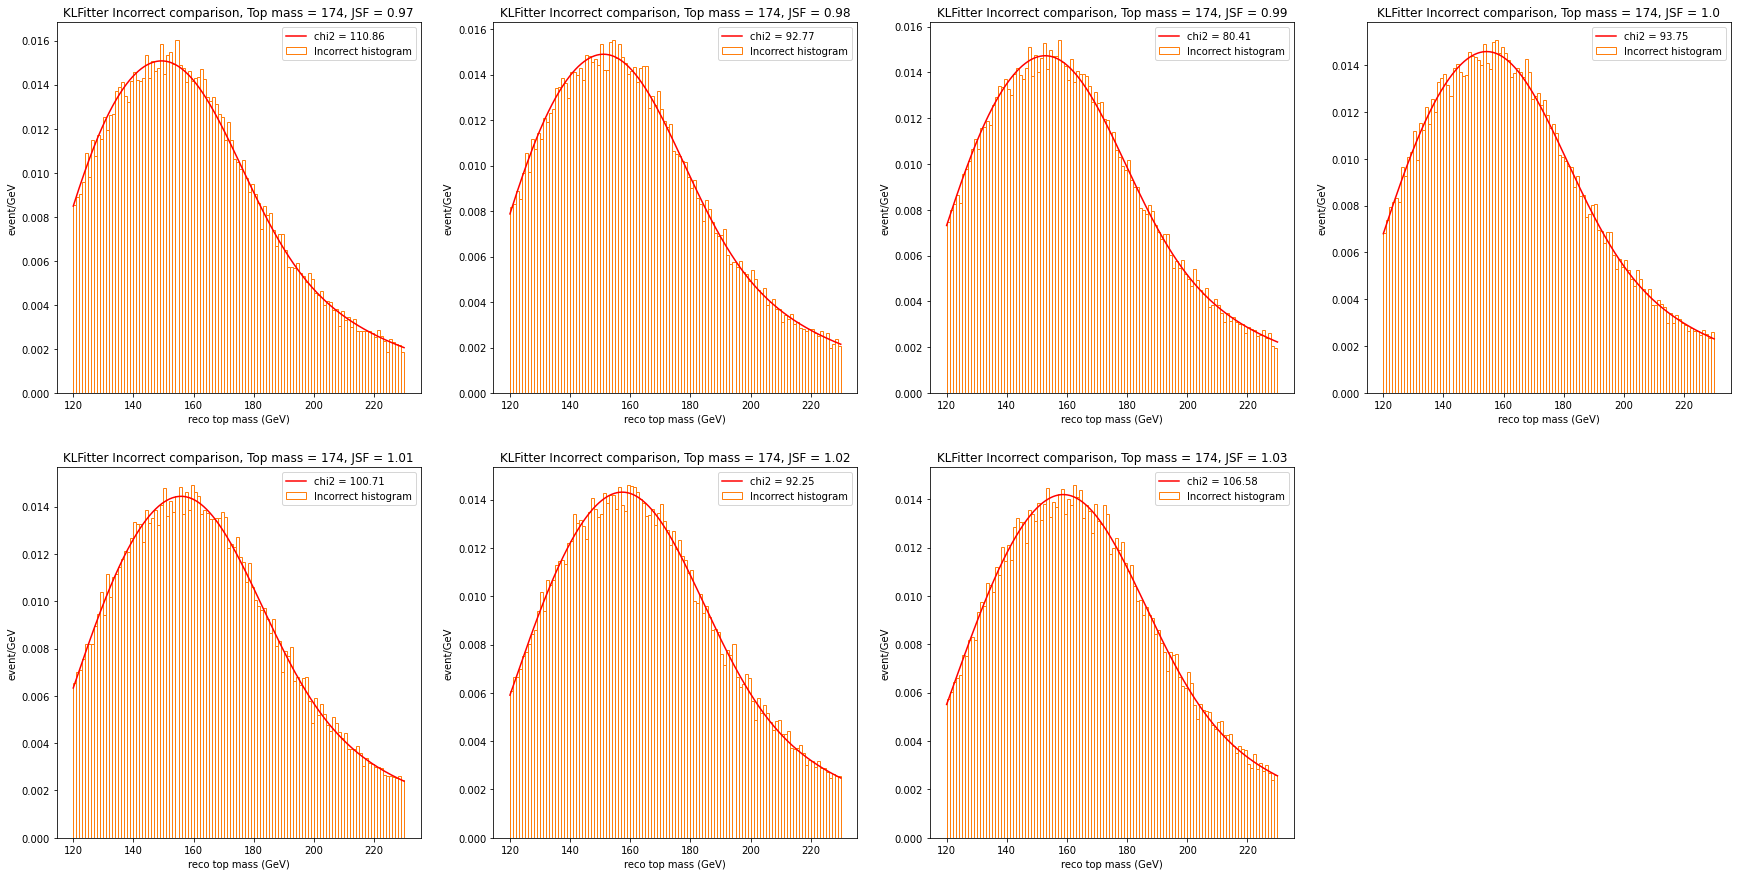

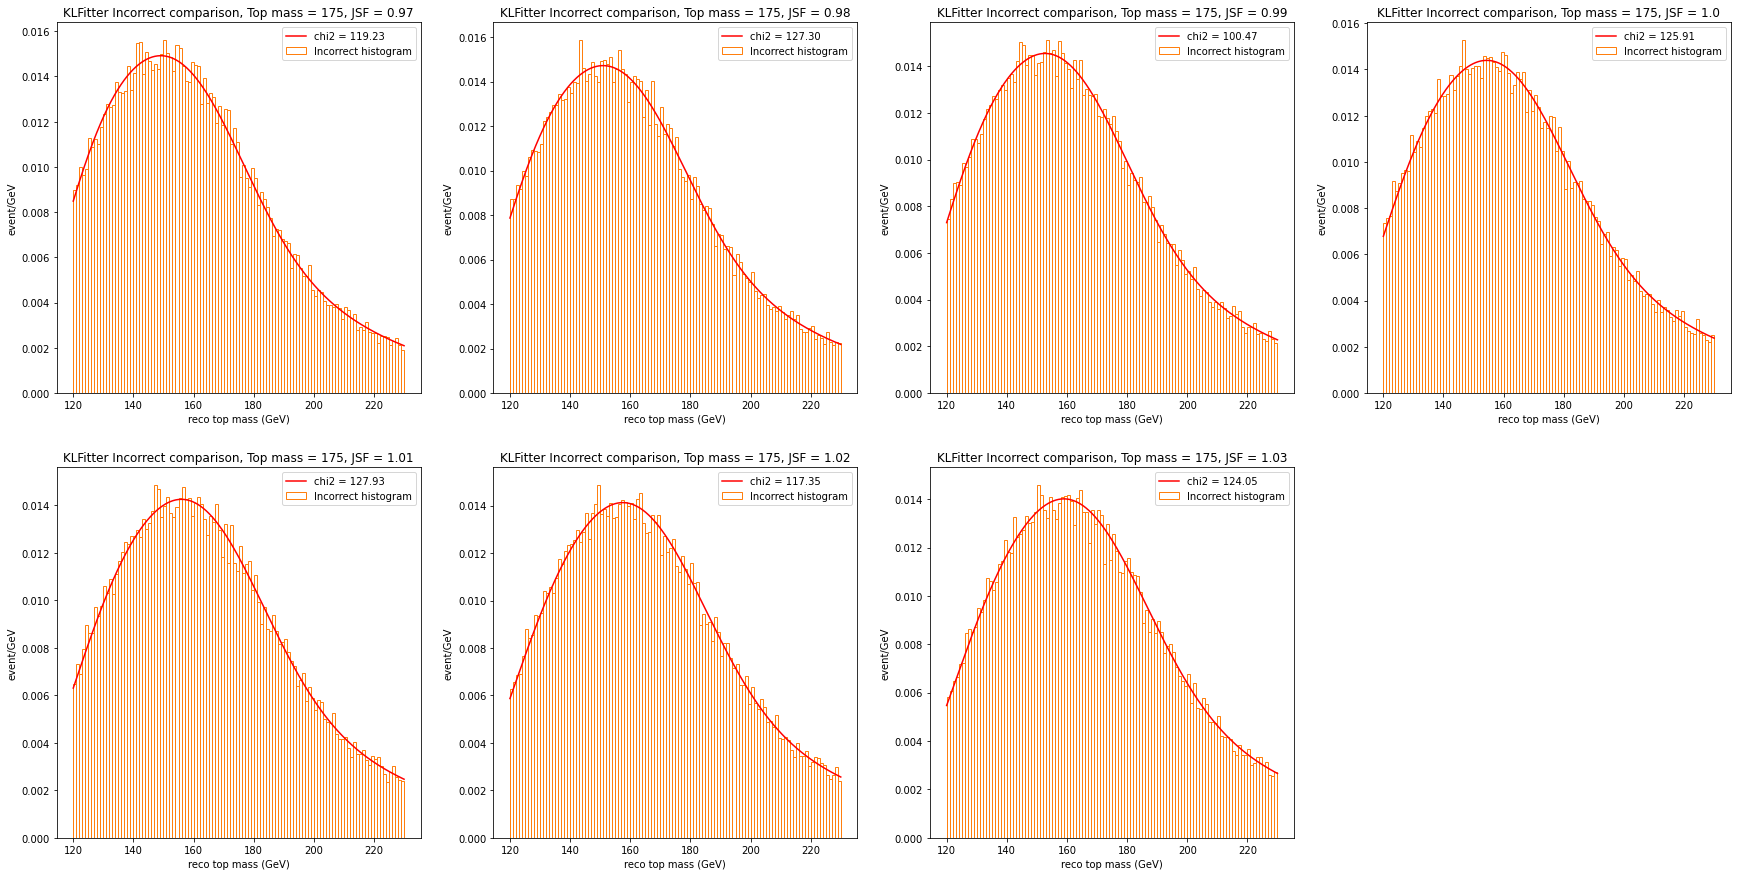

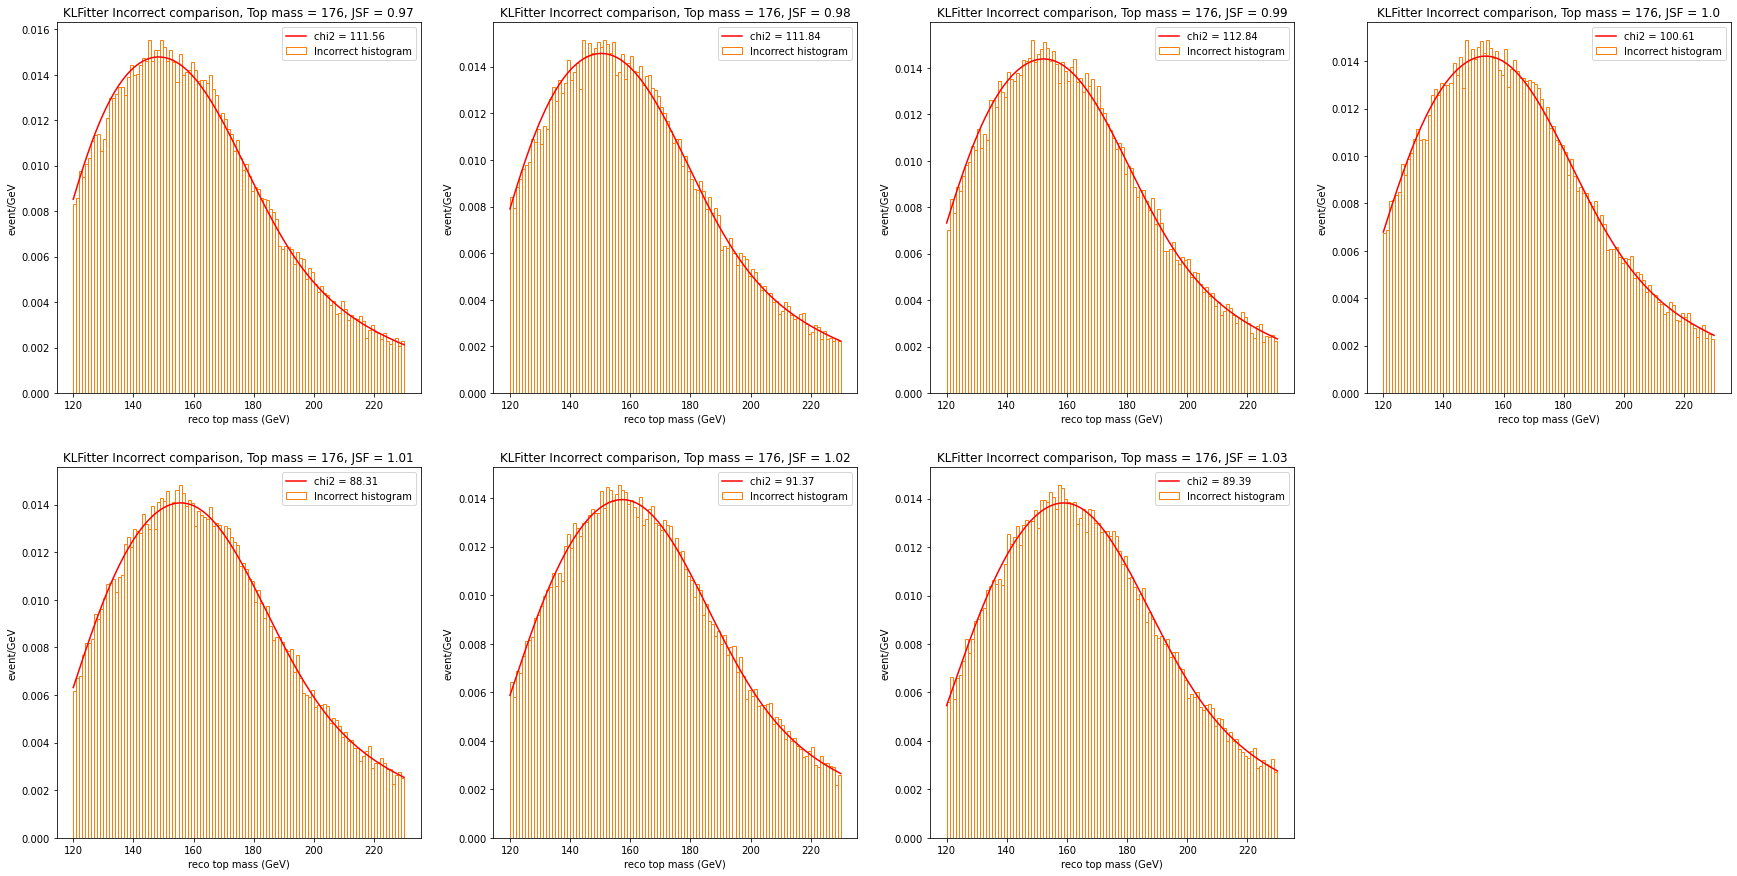

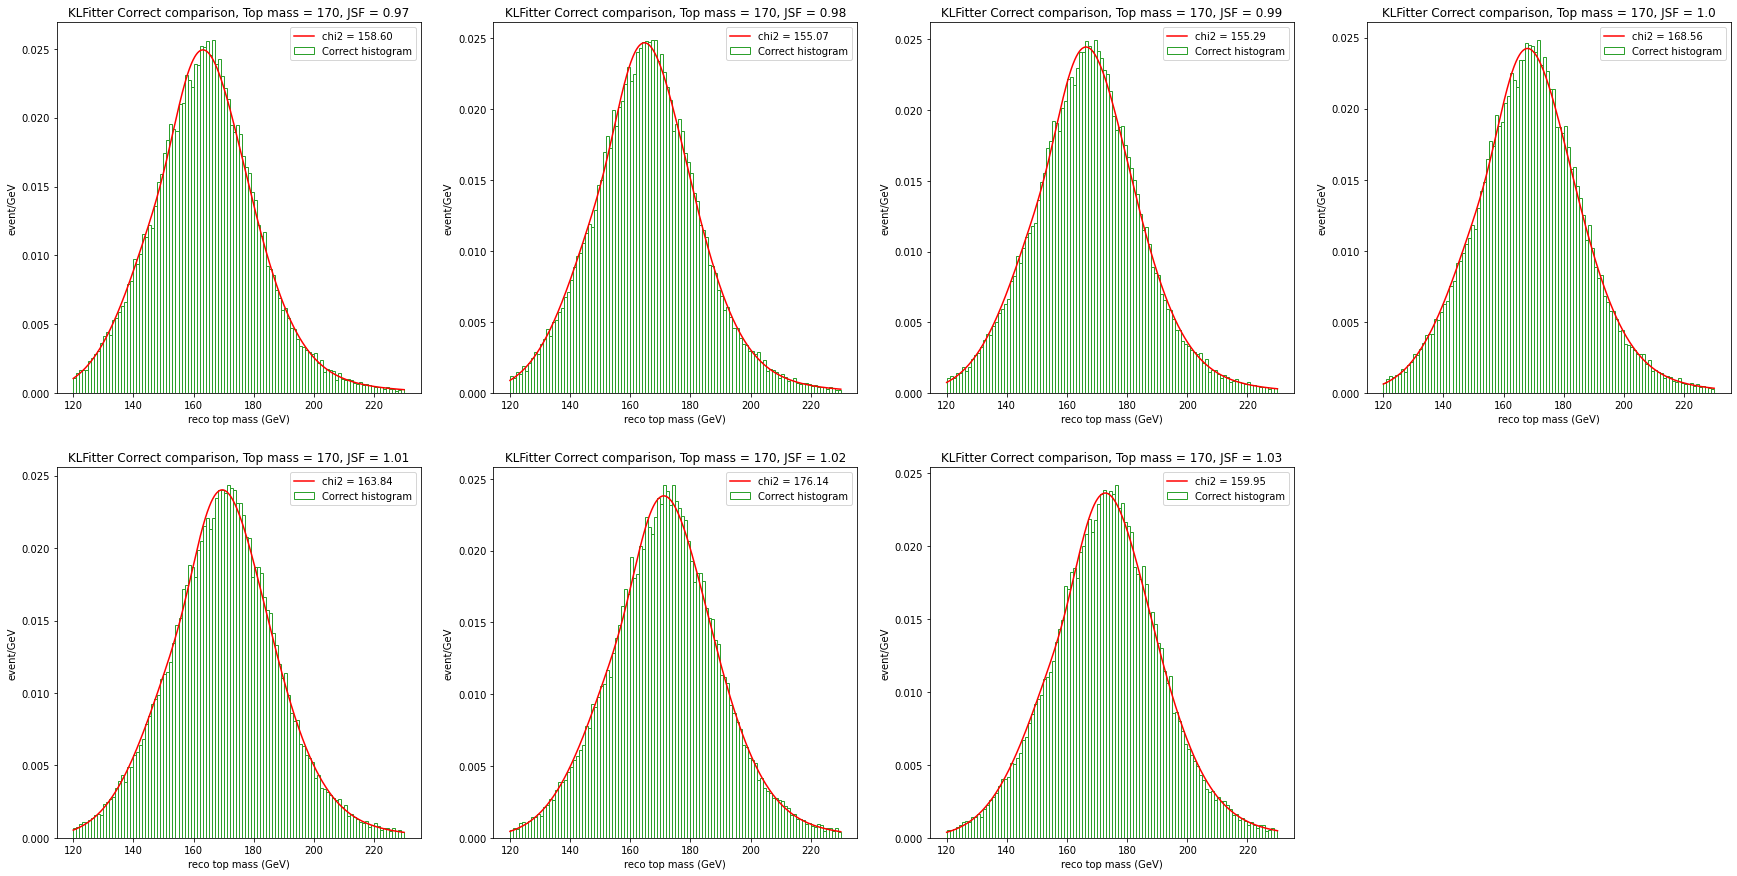

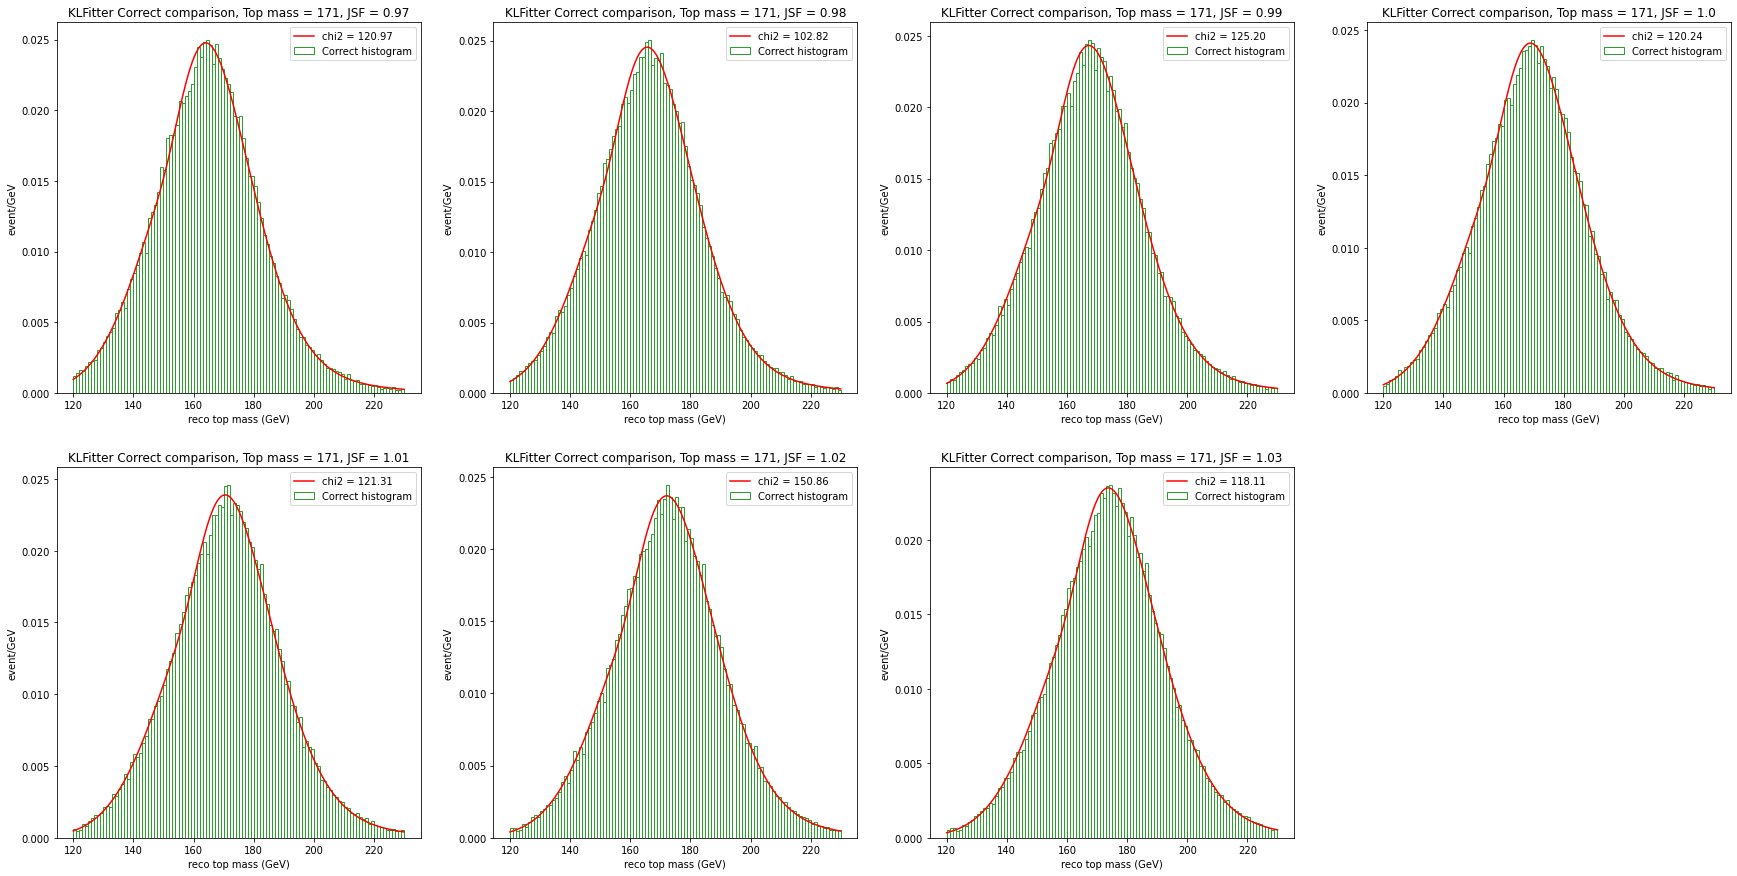

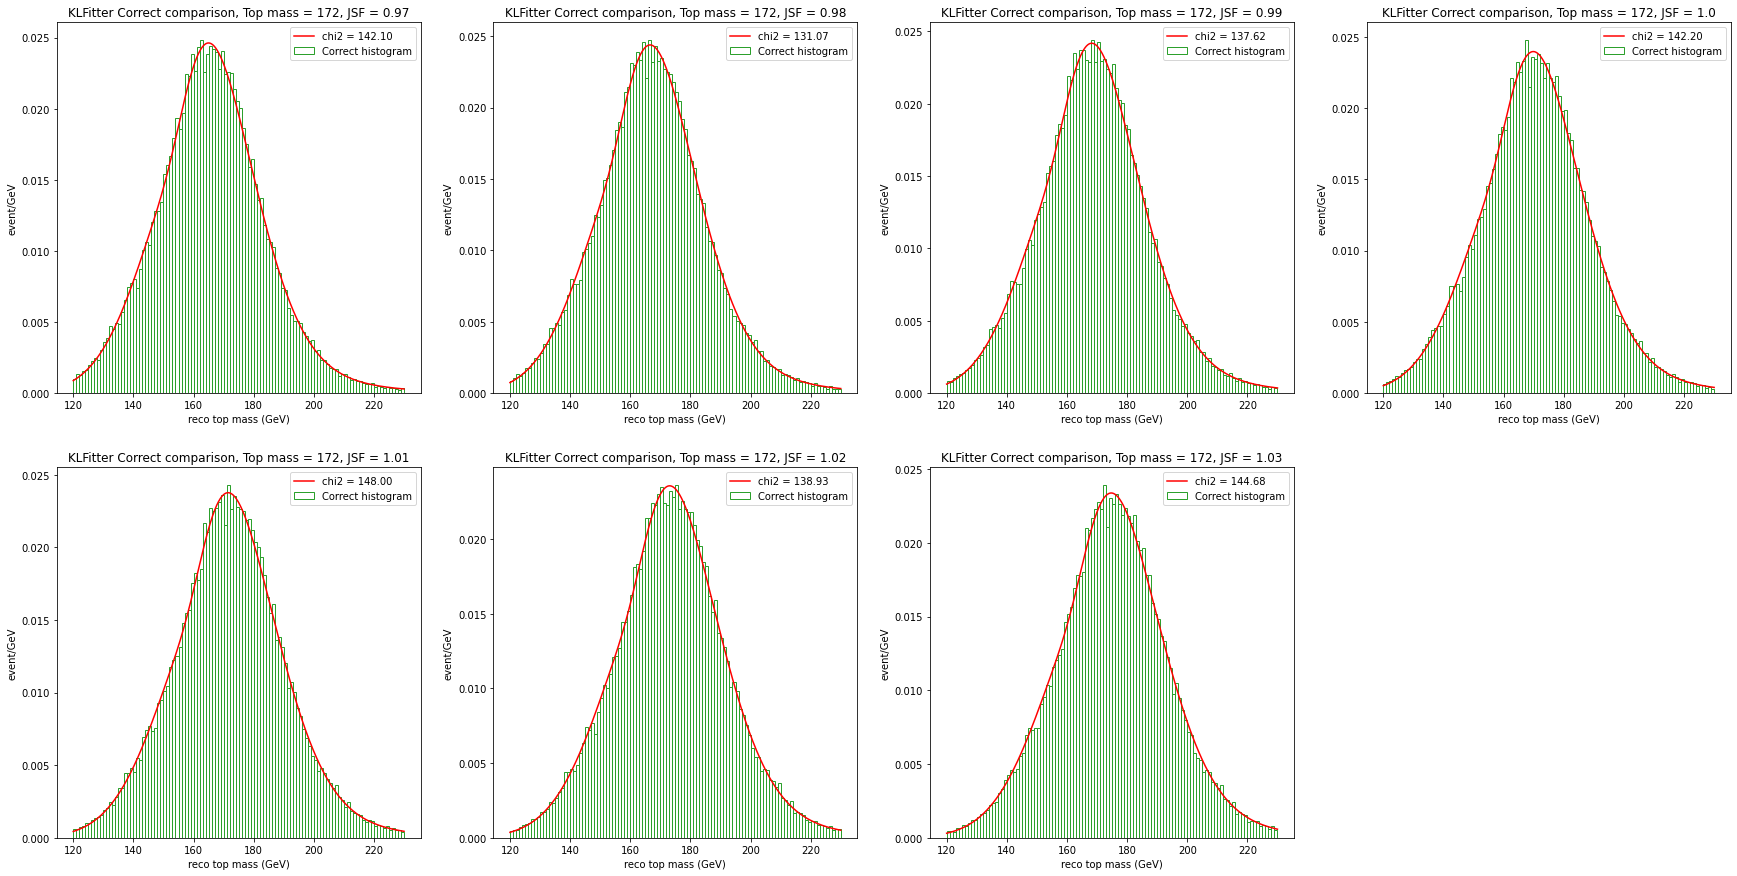

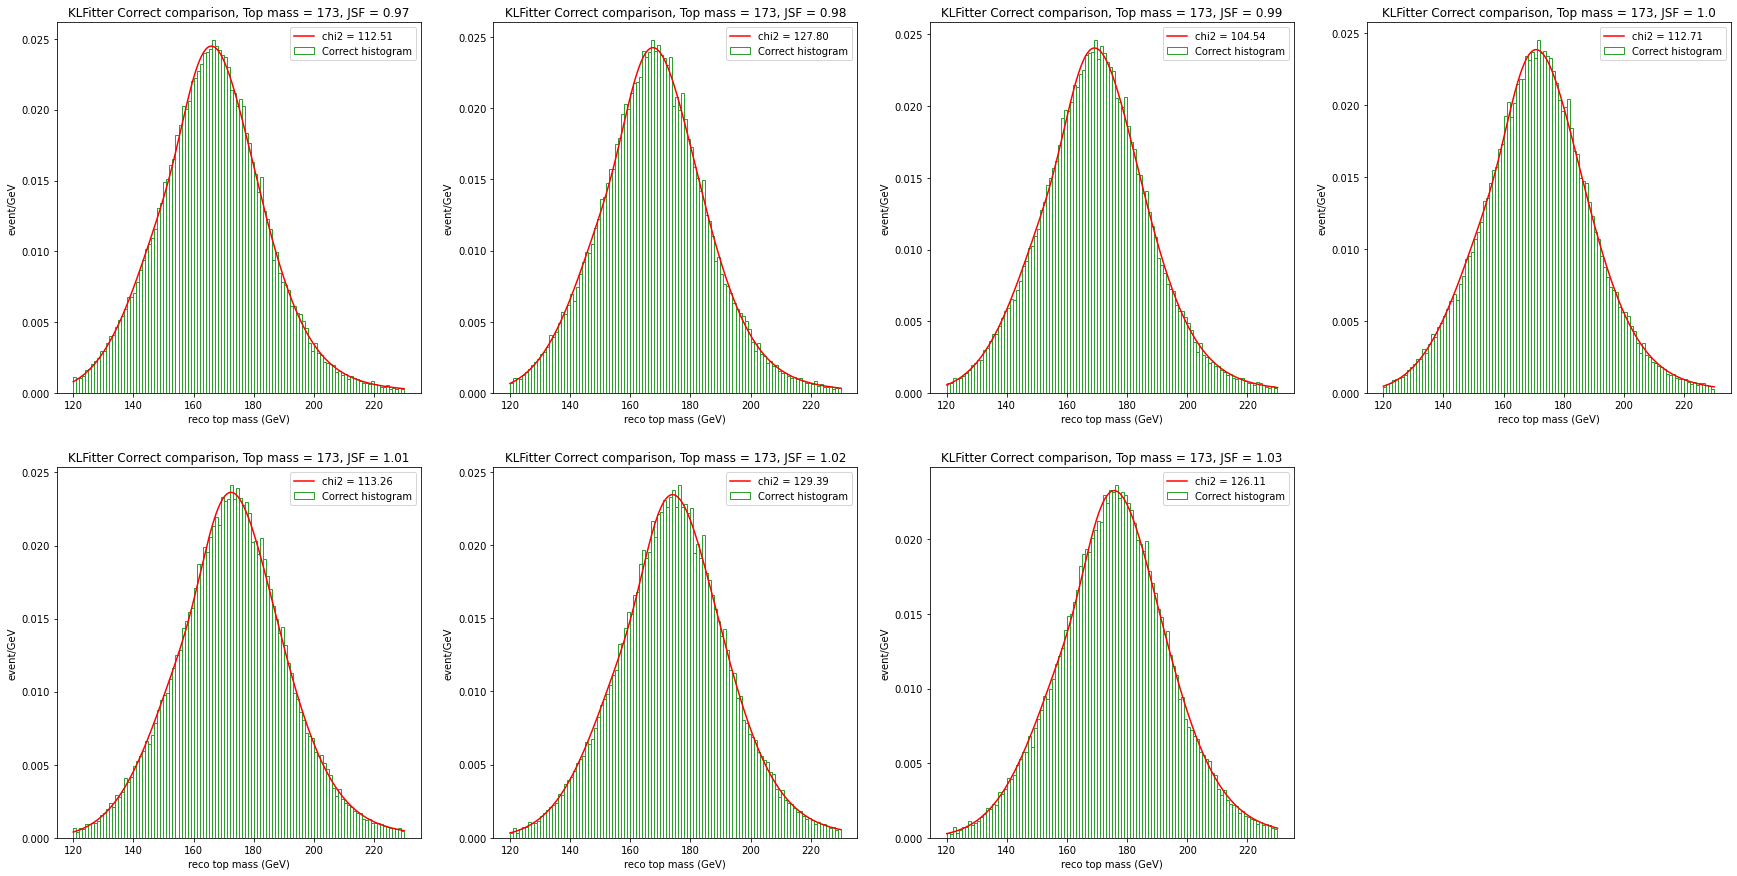

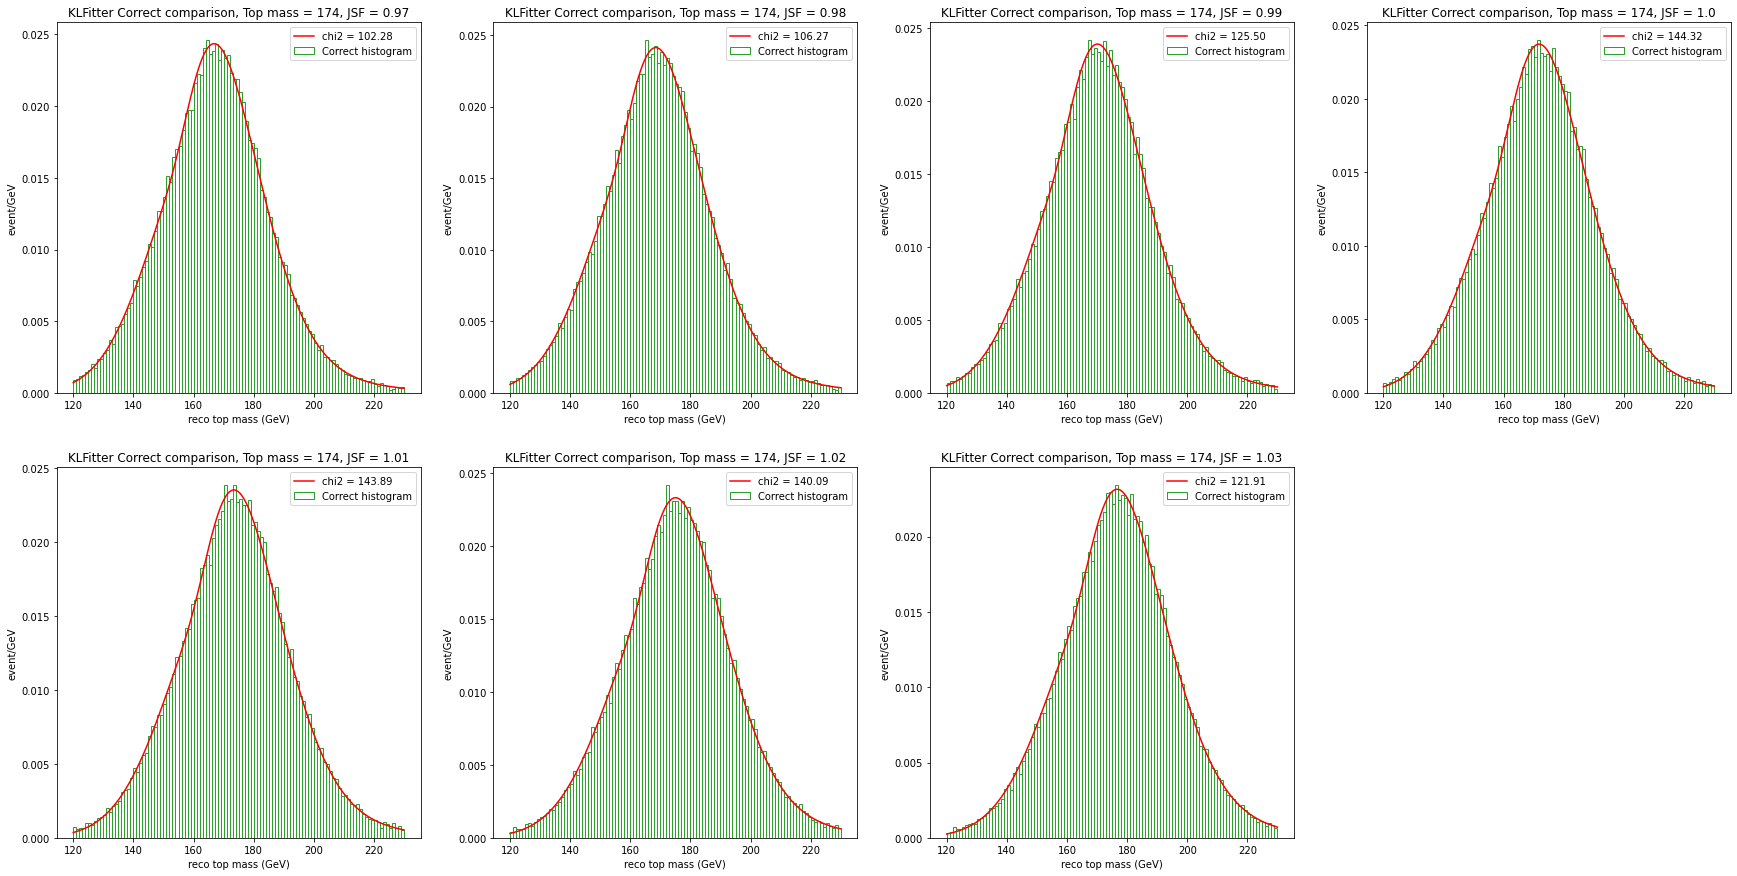

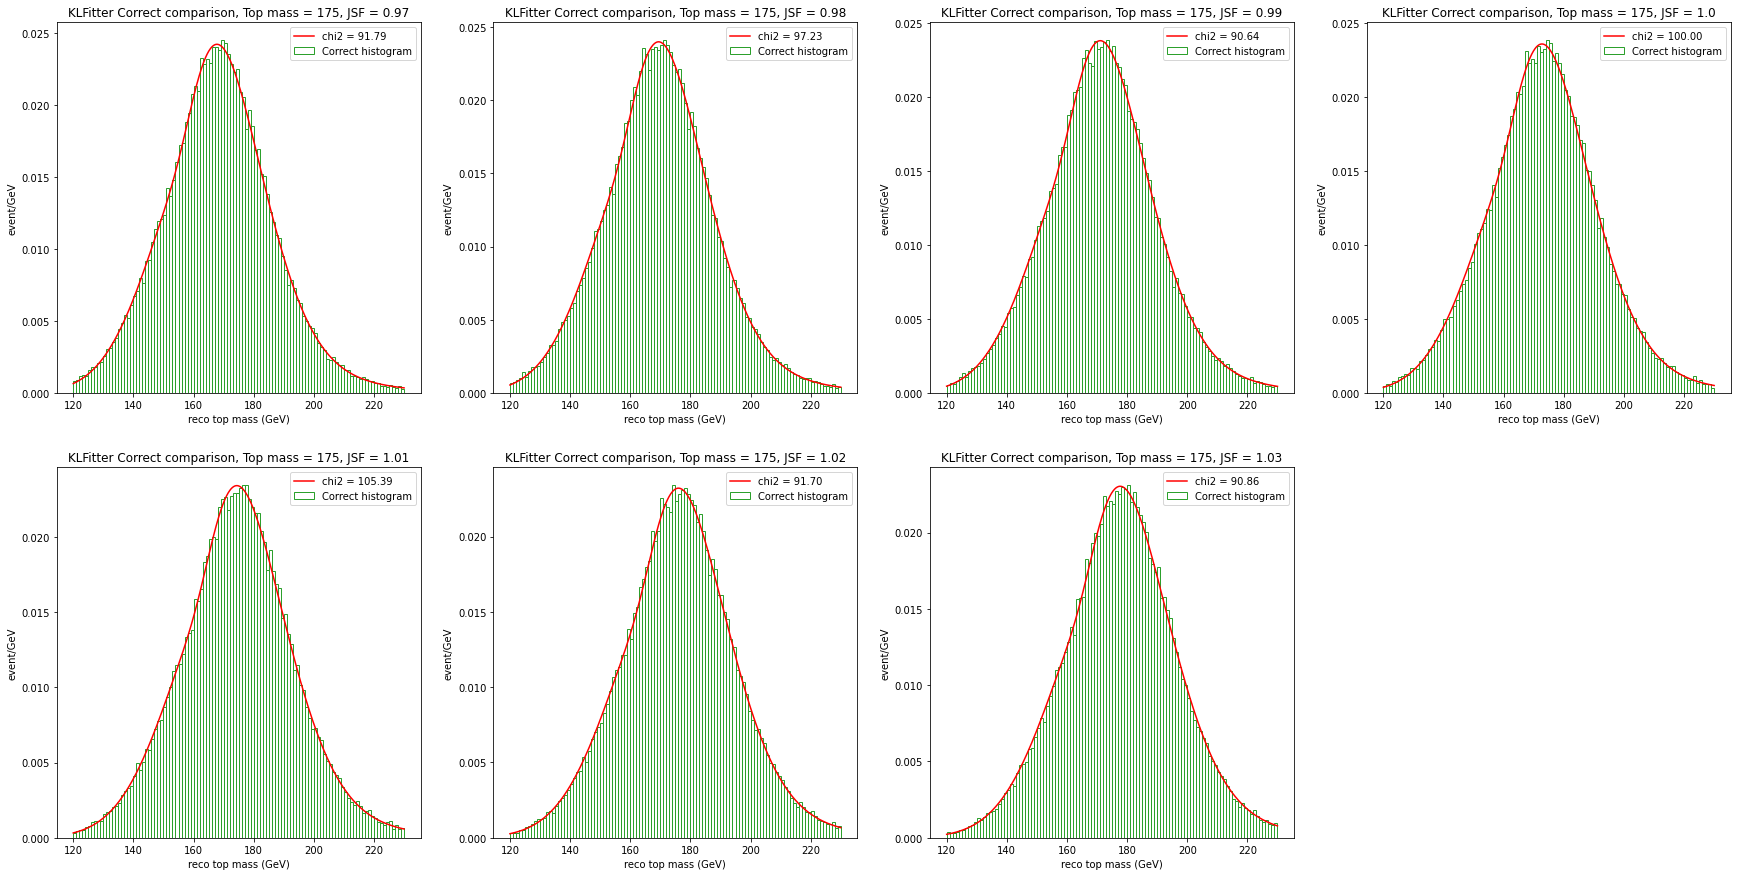

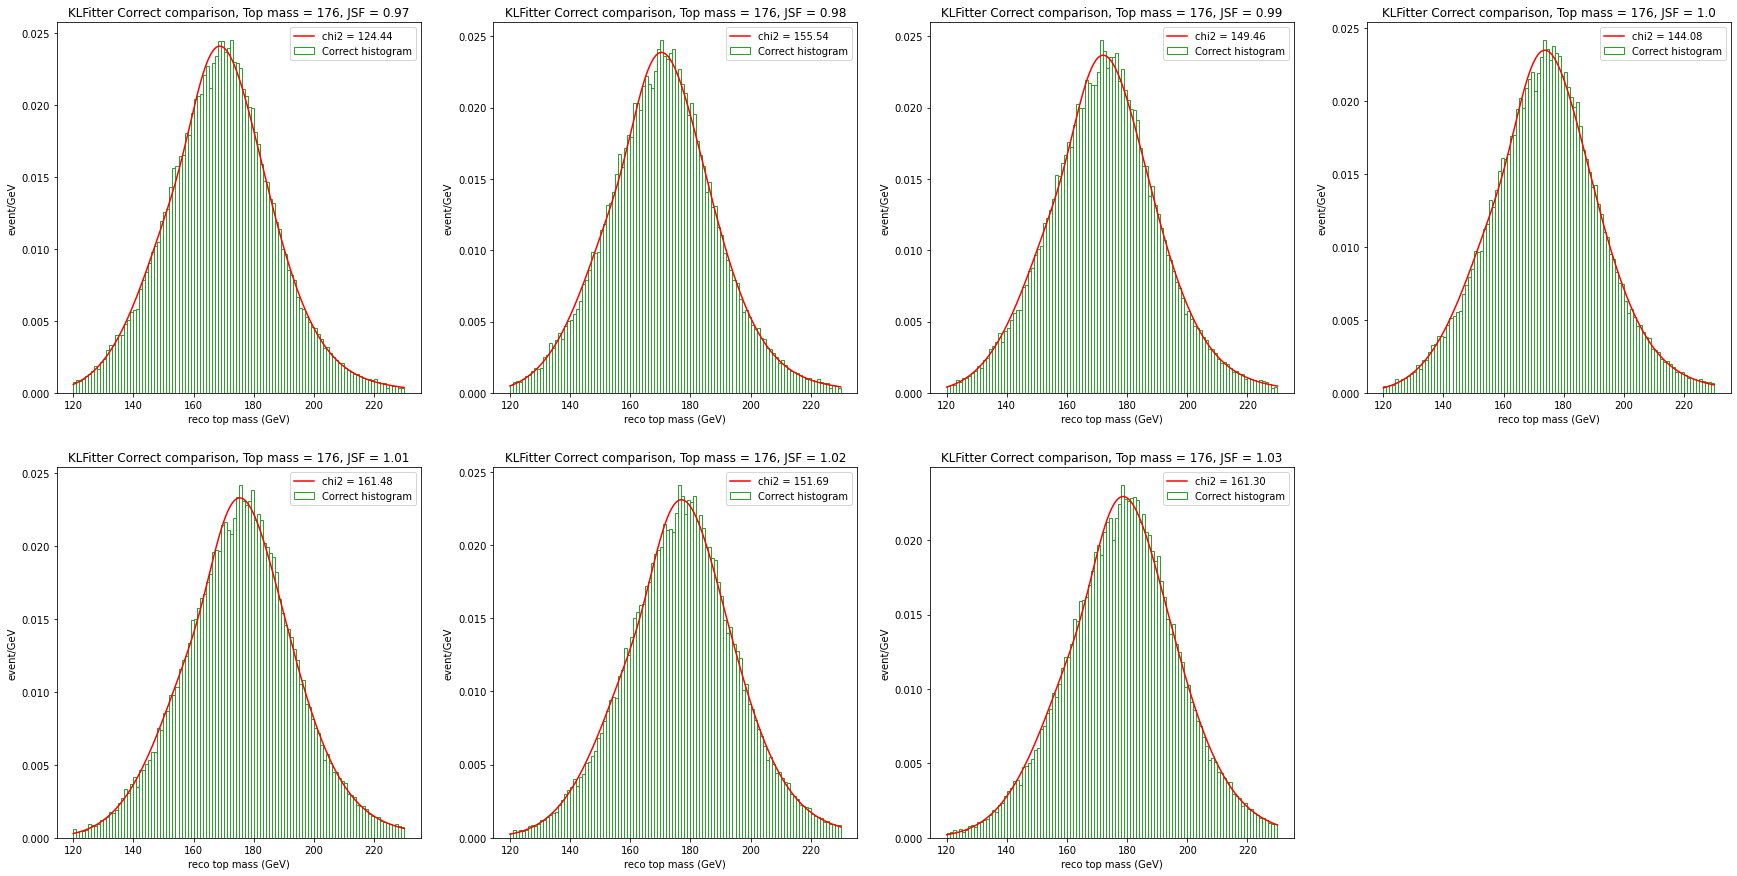

In [58]:
# Compare the KLFitter reconstructed top mass pdf to the original template
for state_i in states:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, likeli_klf_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
            plt.title(f'KLFitter {state_labels[state_i]} comparison, Top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc = 'upper right')
        plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_compare/KLFitter top {state_labels[state_i]} compare, True top mass = {m}.png', bbox_inches='tight')
        plt.show()


In [ ]:
# Compare the KLFitter reconstructed W mass pdf to the original template
for state_i in states:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], state_klf_dic[(m, JSF)] == state_i, likeli_klf_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_klf_W_dic[(state_i, j)]) for j in range(5)]
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.title(f'KLFitter {state_labels[state_i]} comparison, Top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc = 'upper right')
        plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_compare/KLFitter W {state_labels[state_i]} compare, True top mass = {m}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the SPAnet reconstructed top mass pdf to the original template
for state_i in states:
    for m in mass:
        plt.figure(figsize=(30,15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
            plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
            plt.title(f'SPAnet {state_labels[state_i]} comparison, Top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc = 'upper right')
        plt.savefig(f'plots_topmass_JSF/SPAnet_pdf_compare/SPAnet top {state_labels[state_i]} compare, True top mass = {m}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the SPAnet reconstructed W mass pdf to the original template
for state_i in states:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], state_spanet_dic[(m, JSF)] == state_i, likeli_spanet_dic[(m, JSF)]))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_spanet_W_dic[(state_i, j)]) for j in range(5)]
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.title(f'SPAnet W {state_labels[state_i]} comparison, Top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc = 'upper right')
        plt.savefig(f'plots_topmass_JSF/SPAnet_pdf_compare/SPAnet W {state_labels[state_i]} compare, True top mass = {m}.png', bbox_inches='tight')
        plt.close()


In [ ]:
# Compare the true reconstructed top mass pdf to the original template
state_i = 2
for m in mass:
    plt.figure(figsize=(30,15))
    for i, JSF in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        fit_target = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == 2))]
        hist, _ = np.histogram(fit_target, bins=top_bins, density=True)
        popt = [linear_linear((m, JSF), *pdf_perfect_top_dic[(state_i, j)]) for j in range(5)]
        plt.bar(top_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
        plt.plot(top_bins_dense, langau_norm(top_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_top(fit_target, langau_norm(top_bins_mid, *popt))))
        plt.title(f'Perfect comparison, Top mass = {m}, JSF = {JSF}')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc = 'upper right')
    plt.savefig(f'plots_topmass_JSF/Perfect_pdf_compare/Perfect top compare, True top mass = {m}.png', bbox_inches='tight')
    plt.close()

In [ ]:
# Compare the true reconstructed W mass pdf to the original template
for state_i in [2]:
    for m in mass:
        plt.figure(figsize=(30, 15))
        for i, JSF in enumerate(JSF_arr):
            plt.subplot(2, 4, i+1)
            fit_target = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == 2))]
            hist, _ = np.histogram(fit_target, bins=W_bins, density=True)
            popt = [linear_linear((m, JSF), *pdf_perfect_W_dic[(state_i, j)]) for j in range(5)]
            plt.bar(W_bins_mid, hist, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            plt.plot(W_bins_dense, two_gau_norm(W_bins_dense, *popt), c='r', label='chi2 = {:.2f}'.format(chi2_pdf_W(fit_target, two_gau_norm(W_bins_mid, *popt))))
            plt.title(f'Perfect comparison, Top mass = {m}, JSF = {JSF}')
            plt.xlabel('reco top mass (GeV)')
            plt.ylabel('event/GeV')
            plt.legend(loc = 'upper right')
        plt.savefig(f'plots_topmass_JSF/Perfect_pdf_compare/Perfect W compare, True top mass = {m}.png', bbox_inches='tight')
        plt.close()

In [ ]:
def klf_top_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_klf_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_klf_popt[state_i])
    return hist

def klf_W_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_klf_W_dic[(state_i, j)]) for j in range(5)]
        hist += two_gau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_klf_popt[state_i])
    return hist

def spanet_top_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_spanet_top_dic[(state_i, j)]) for j in range(5)]
        hist += langau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_spanet_popt[state_i])
    return hist

def spanet_W_pdf_func(x, m, JSF):
    hist = [0]*len(x)
    for state_i in states:
        popt = [linear_linear((m, JSF), *pdf_spanet_W_dic[(state_i, j)]) for j in range(5)]
        hist += two_gau_norm(x, *popt)*linear_parabola([m, JSF], *fpdf_spanet_popt[state_i])
    return hist

def perfect_top_pdf_func(x, m, JSF):
    popt = [linear_linear((m, JSF), *pdf_perfect_top_dic[(2, j)]) for j in range(5)]
    return langau_norm(x, *popt)

def perfect_W_pdf_func(x, m, JSF):
    popt = [linear_linear((m, JSF), *pdf_perfect_W_dic[(2, j)]) for j in range(5)]
    return two_gau_norm(x, *popt)

def chi2_klf_arr_func(m, JSF):
    return -2*np.sum(n1*np.log(klf_top_pdf_func(top_bins_mid, m, JSF)*sum(n1)*bins_width)) -2*np.sum(n2*np.log(klf_W_pdf_func(W_bins_mid, m, JSF)*sum(n2)*bins_width))

def chi2_spanet_arr_func(m, JSF):
    return -2*np.sum(n1*np.log(spanet_top_pdf_func(top_bins_mid, m, JSF)*sum(n1)*bins_width)) -2*np.sum(n2*np.log(spanet_W_pdf_func(W_bins_mid, m, JSF)*sum(n2)*bins_width))

def chi2_perfect_arr_func(m, JSF):
    return -2*np.sum(n1*np.log(perfect_top_pdf_func(top_bins_mid, m, JSF)*sum(n1)*bins_width)) -2*np.sum(n2*np.log(perfect_W_pdf_func(W_bins_mid, m, JSF)*sum(n2)*bins_width))


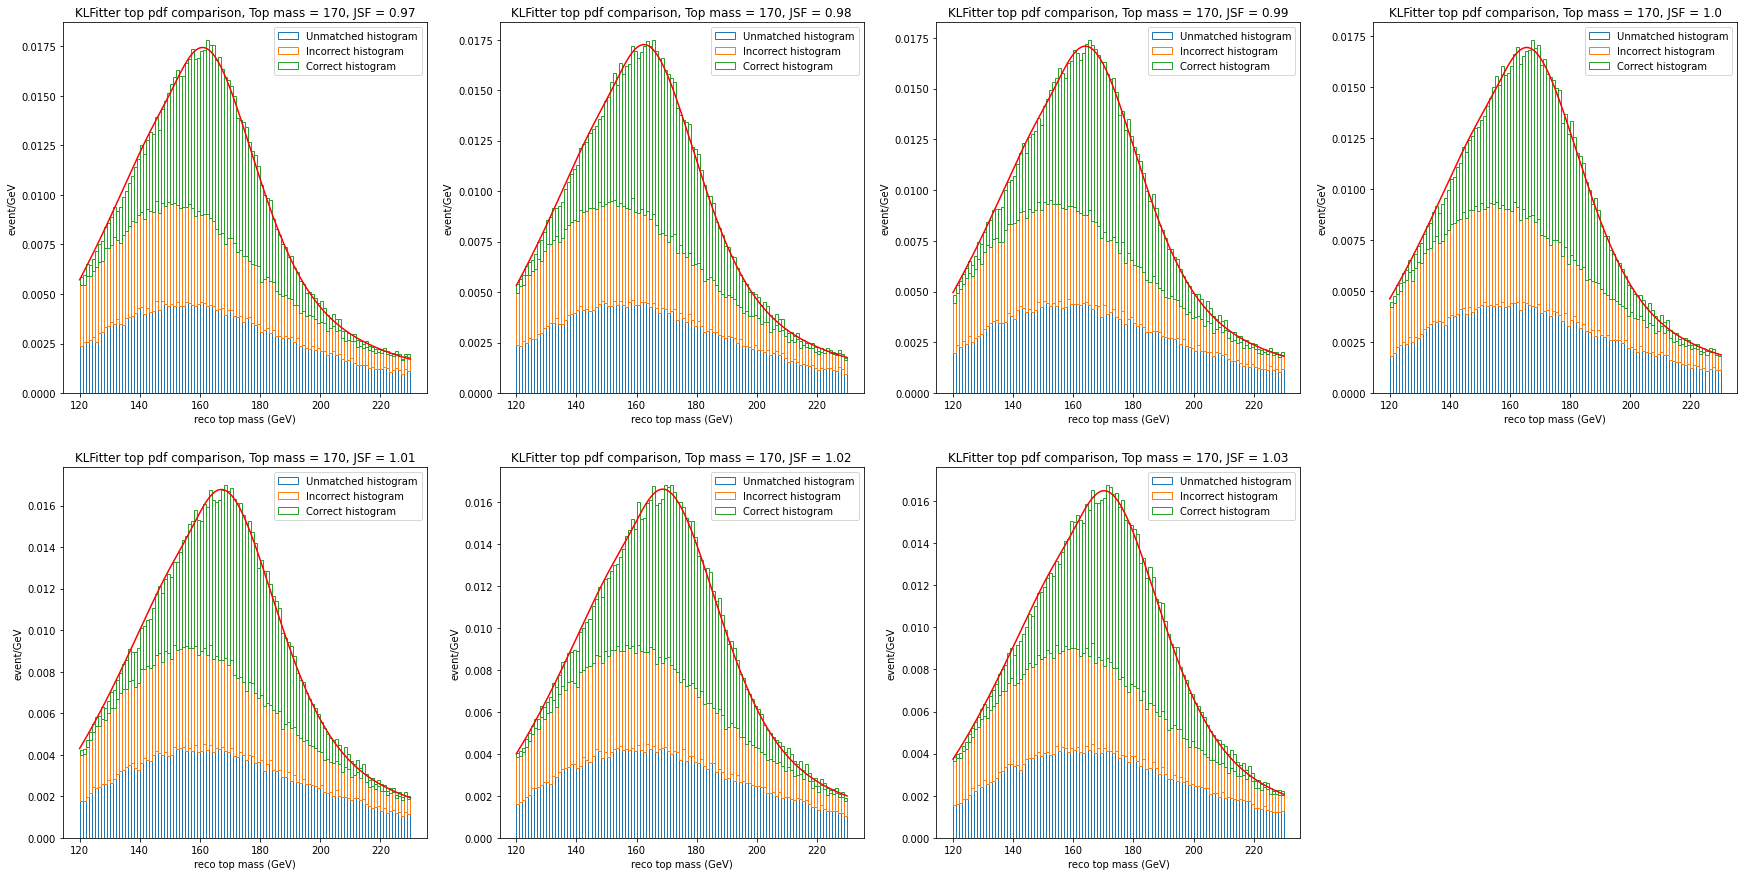

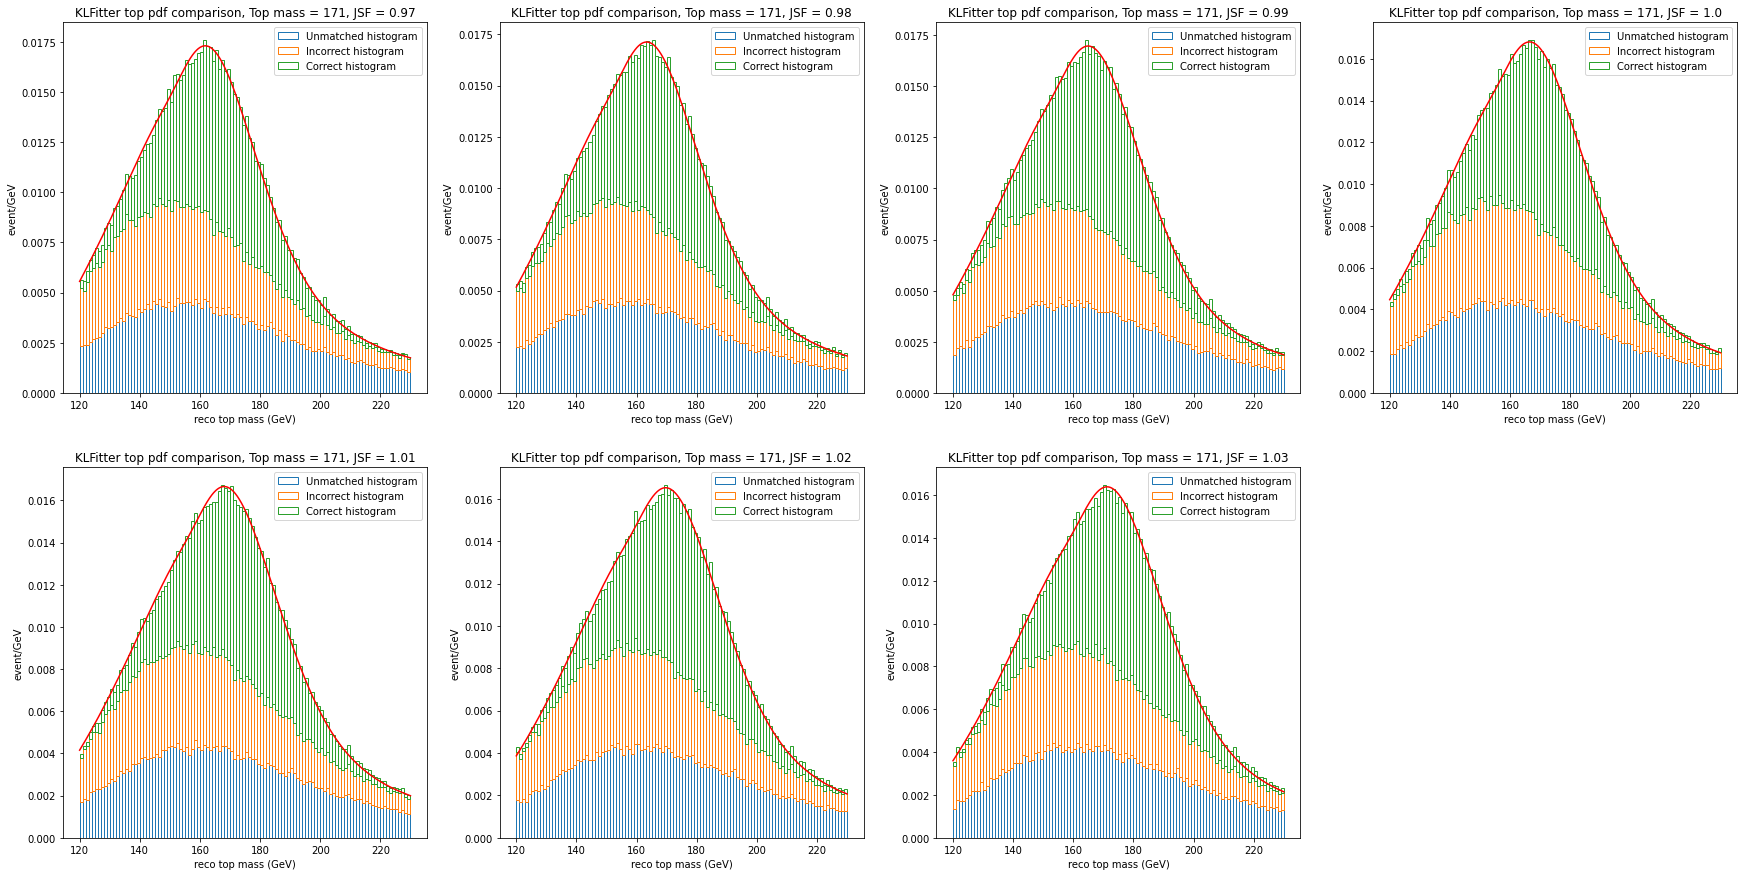

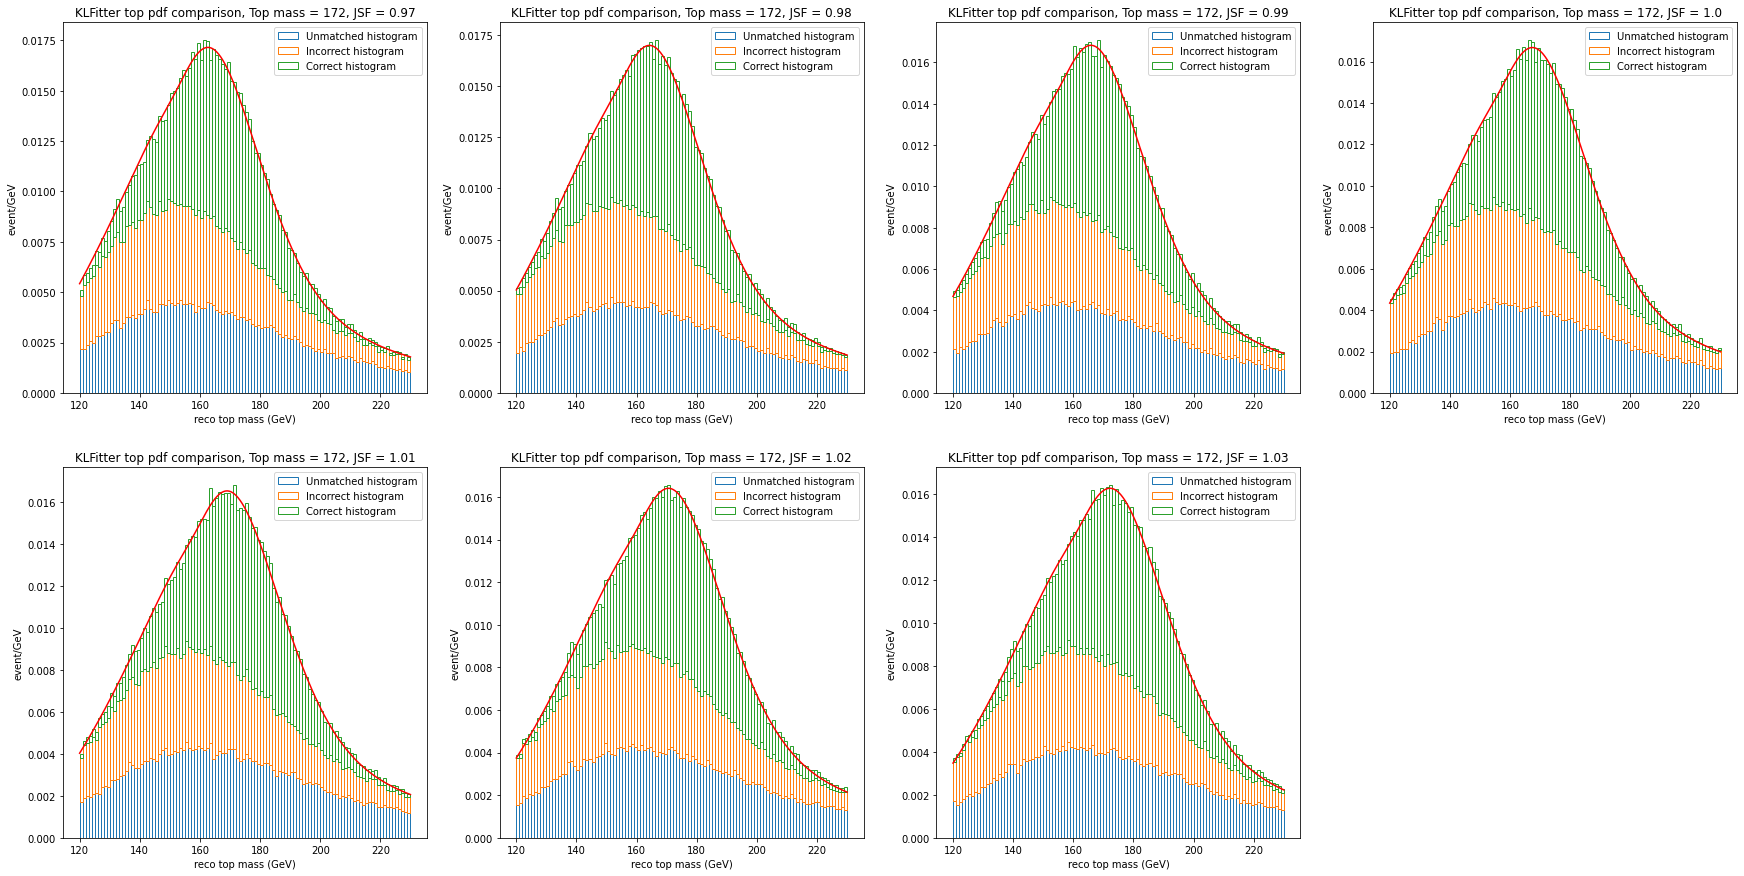

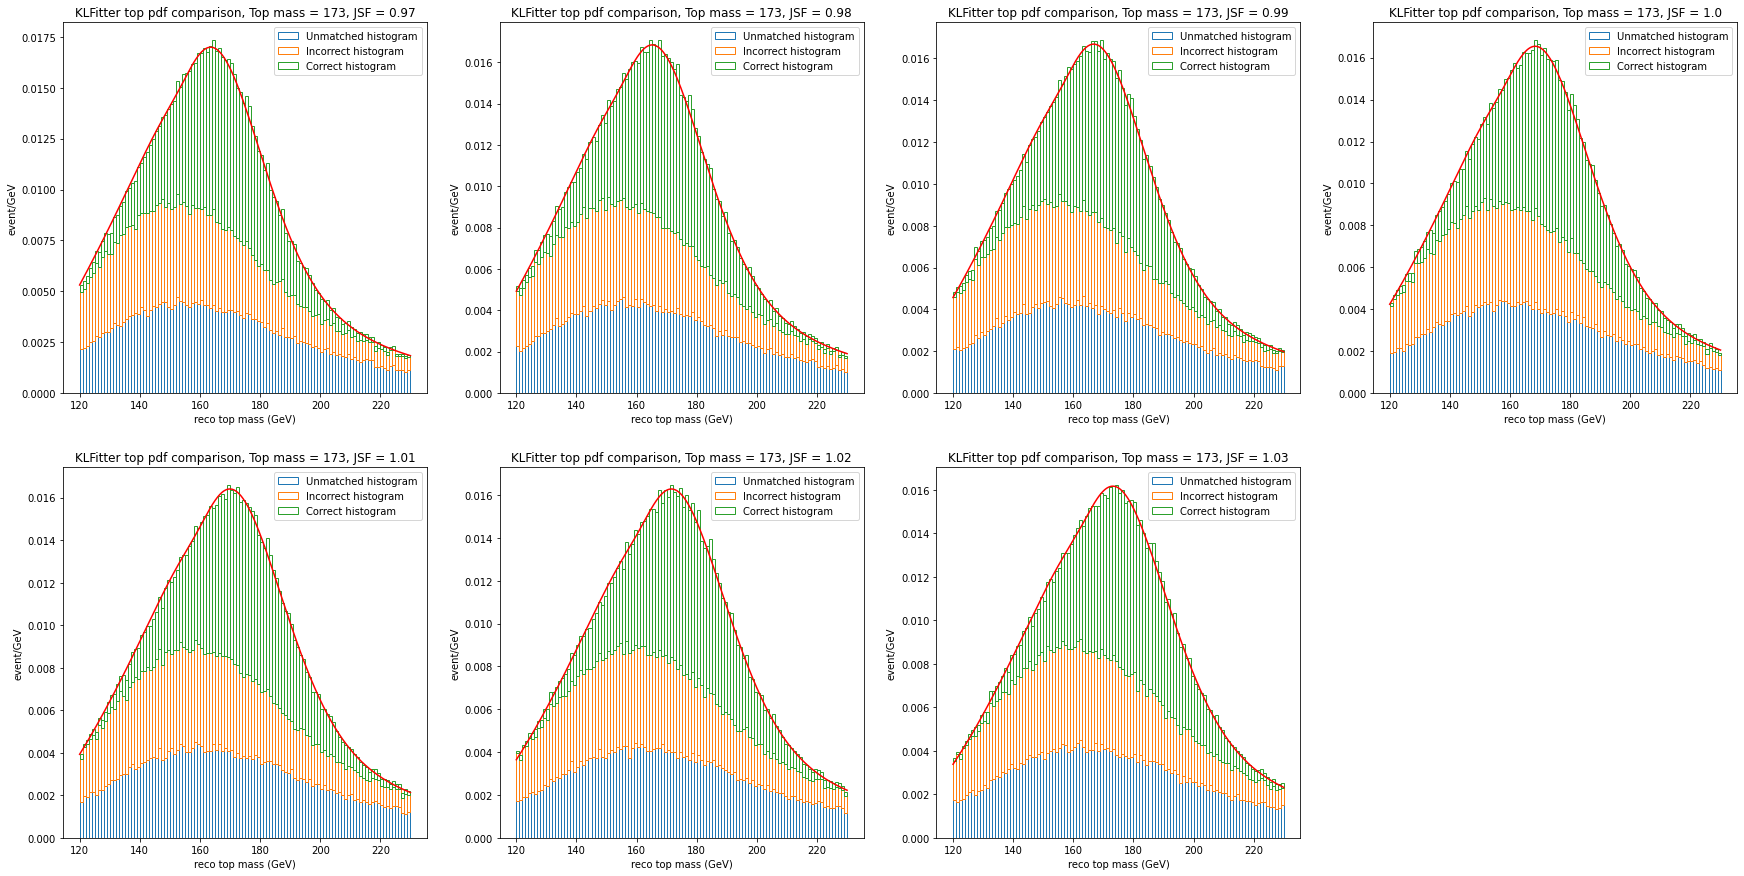

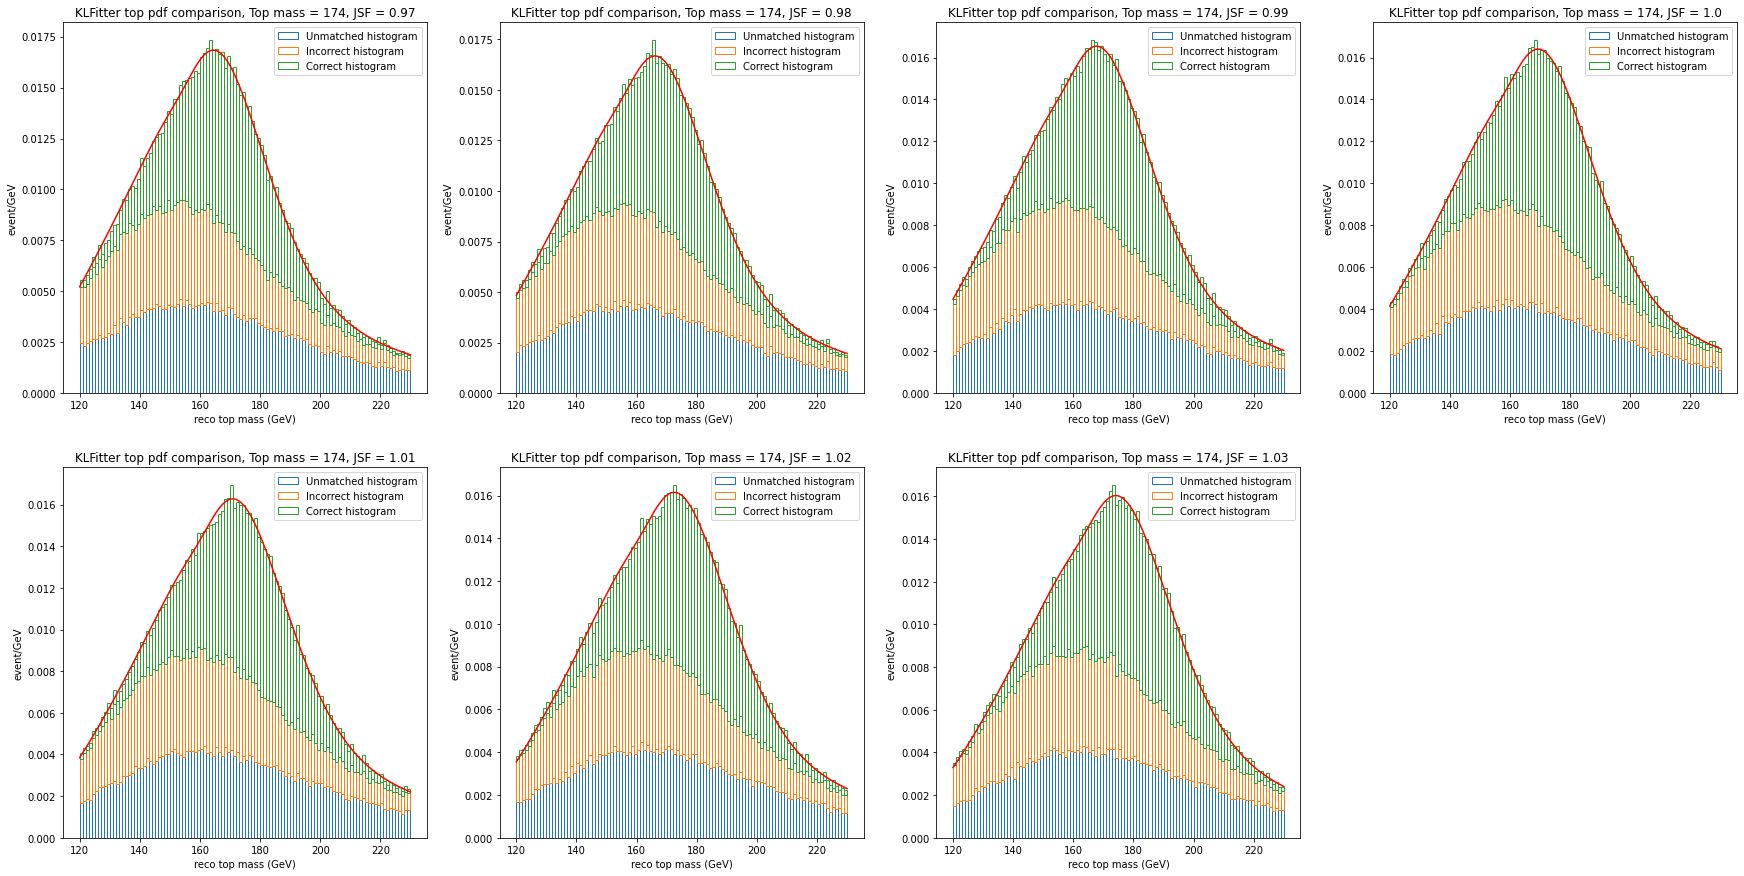

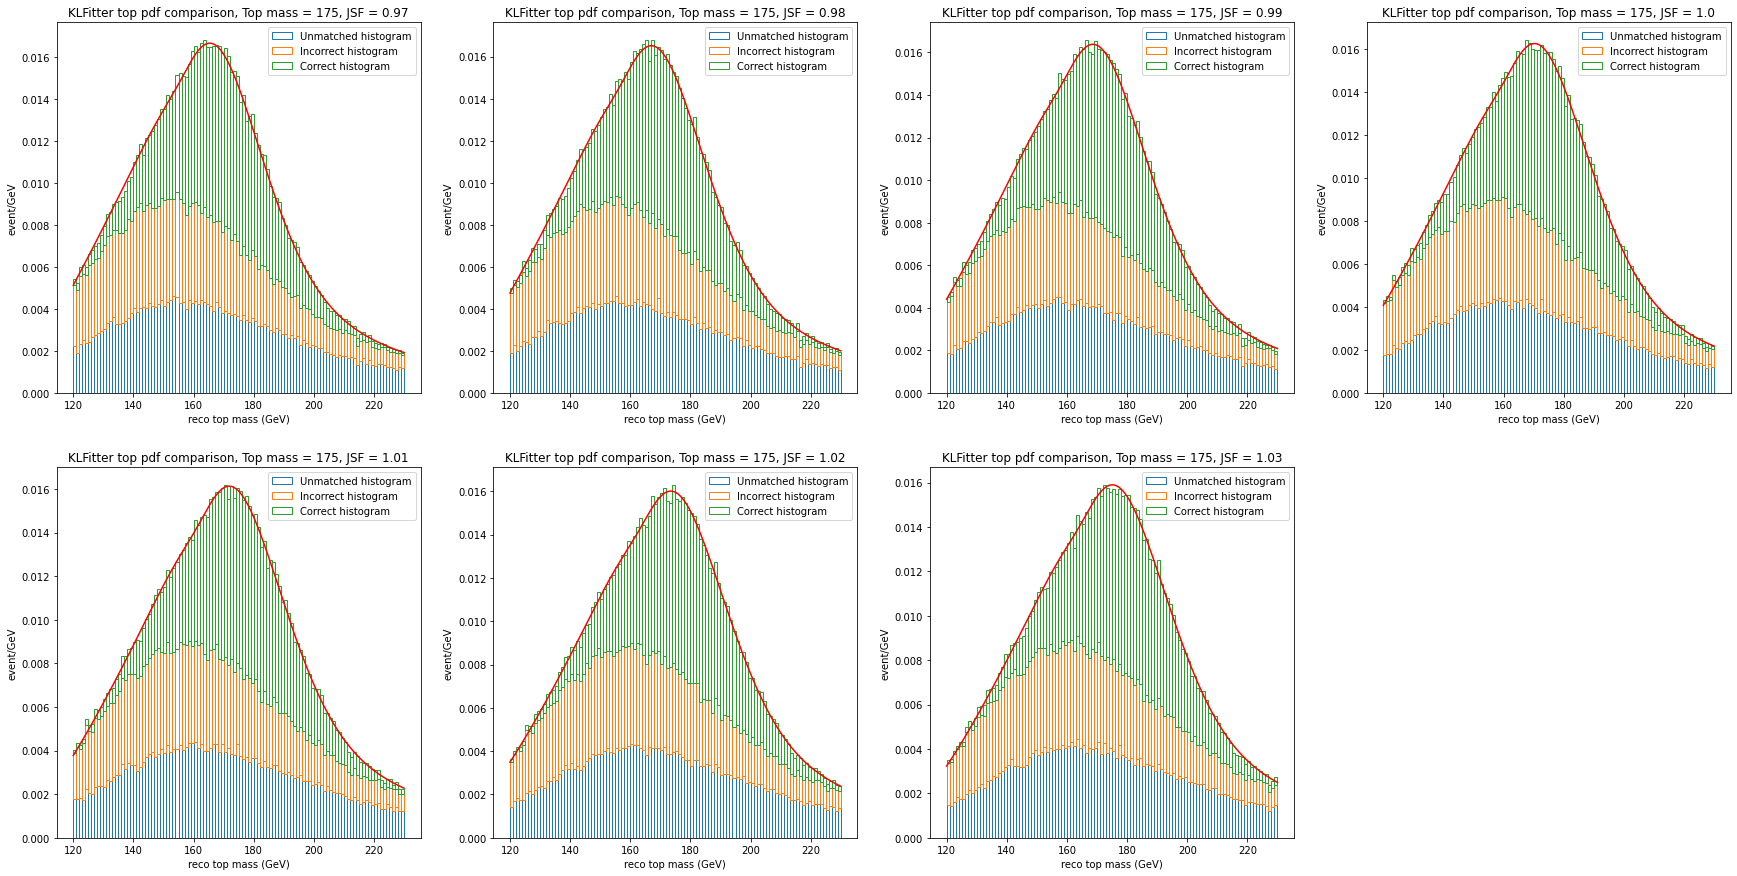

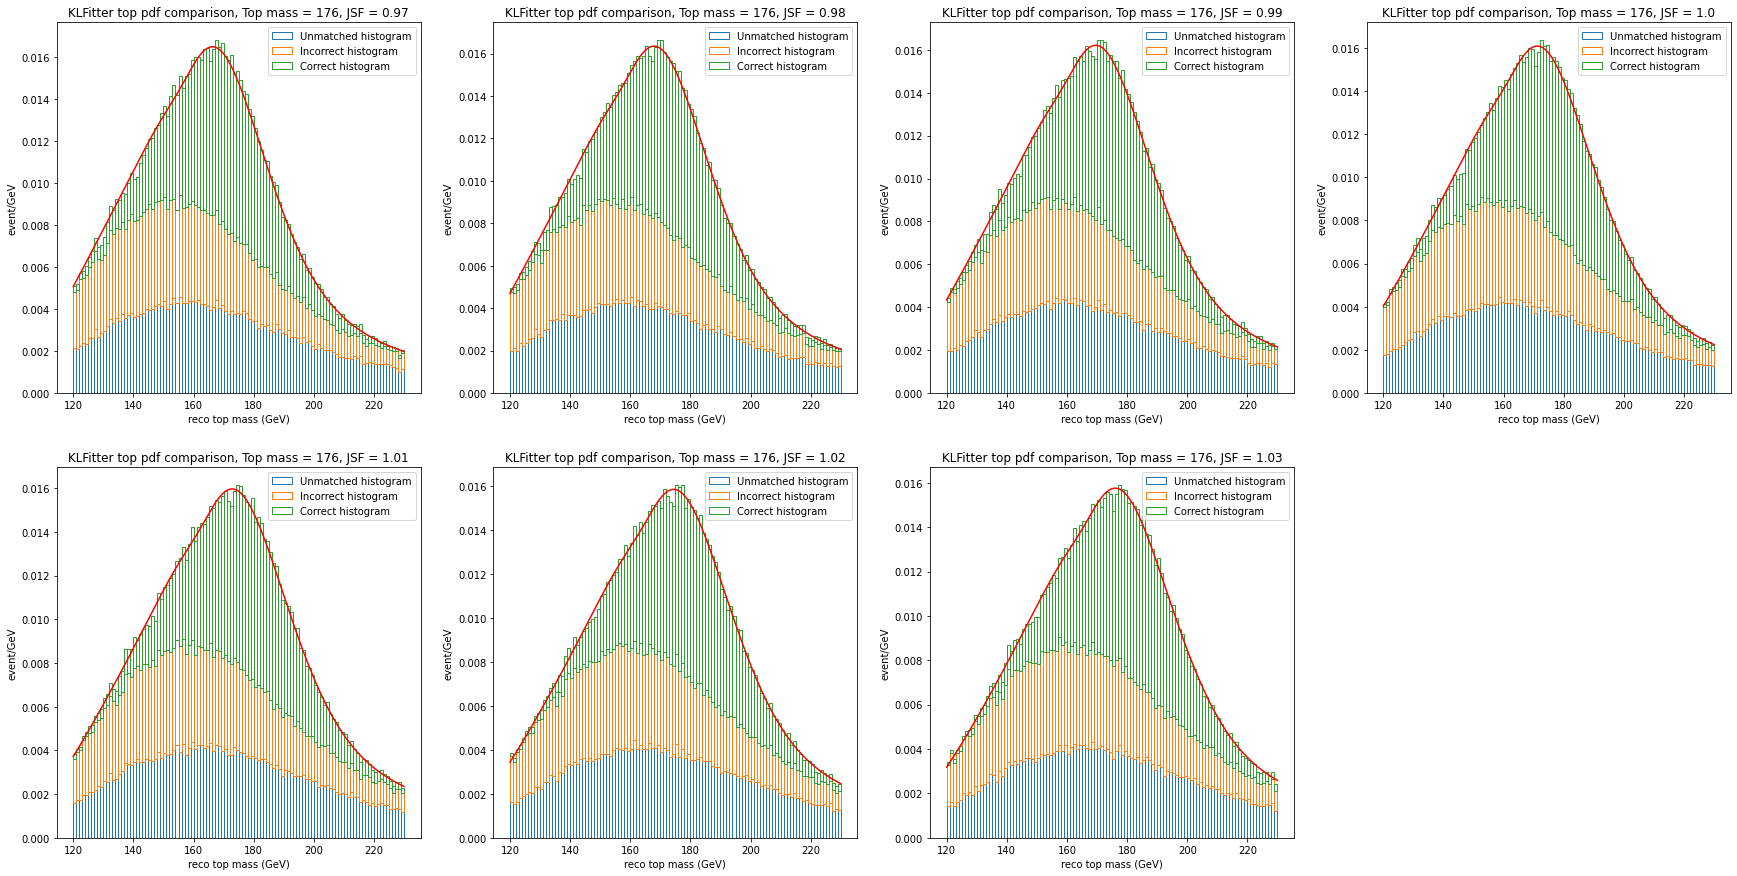

In [74]:
# Compare the klfitter top pdf to the template histogram
for m in mass:
    plt.figure(figsize=(30, 15))
    for i, JSF in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        target = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]        
        h, tot = [0]*(len(top_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(reco_klf_dic[(m, JSF)][np.logical_and.reduce((state_klf_dic[(m, JSF)] == state_i, cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))], bins=top_bins)
            plt.bar(top_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(top_bins_dense, klf_top_pdf_func(top_bins_dense, m, JSF), c='r')
        plt.title(f'KLFitter top pdf comparison, Top mass = {m}, JSF = {JSF}')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_compare/KLFitter top pdf compare, True top mass = {m}.png', bbox_inches='tight')
    plt.show()
    

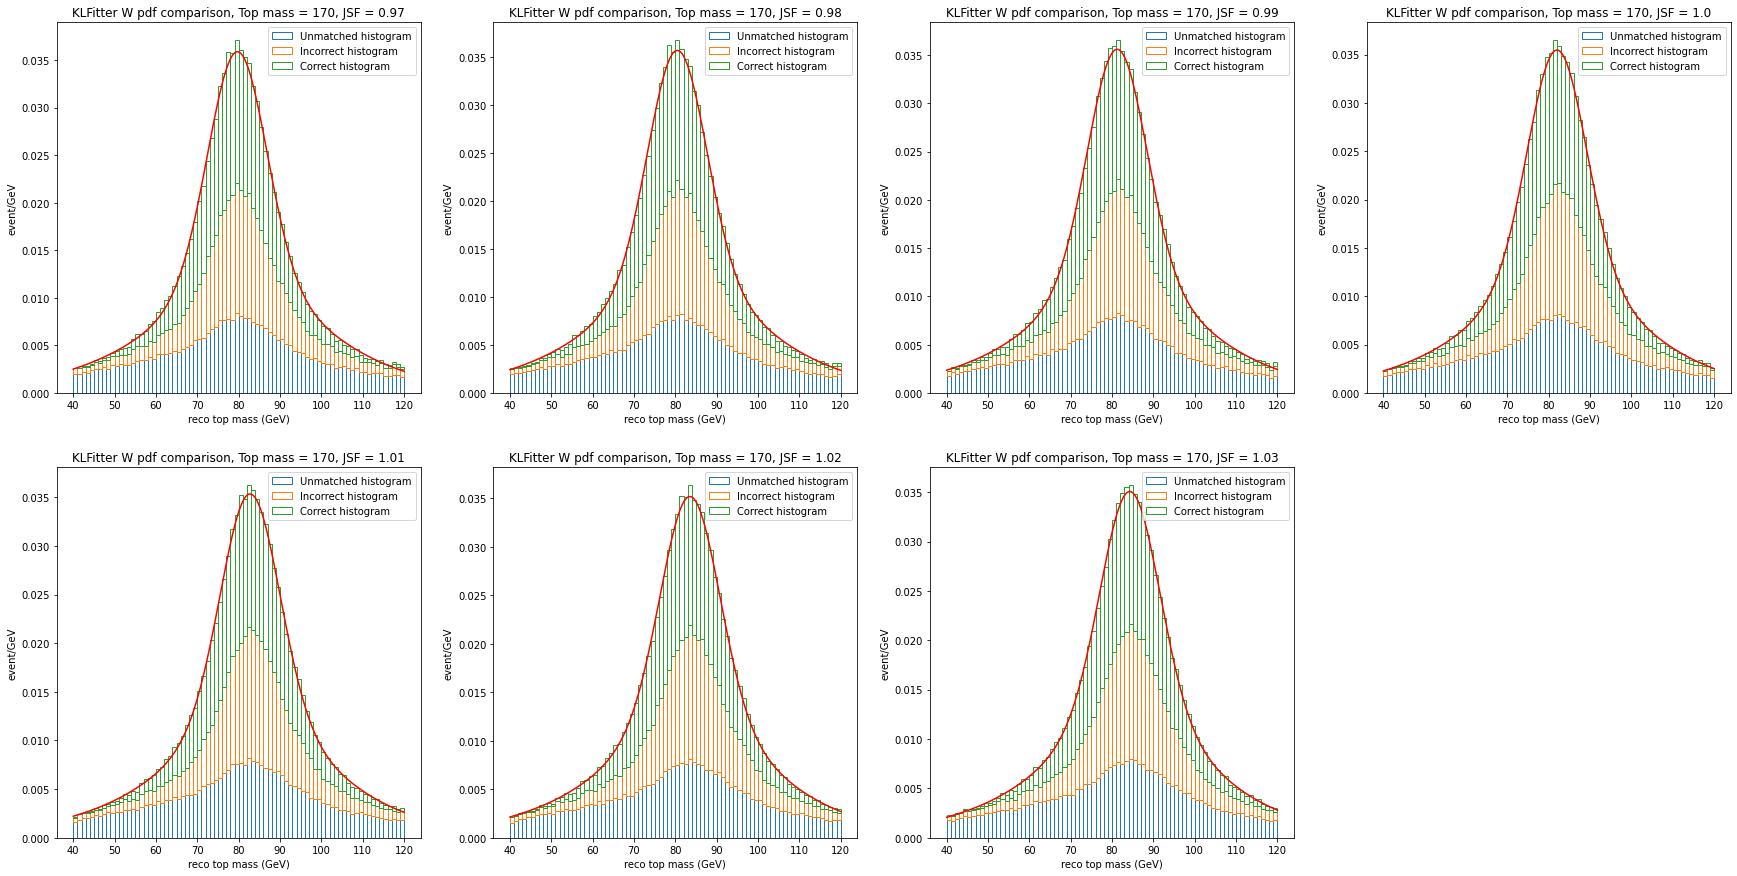

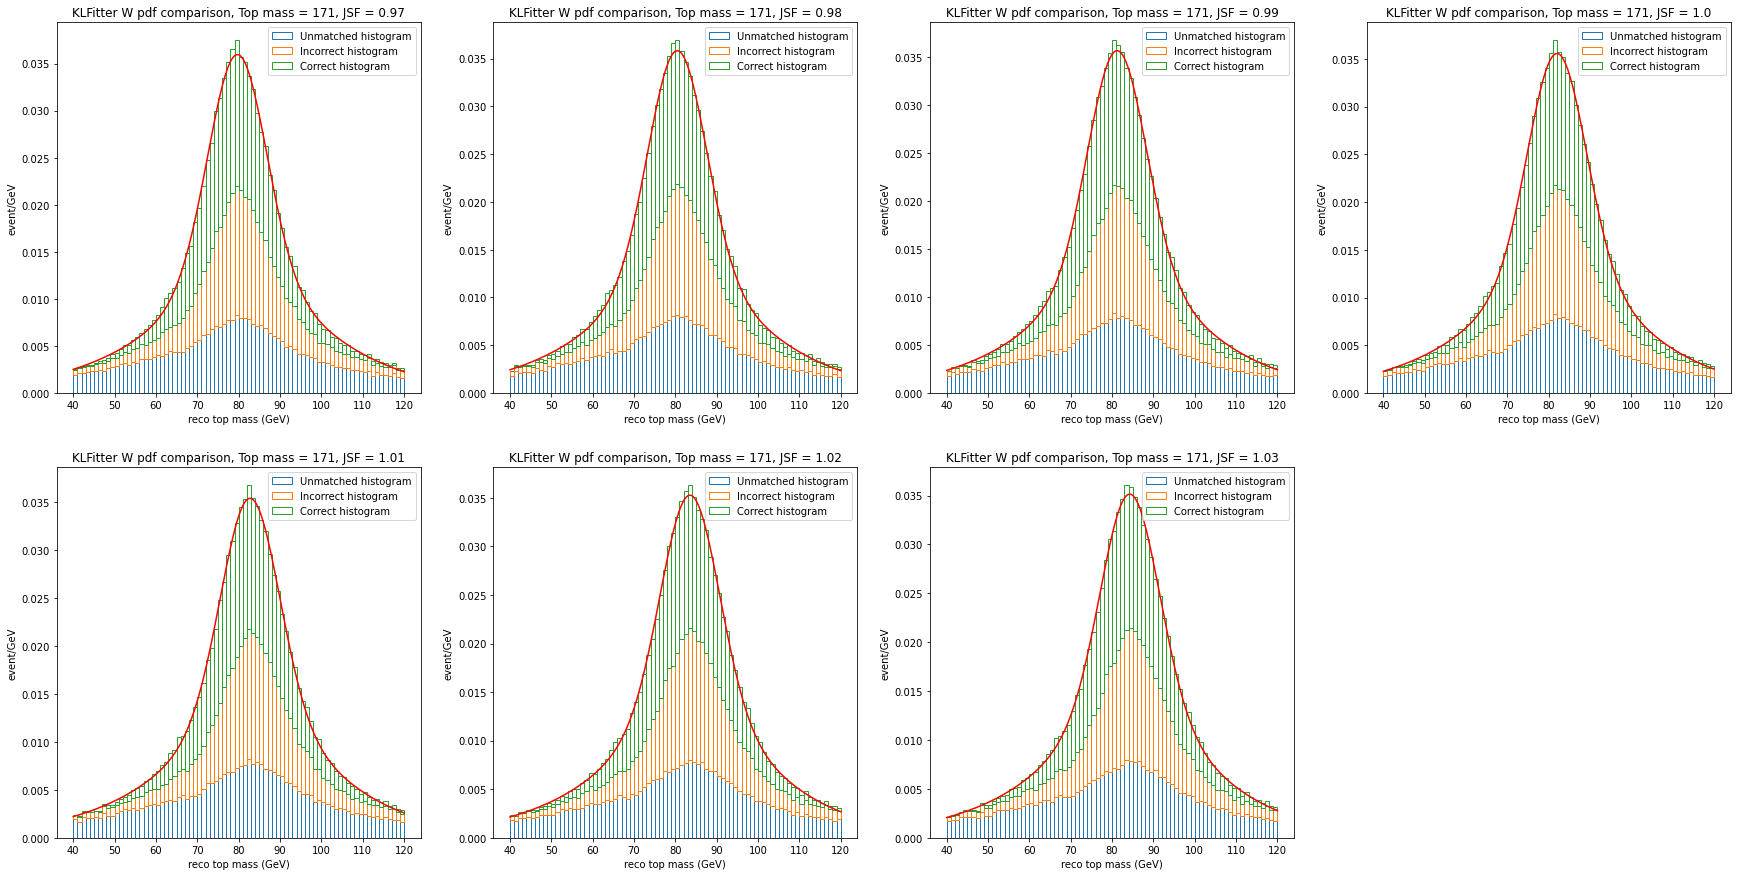

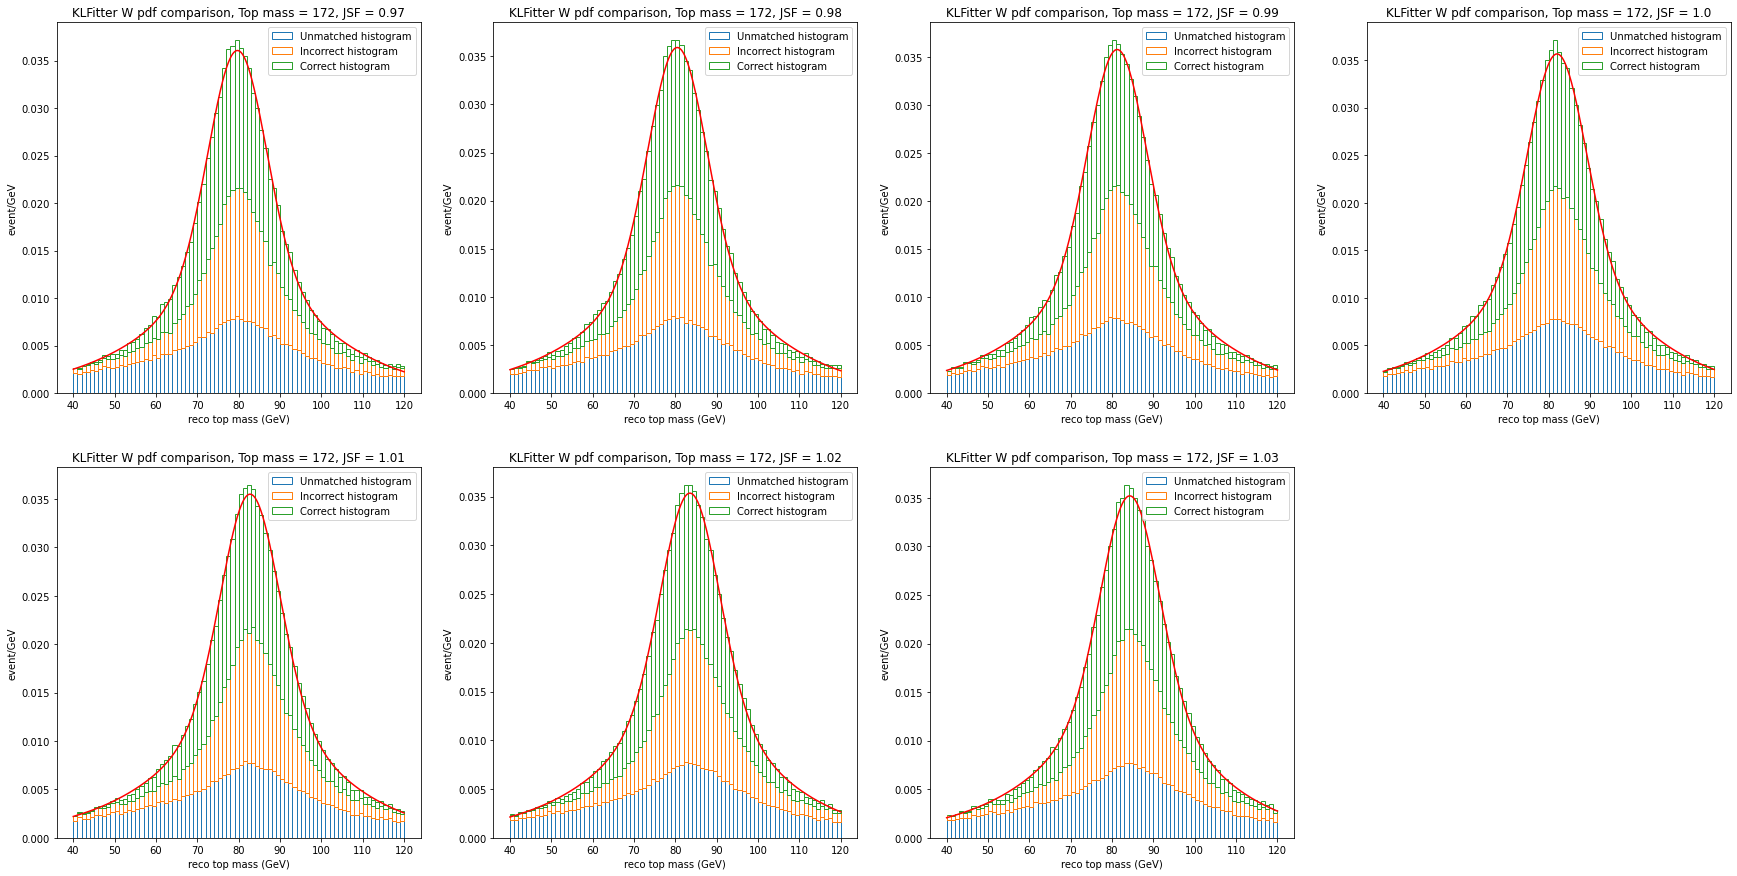

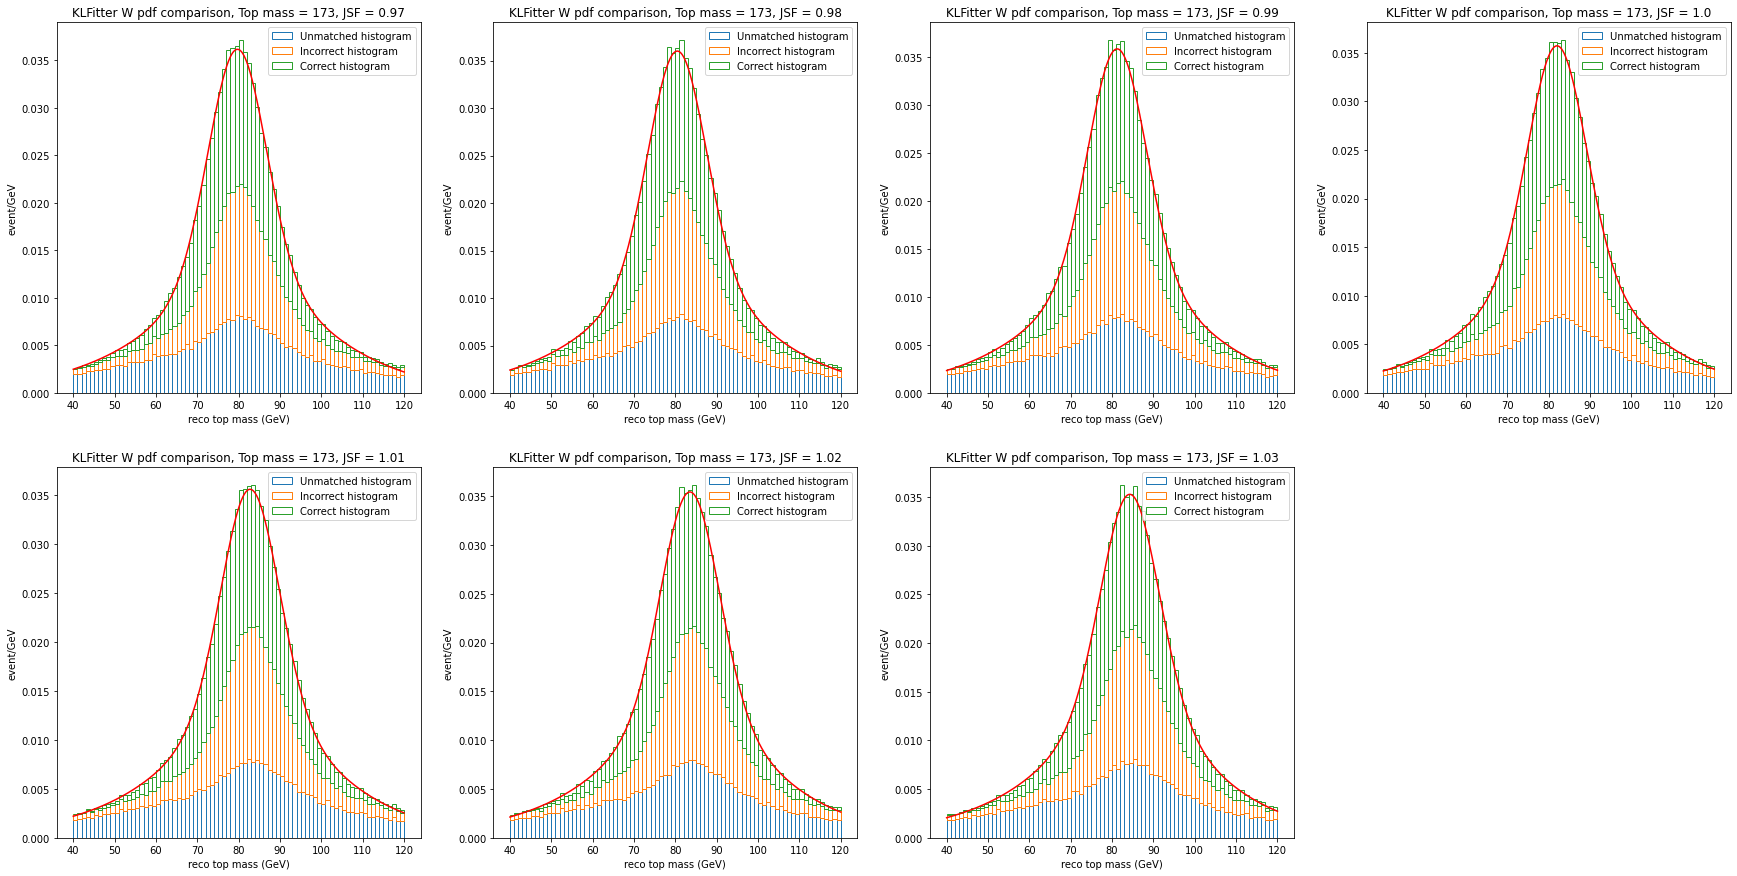

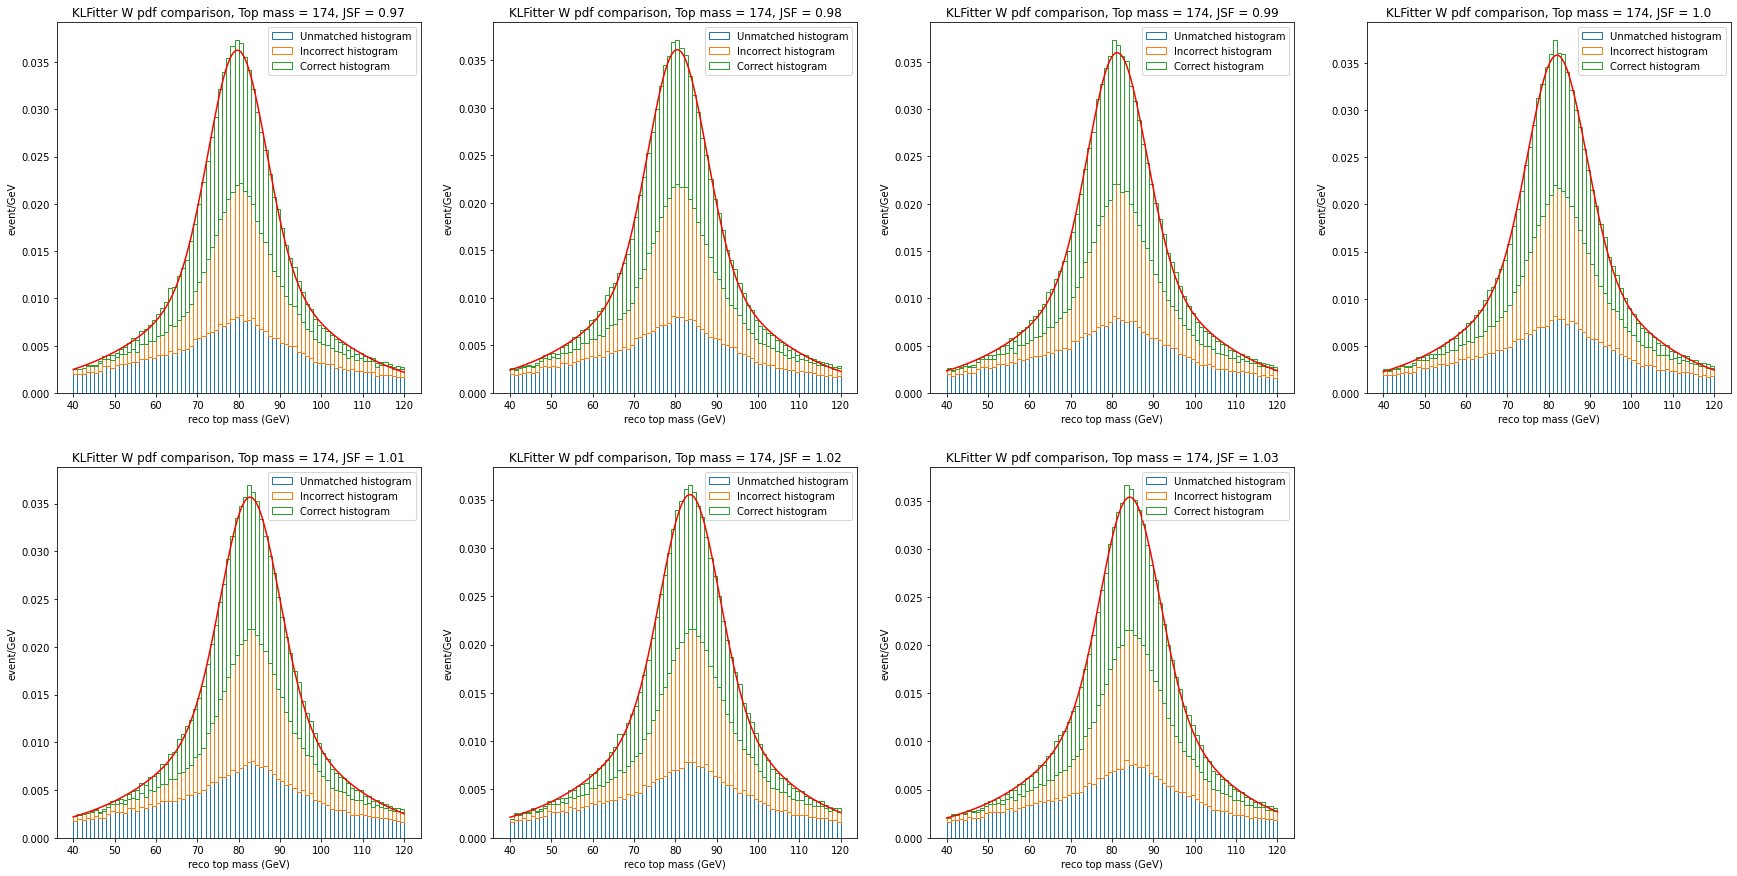

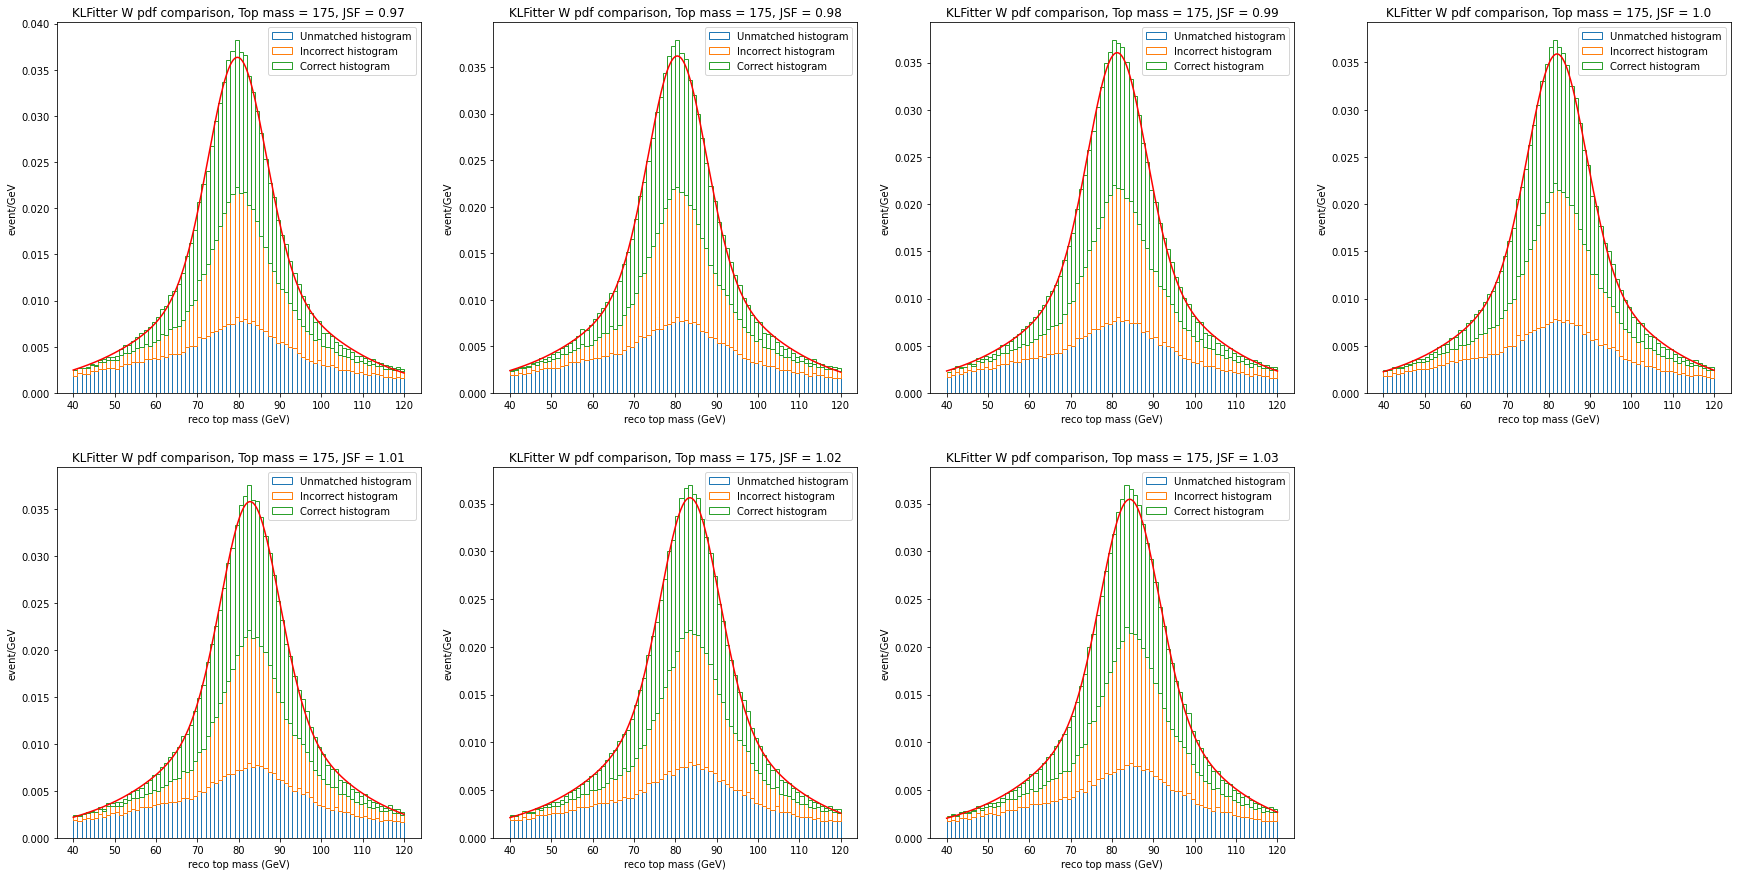

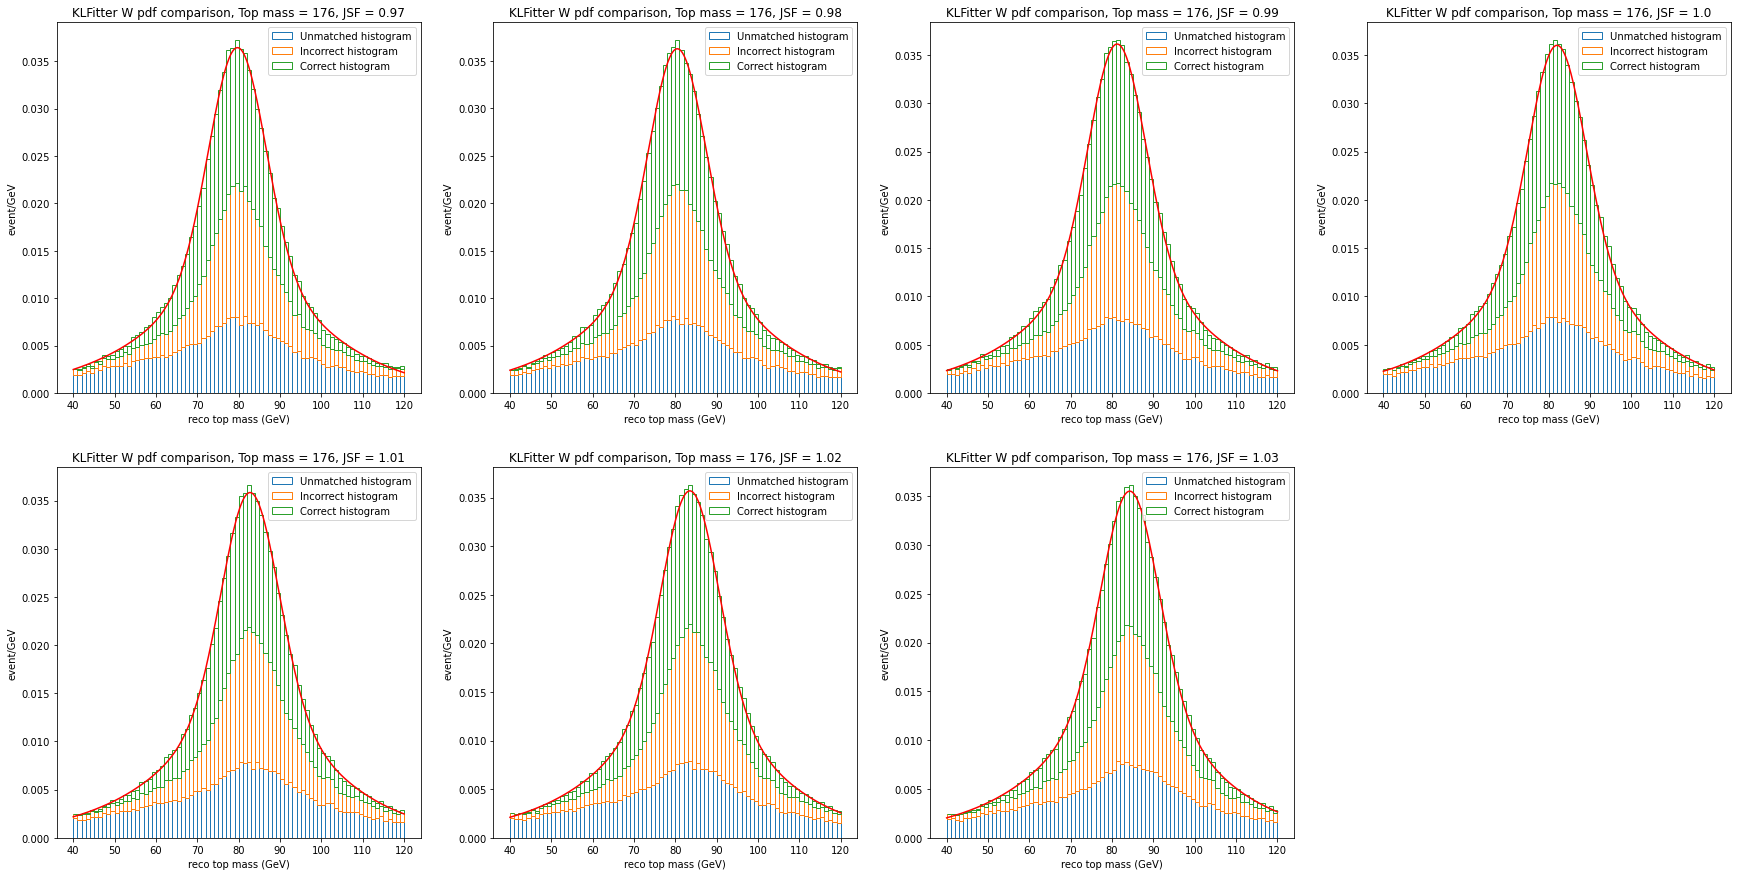

In [51]:
# Compare the KLFitter W pdf to the template histogram
for m in mass:
    plt.figure(figsize=(30, 15))
    for i, JSF in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]        
        h, tot = [0]*(len(W_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(W_klf_dic[(m, JSF)][np.logical_and.reduce((state_klf_dic[(m, JSF)] == state_i, cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))], bins=W_bins)
            plt.bar(W_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(W_bins_dense, klf_W_pdf_func(W_bins_dense, m, JSF), c='r')
        plt.title(f'KLFitter W pdf comparison, Top mass = {m}, JSF = {JSF}')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass_JSF/KLFitter_pdf_compare/KLFitter W pdf compare, True top mass = {m}.png', bbox_inches='tight')
    plt.show()


In [ ]:
# Compare the SPAnet top pdf to the template histogram
for m in mass:
    plt.figure(figsize=(30, 15))
    for i, JSF in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        target = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]        
        h, tot = [0]*(len(top_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(reco_spanet_dic[(m, JSF)][np.logical_and.reduce((state_spanet_dic[(m, JSF)] == state_i, cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))], bins=top_bins)
            plt.bar(top_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(top_bins_dense, spanet_top_pdf_func(top_bins_dense, m, JSF), c='r')
        plt.title(f'SPAnet top pdf comparison, Top mass = {m}, JSF = {JSF}')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass_JSF/SPAnet_pdf_compare/SPAnet top pdf compare, True top mass = {m}.png', bbox_inches='tight')
    plt.close()
    

In [ ]:
# Compare the SPAnet W pdf to the template histogram
for m in mass:
    plt.figure(figsize=(30, 15))
    for i, JSF in enumerate(JSF_arr):
        plt.subplot(2, 4, i+1)
        target = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]        
        h, tot = [0]*(len(W_bins)-1), len(target)
        for state_i in states:
            hist, _ = np.histogram(W_klf_dic[(m, JSF)][np.logical_and.reduce((state_klf_dic[(m, JSF)] == state_i, cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))], bins=W_bins)
            plt.bar(W_bins_mid, hist/tot/bins_width, bottom=h, edgecolor=colors[state_i], width=bins_width, color='None', label = state_labels[state_i] + ' histogram')
            h += hist/tot/bins_width

        plt.plot(W_bins_dense, klf_W_pdf_func(W_bins_dense, m, JSF), c='r')
        plt.title(f'SPAnet W pdf comparison, Top mass = {m}, JSF = {JSF}')
        plt.xlabel('reco top mass (GeV)')
        plt.ylabel('event/GeV')
        plt.legend(loc='upper right')
    plt.savefig(f'plots_topmass_JSF/SPAnet_pdf_compare/SPAnet W pdf compare, True top mass = {m}.png', bbox_inches='tight')
    plt.close()


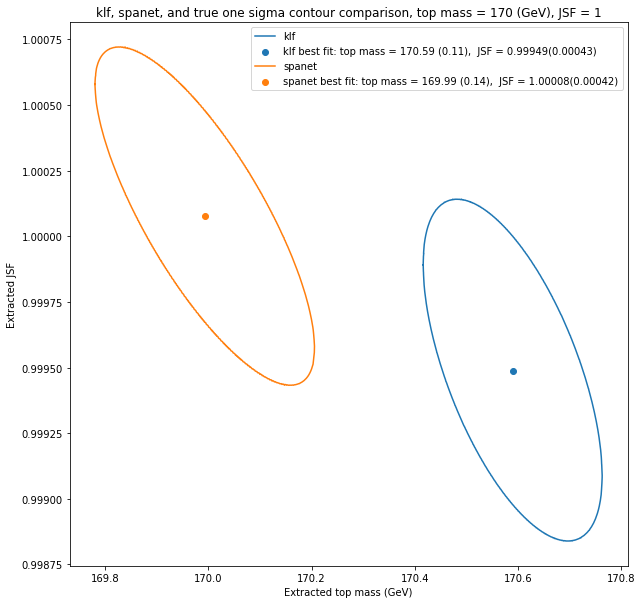

In [81]:
plt.figure(figsize=(10, 10))
m, JSF = 170, 1

reco_klf_top = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
n1 = np.histogram(reco_klf_top, bins=top_bins)[0]
reco_klf_W = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
n2 = np.histogram(reco_klf_W, bins=W_bins)[0]

minuit = Minuit(chi2_klf_arr_func, m=173, JSF=1)
minuit.migrad()
minuit.minos()
pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
x, y = np.transpose(pts)
plt.plot(x, y, '-', label='klf')
plt.scatter(minuit.values[0], minuit.values[1], label='klf best fit: top mass = {:.2f} ({:.2f}),  JSF = {:.5f}({:.5f})'.format(minuit.values[0], minuit.errors[0],  minuit.values[1], minuit.errors[1]))

reco_spanet_top = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
n1 = np.histogram(reco_spanet_top, bins=top_bins)[0]
reco_spanet_W = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
n2 = np.histogram(reco_spanet_W, bins=W_bins)[0]

minuit = Minuit(chi2_spanet_arr_func, m=173, JSF=1)
minuit.migrad()
minuit.minos()
pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
x, y = np.transpose(pts)
plt.plot(x, y, '-', label='spanet')
plt.scatter(minuit.values[0], minuit.values[1], label='spanet best fit: top mass = {:.2f} ({:.2f}),  JSF = {:.5f}({:.5f})'.format(minuit.values[0], minuit.errors[0],  minuit.values[1], minuit.errors[1]))

# reco_perfect_top = reco_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == 2))]
# n1 = np.histogram(reco_perfect_top, bins=top_bins)[0]
# reco_perfect_W = W_perfect_dic[(m, JSF)][np.logical_and.reduce((cut_perfect_dic[(m, JSF)], state_perfect_dic[(m, JSF)] == 2))]
# n2 = np.histogram(reco_perfect_W, bins=W_bins)[0]

# minuit = Minuit(chi2_perfect_arr_func, m=m, JSF=JSF)
# minuit.migrad()
# minuit.minos()
# pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
# x, y = np.transpose(pts)
# plt.plot(x, y, '-', label='true')
# plt.scatter(minuit.values[0], minuit.values[1], label='true best fit: top mass = {:.2f} ({:.2f}),  JSF = {:.5f}({:.5f})'.format(minuit.values[0], minuit.errors[0],  minuit.values[1], minuit.errors[1]))

plt.title('klf, spanet, and true one sigma contour comparison, top mass = {} (GeV), JSF = {}'.format(m, JSF))
plt.xlabel('Extracted top mass (GeV)')
plt.ylabel('Extracted JSF')
plt.legend(loc = 'upper right')
plt.savefig(f'plots_topmass_JSF/final_plots/Extracted contour compare.png', bbox_inches='tight')
plt.show()

In [ ]:
# Define the dictionary storing the result of sudo experiment
sudo_klf_top_mean_dic = {}
sudo_klf_top_std_dic = {}
sudo_klf_JSF_mean_dic = {}
sudo_klf_JSF_std_dic = {}

sudo_spanet_top_mean_dic = {}
sudo_spanet_top_std_dic = {}
sudo_spanet_JSF_mean_dic = {}
sudo_spanet_JSF_std_dic = {}

In [ ]:
# Sudo experiment for KLFitter
for m, JSF in tqdm(product(mass, JSF_arr), total=len(mass)*len(JSF_arr)):
    if (m, JSF) not in sudo_klf_top_mean_dic:
        while True:
            try:
                reco_klf_top = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
                reco_klf_W = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
                sudo_klf_top = np.histogram(reco_klf_top, bins=top_bins)[0]
                sudo_klf_W = np.histogram(reco_klf_W, bins=W_bins)[0]
                n1_arr = np.random.poisson(sudo_klf_top, size=(sudo_event, len(sudo_klf_top)))
                n2_arr = np.random.poisson(sudo_klf_W, size=(sudo_event, len(sudo_klf_W)))
                def minimize_chi2(i):
                    chi2_klf_arr_fcn = lambda m, JSF: -2*np.sum(n1_arr[i]*np.log(klf_top_pdf_func(top_bins_mid, m, JSF)*sum(n1_arr[i])*bins_width))\
                    -2*np.sum(n2_arr[i]*np.log(klf_W_pdf_func(W_bins_mid, m, JSF)*sum(n2_arr[i])*bins_width))
                    minuit = Minuit(chi2_klf_arr_fcn, m=173, JSF=1)
                    minuit.limits = [[160, 186],[0.93, 1.07]]
                    minuit.migrad()
                    minuit.minos()
                    return list(minuit.values), list(minuit.errors)
                with Pool() as pool:
                    results = []
                    for i in range(sudo_event):
                        results.append(pool.apply_async(minimize_chi2, args=((i,))))

                    mean, std = [], []
                    for result in results:
                        res = result.get()
                        mean.append(res[0])
                        std.append(res[1])
                    top_mean, JSF_mean = np.transpose(mean)
                    top_std, JSF_std = np.transpose(std)
                    sudo_klf_top_mean_dic[(m, JSF)] = top_mean
                    sudo_klf_top_std_dic[(m, JSF)] = top_std
                    sudo_klf_JSF_mean_dic[(m, JSF)] = JSF_mean
                    sudo_klf_JSF_std_dic[(m, JSF)] = JSF_std
                    results.clear()
            except:
                continue
            else:
                break


In [ ]:
# Sudo experiment for SPAnet
for m, JSF in tqdm(product(mass, JSF_arr), total=len(mass)*len(JSF_arr)):
    if (m, JSF) not in sudo_spanet_top_mean_dic:
        while True:
            try:
                reco_spanet_top = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
                reco_spanet_W = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
                sudo_spanet_top = np.histogram(reco_spanet_top, bins=top_bins)[0]
                sudo_spanet_W = np.histogram(reco_spanet_W, bins=W_bins)[0]
                n1_arr = np.random.poisson(sudo_spanet_top, size=(sudo_event, len(sudo_spanet_top)))
                n2_arr = np.random.poisson(sudo_spanet_W, size=(sudo_event, len(sudo_spanet_W)))
                def minimize_chi2(i):
                    chi2_spanet_arr_fcn = lambda m, JSF: -2*np.sum(n1_arr[i]*np.log(spanet_top_pdf_func(top_bins_mid, m, JSF)*sum(n1_arr[i])*bins_width))\
                    -2*np.sum(n2_arr[i]*np.log(spanet_W_pdf_func(W_bins_mid, m, JSF)*sum(n2_arr[i])*bins_width))
                    minuit = Minuit(chi2_spanet_arr_fcn, m=173, JSF=1)
                    minuit.limits = [[160, 186],[0.93, 1.07]]
                    minuit.migrad()
                    minuit.minos()
                    return list(minuit.values), list(minuit.errors)
                with Pool() as pool:
                    results = []
                    for i in range(sudo_event):
                        results.append(pool.apply_async(minimize_chi2, args=((i,))))

                    mean, std = [], []
                    for result in results:
                        res = result.get()
                        mean.append(res[0])
                        std.append(res[1])
                    top_mean, JSF_mean = np.transpose(mean)
                    top_std, JSF_std = np.transpose(std)
                    sudo_spanet_top_mean_dic[(m, JSF)] = top_mean
                    sudo_spanet_top_std_dic[(m, JSF)] = top_std
                    sudo_spanet_JSF_mean_dic[(m, JSF)] = JSF_mean
                    sudo_spanet_JSF_std_dic[(m, JSF)] = JSF_std
                    results.clear()
            except:
                continue
            else:
                break

In [ ]:
np.savez('top_mass_JSF_pseudo_experiment/sudo_klf4.npz', sudo_klf_top_mean_dic=sudo_klf_top_mean_dic, sudo_klf_top_std_dic=sudo_klf_top_std_dic,
         sudo_klf_JSF_mean_dic=sudo_klf_JSF_mean_dic, sudo_klf_JSF_std_dic=sudo_klf_JSF_std_dic)
np.savez('top_mass_JSF_pseudo_experiment/sudo_spanet4.npz', sudo_spanet_top_mean_dic=sudo_spanet_top_mean_dic, sudo_spanet_top_std_dic=sudo_spanet_top_std_dic,
         sudo_spanet_JSF_mean_dic=sudo_spanet_JSF_mean_dic, sudo_spanet_JSF_std_dic=sudo_spanet_JSF_std_dic)


In [ ]:
data = np.load('top_mass_JSF_pseudo_experiment/sudo_klf3.npz', allow_pickle=True)
sudo_klf_top_mean_dic = data['sudo_klf_top_mean_dic'].item()
sudo_klf_JSF_mean_dic = data['sudo_klf_JSF_mean_dic'].item()
sudo_klf_top_std_dic = data['sudo_klf_top_std_dic'].item()
sudo_klf_JSF_std_dic = data['sudo_klf_JSF_std_dic'].item()

data = np.load('top_mass_JSF_pseudo_experiment/sudo_spanet3.npz', allow_pickle=True)
sudo_spanet_top_mean_dic = data['sudo_spanet_top_mean_dic'].item()
sudo_spanet_JSF_mean_dic = data['sudo_spanet_JSF_mean_dic'].item()
sudo_spanet_top_std_dic = data['sudo_spanet_top_std_dic'].item()
sudo_spanet_JSF_std_dic = data['sudo_spanet_JSF_std_dic'].item()

In [ ]:
perfect_top_arr, perfect_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = zip(*[(m, JSF, np.mean(sudo_klf_top_mean_dic[(m, JSF)]), np.mean(sudo_klf_JSF_mean_dic[(m, JSF)])) for m in mass for JSF in JSF_arr])
perfect_top_arr, perfect_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = np.array(perfect_top_arr), np.array(perfect_JSF_arr), np.array(mean_extracted_top_arr), np.array(mean_extracted_JSF_arr)

def extract_pred(extracted_top, extracted_JSF, a, b, c, d):
    return a + b*(extracted_top-173) + c*(extracted_JSF-1) + d*(extracted_top-173)*(extracted_JSF-1)
extract_pred_top_fcn = lambda a, b, c, d: np.sum((-perfect_top_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)
extract_pred_JSF_fcn = lambda a, b, c, d: np.sum((-perfect_JSF_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)

minuit = Minuit(extract_pred_top_fcn, 173, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_klf_top_popt = list(minuit.values)
minuit = Minuit(extract_pred_JSF_fcn, 1, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_klf_JSF_popt = list(minuit.values)

In [91]:
extract_pred(173, 1, extract_pred_klf_top_popt[0], extract_pred_klf_top_popt[1], extract_pred_klf_top_popt[2], extract_pred_klf_top_popt[3])


172.7778002854888

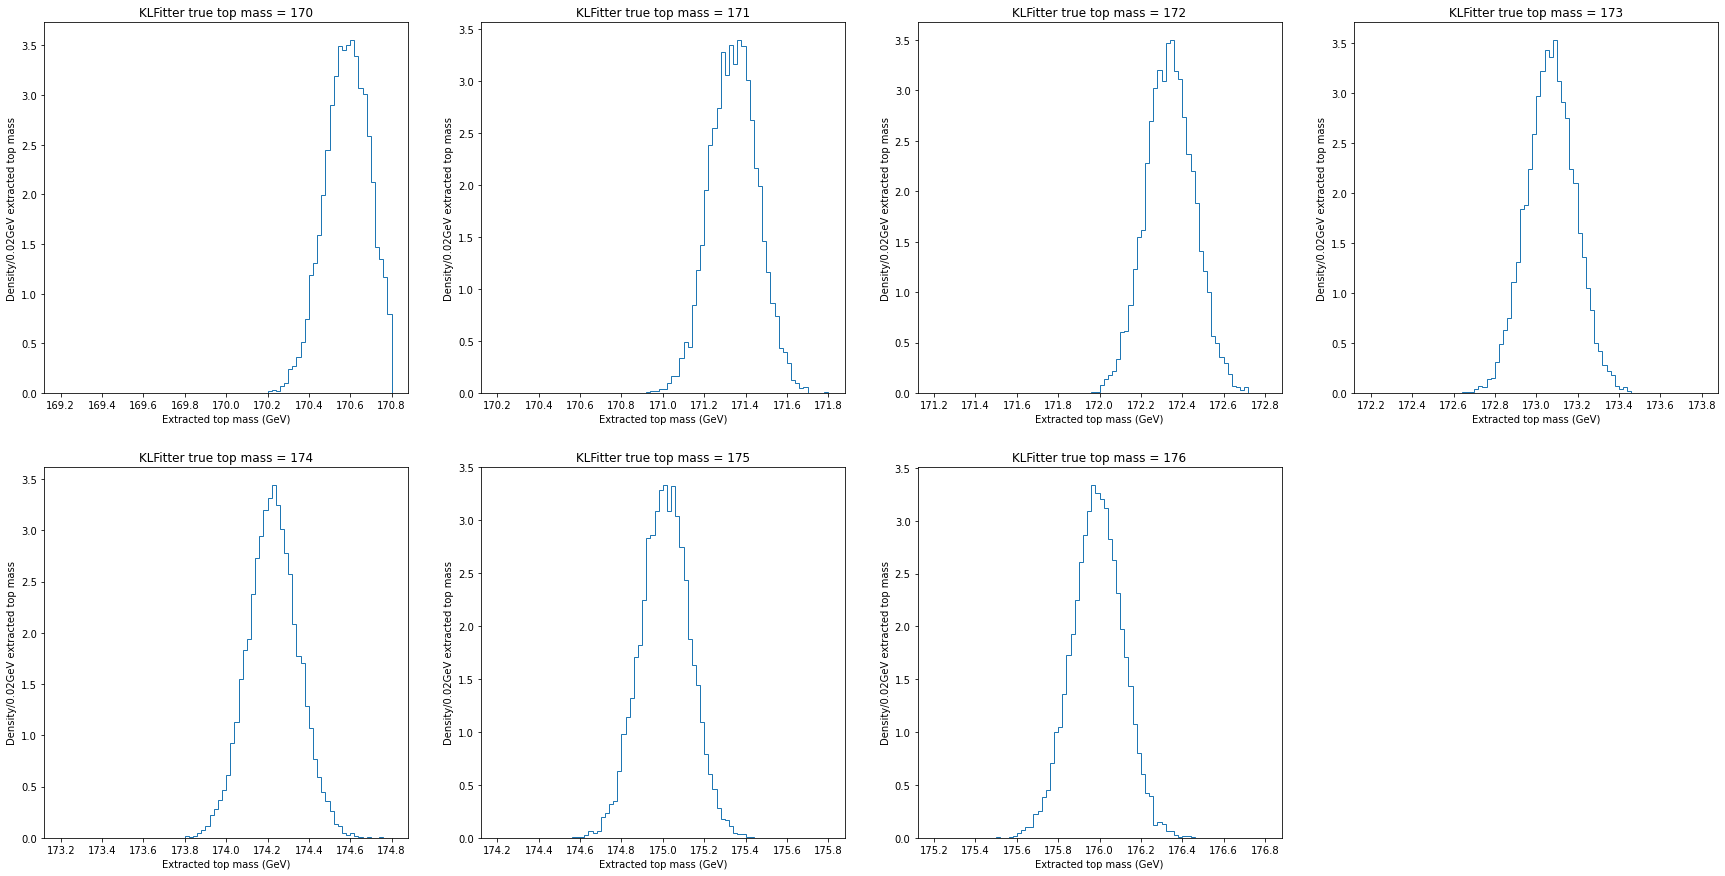

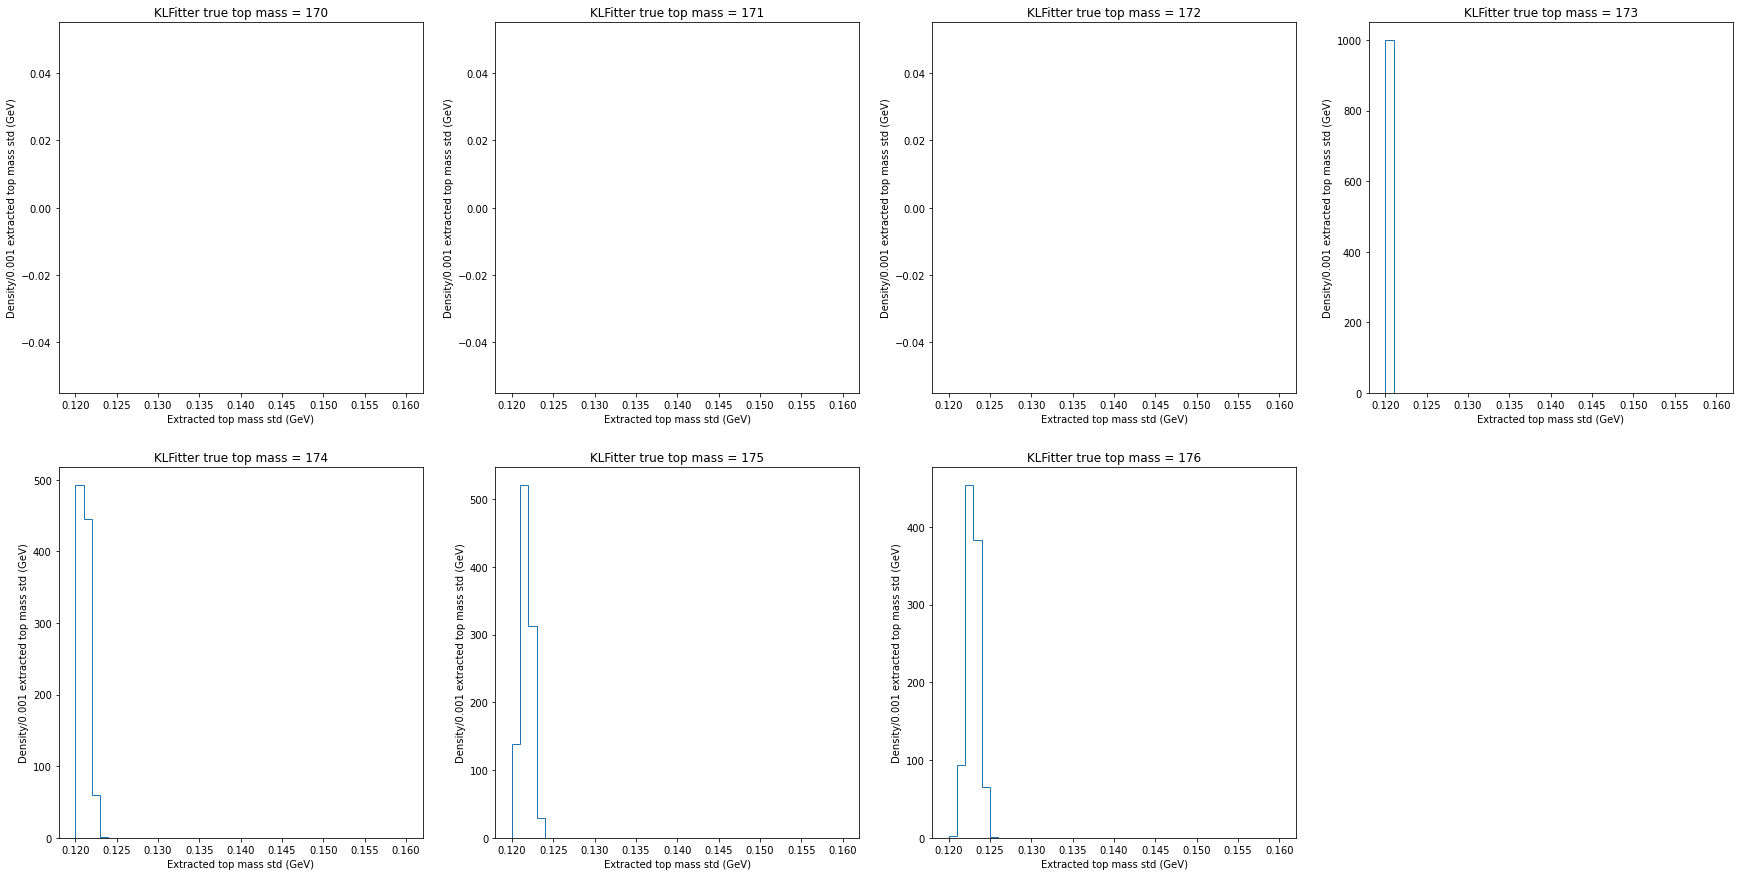

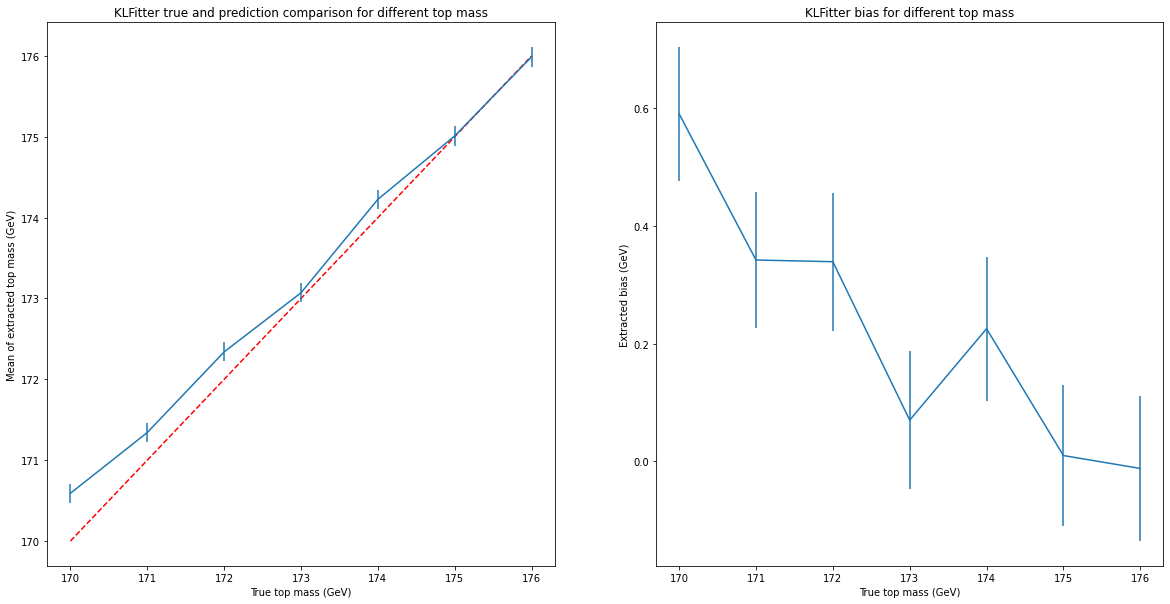

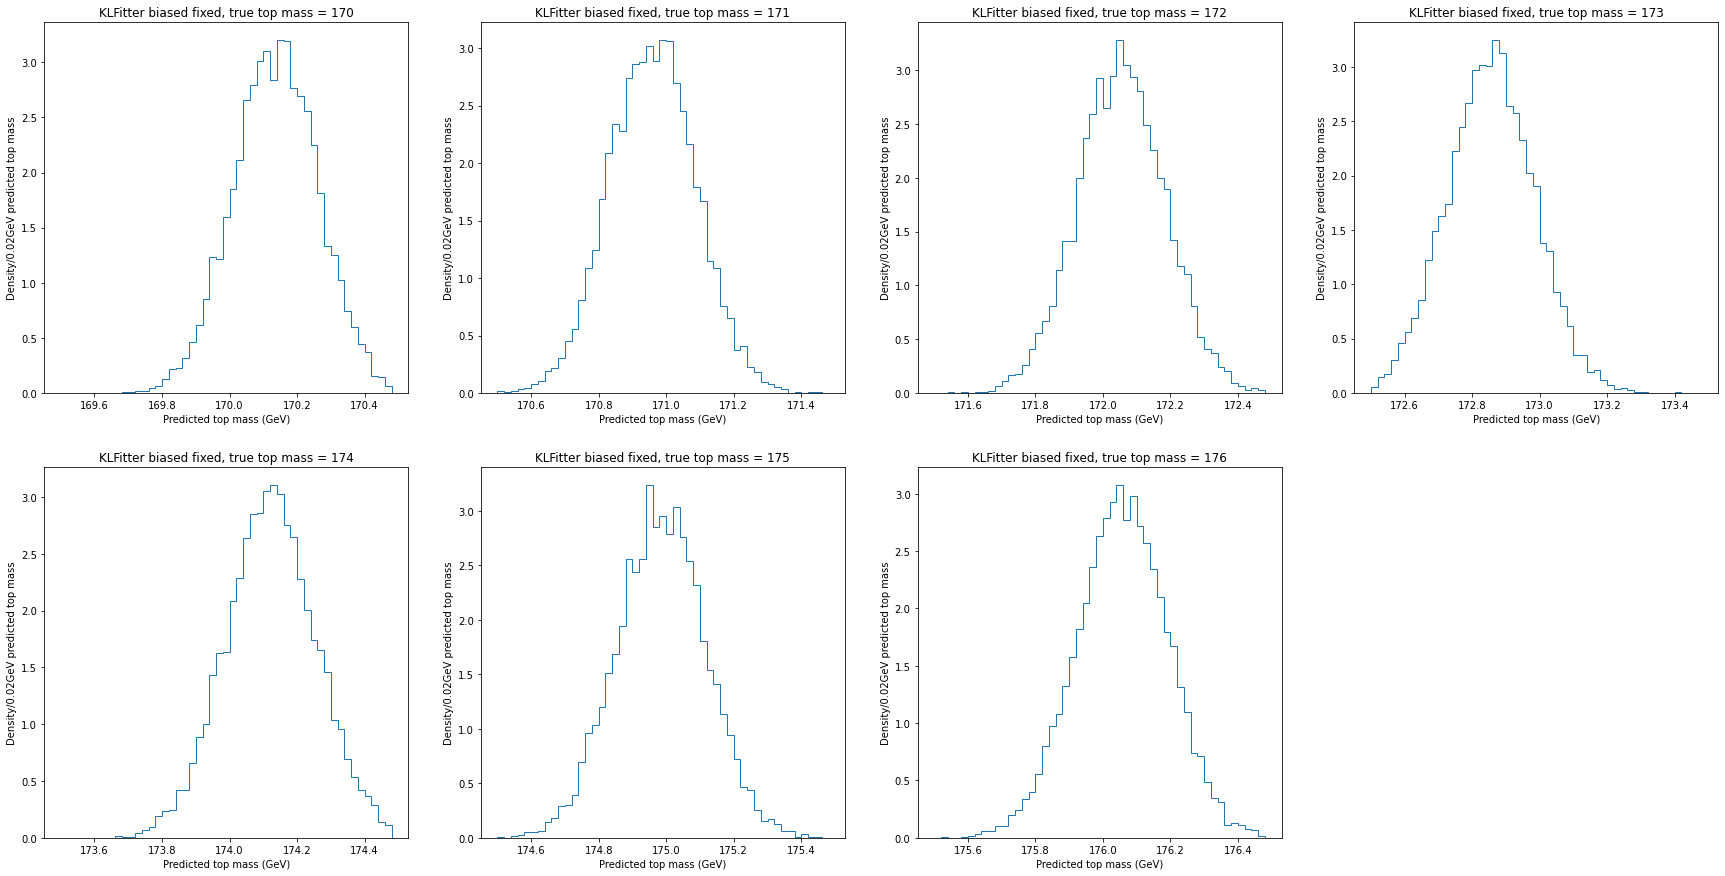

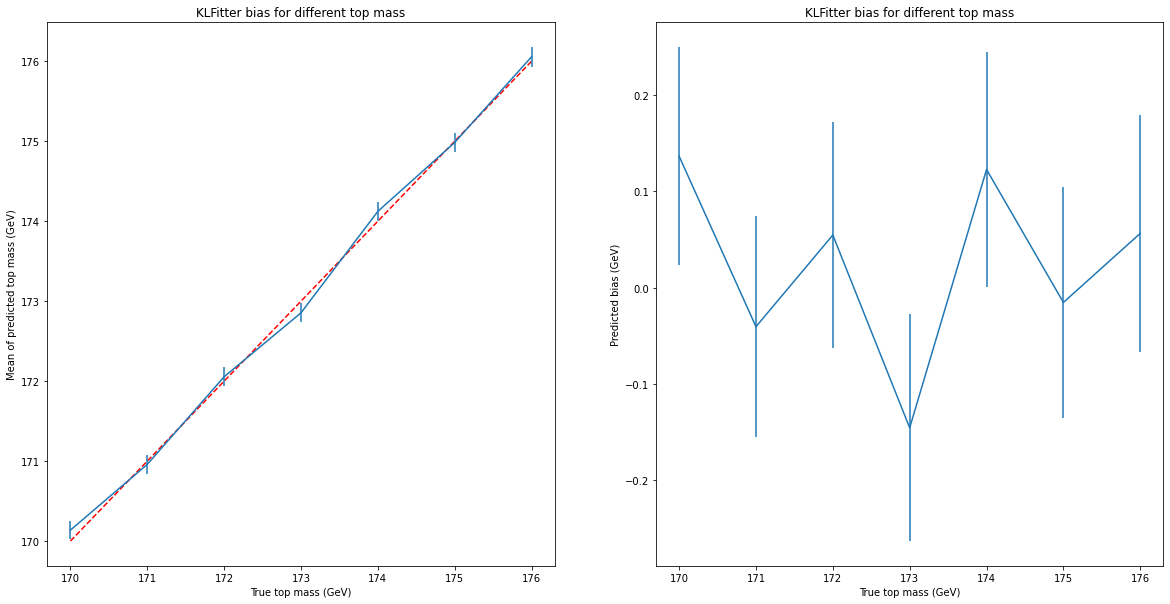

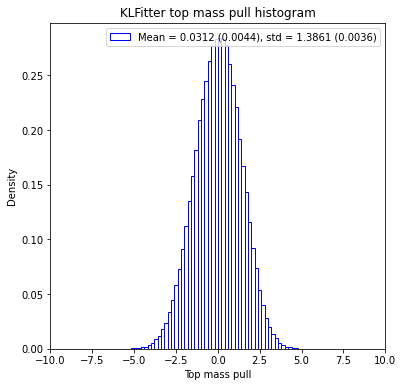

In [52]:
# Plots for KLFitter top mass
JSF = 1
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(sudo_klf_top_mean_dic[(m, JSF)], bins=np.arange(m-0.8, m+0.8, 0.02), density=True, histtype='step')
    plt.title(f'KLFitter true top mass = {m}')
    plt.xlabel('Extracted top mass (GeV)')
    plt.ylabel('Density/0.02GeV extracted top mass')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for KLFitter extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(sudo_klf_top_std_dic[(m, JSF)], bins=np.arange(0.12, 0.16, 0.001), density=True, histtype='step')
    plt.title(f'KLFitter true top mass = {m}')
    plt.xlabel('Extracted top mass std (GeV)')
    plt.ylabel('Density/0.001 extracted top mass std (GeV)')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for KLFitter std of extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[(m, JSF)]) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('KLFitter true and prediction comparison for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of extracted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_klf_top_mean_dic[(m, JSF)])-m for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Extracted bias (GeV)')
plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter true and extracted top mass comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_top_popt), bins=bins_top, density=True, histtype='step')
    plt.title(f'KLFitter biased fixed, true top mass = {m}')
    plt.xlabel('Predicted top mass (GeV)')
    plt.ylabel('Density/0.02GeV predicted top mass')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for KLFitter predicted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_top_popt)) for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of predicted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_top_popt))-m for m in mass], yerr=[np.std(sudo_klf_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('KLFitter bias for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Predicted bias (GeV)')
plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter true and predicted top mass comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
klf_top_pull = [((extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_top_popt))-m)/sudo_klf_top_std_dic[(m, JSF)] for m in mass for JSF in JSF_arr]
hist, bin_edges = np.histogram(klf_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), std = {popt[1]:.4f} ({perr[1]:.4f})')
klf_top_pull_mean, klf_top_pull_mean_std, klf_top_pull_sigma, klf_top_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('KLFitter top mass pull histogram')
plt.xlim(-10, 10)
plt.xlabel('Top mass pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter predicted top mass pull histogram.png', bbox_inches='tight')
plt.show()

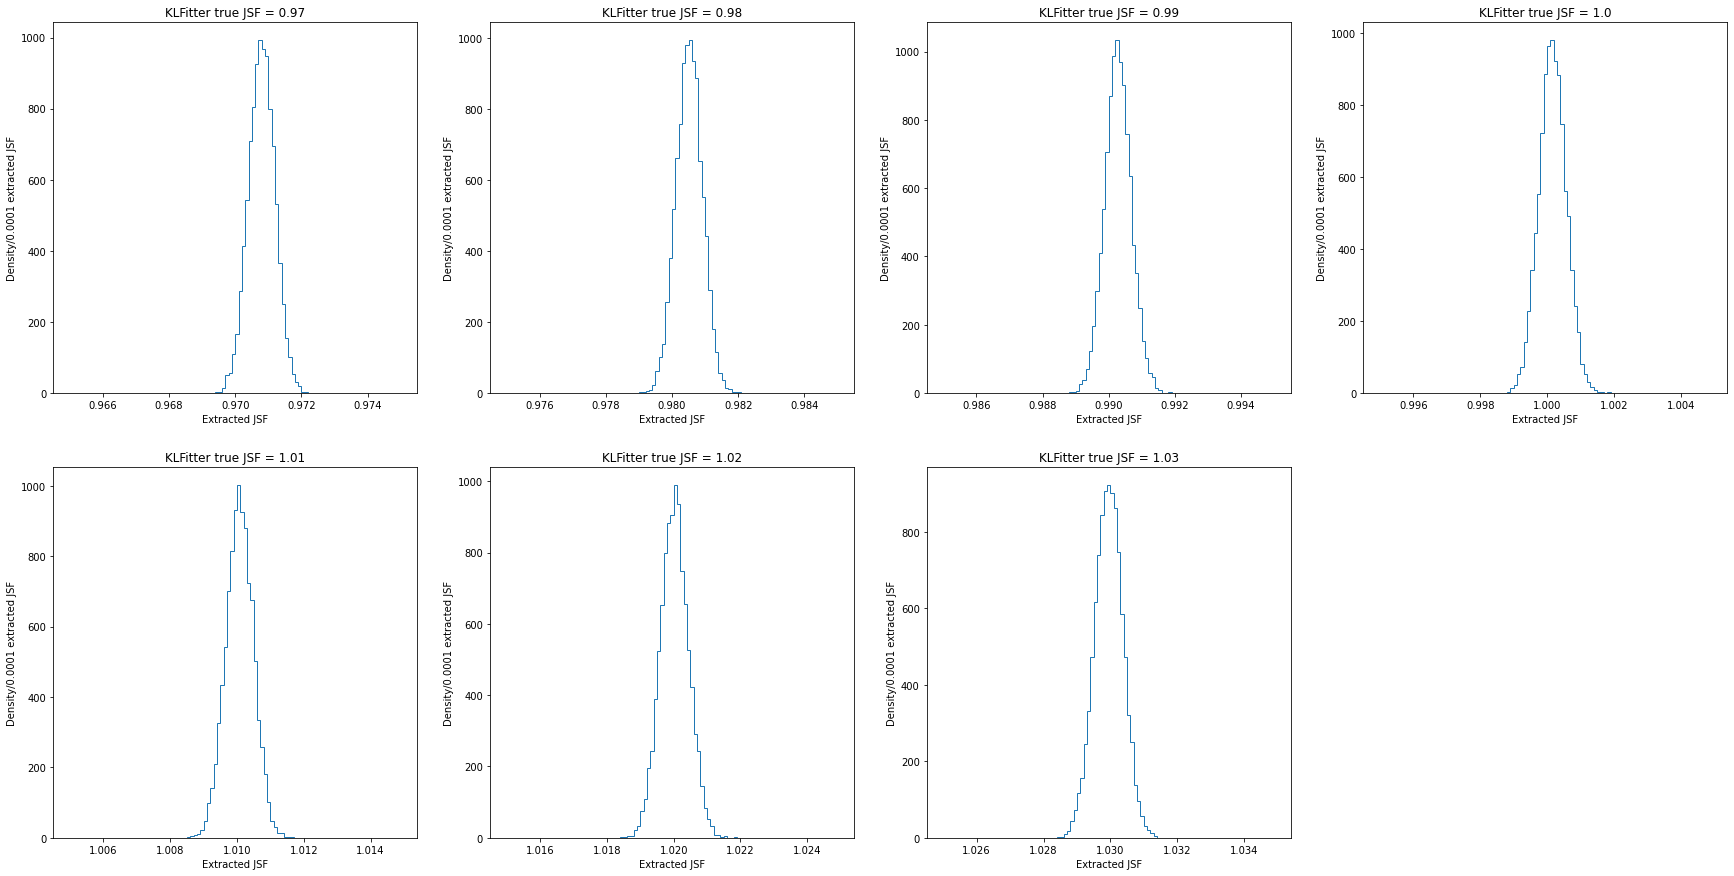

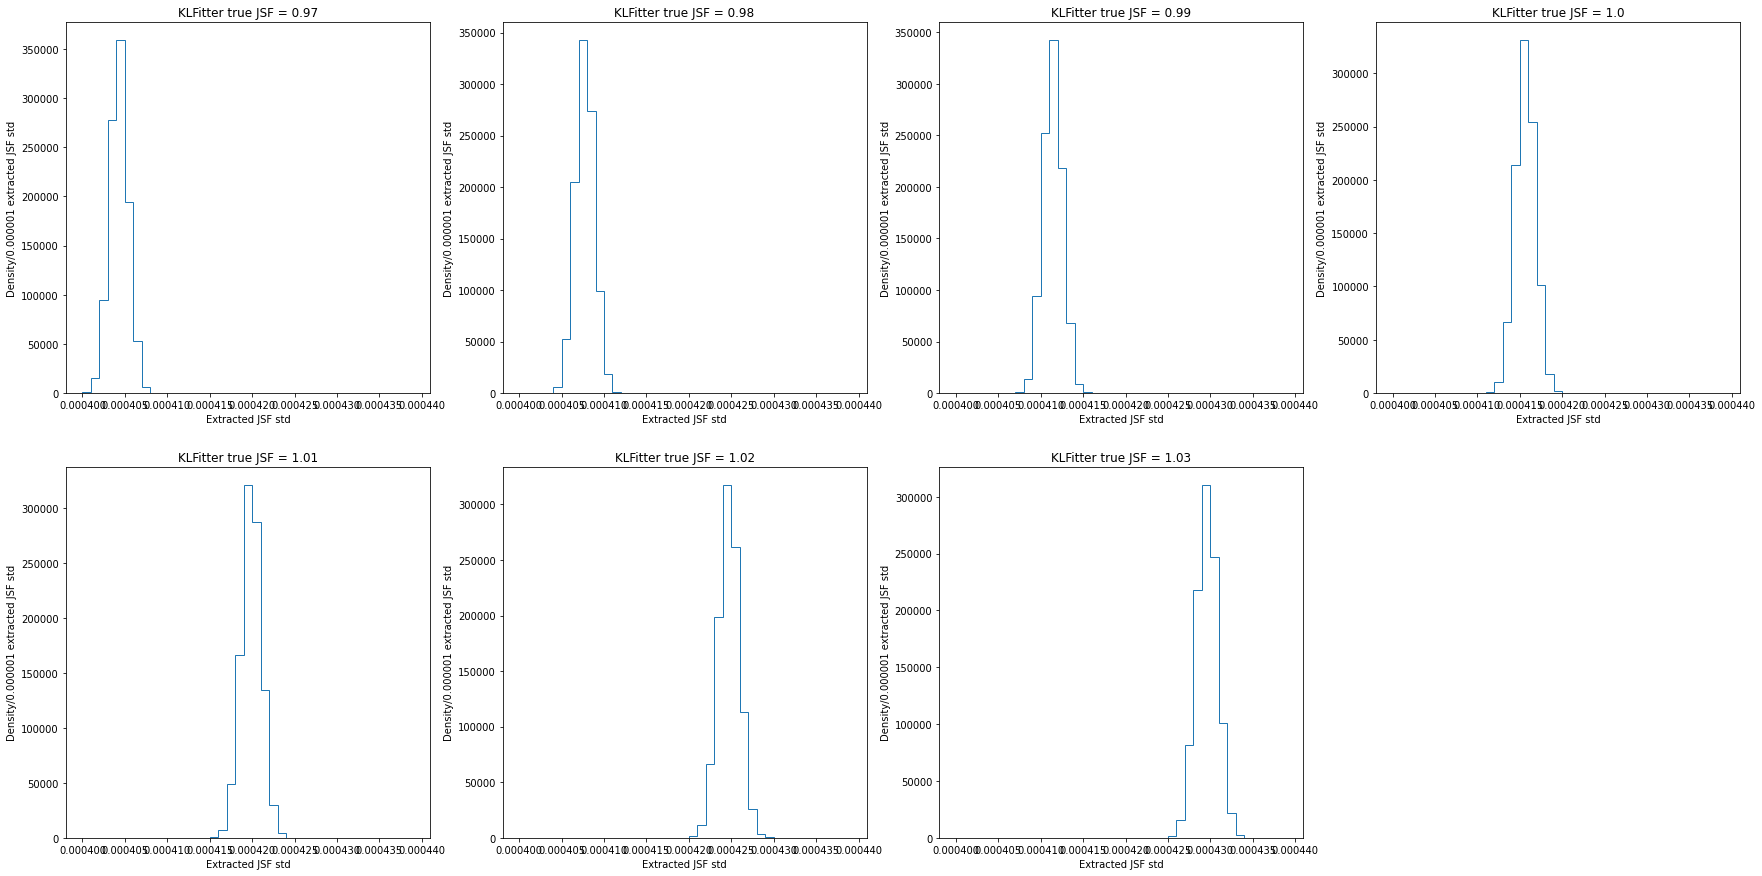

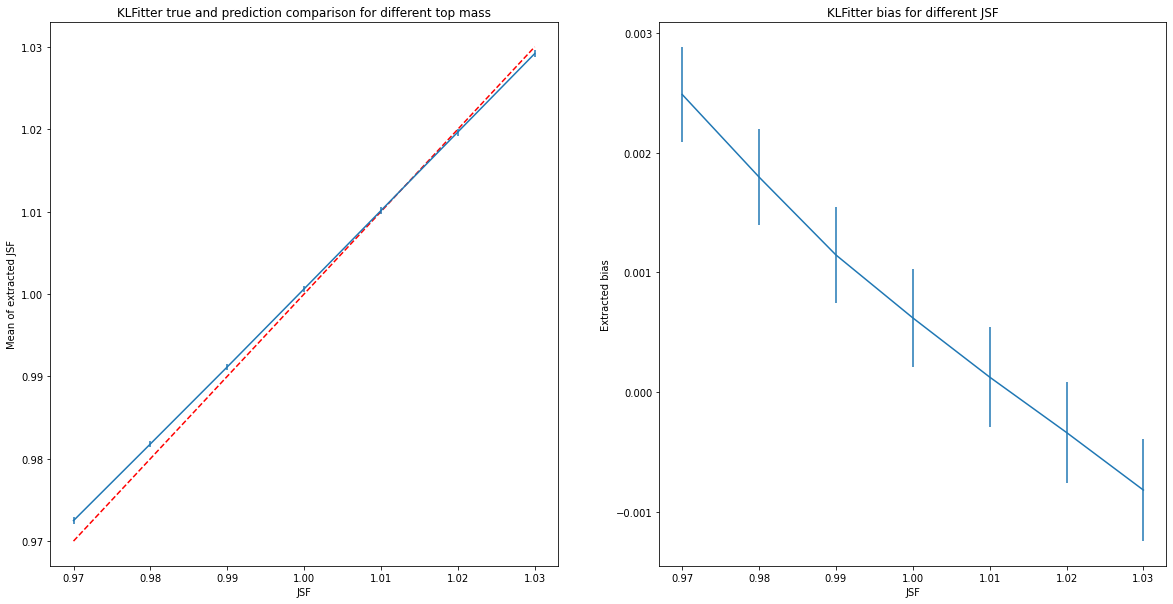

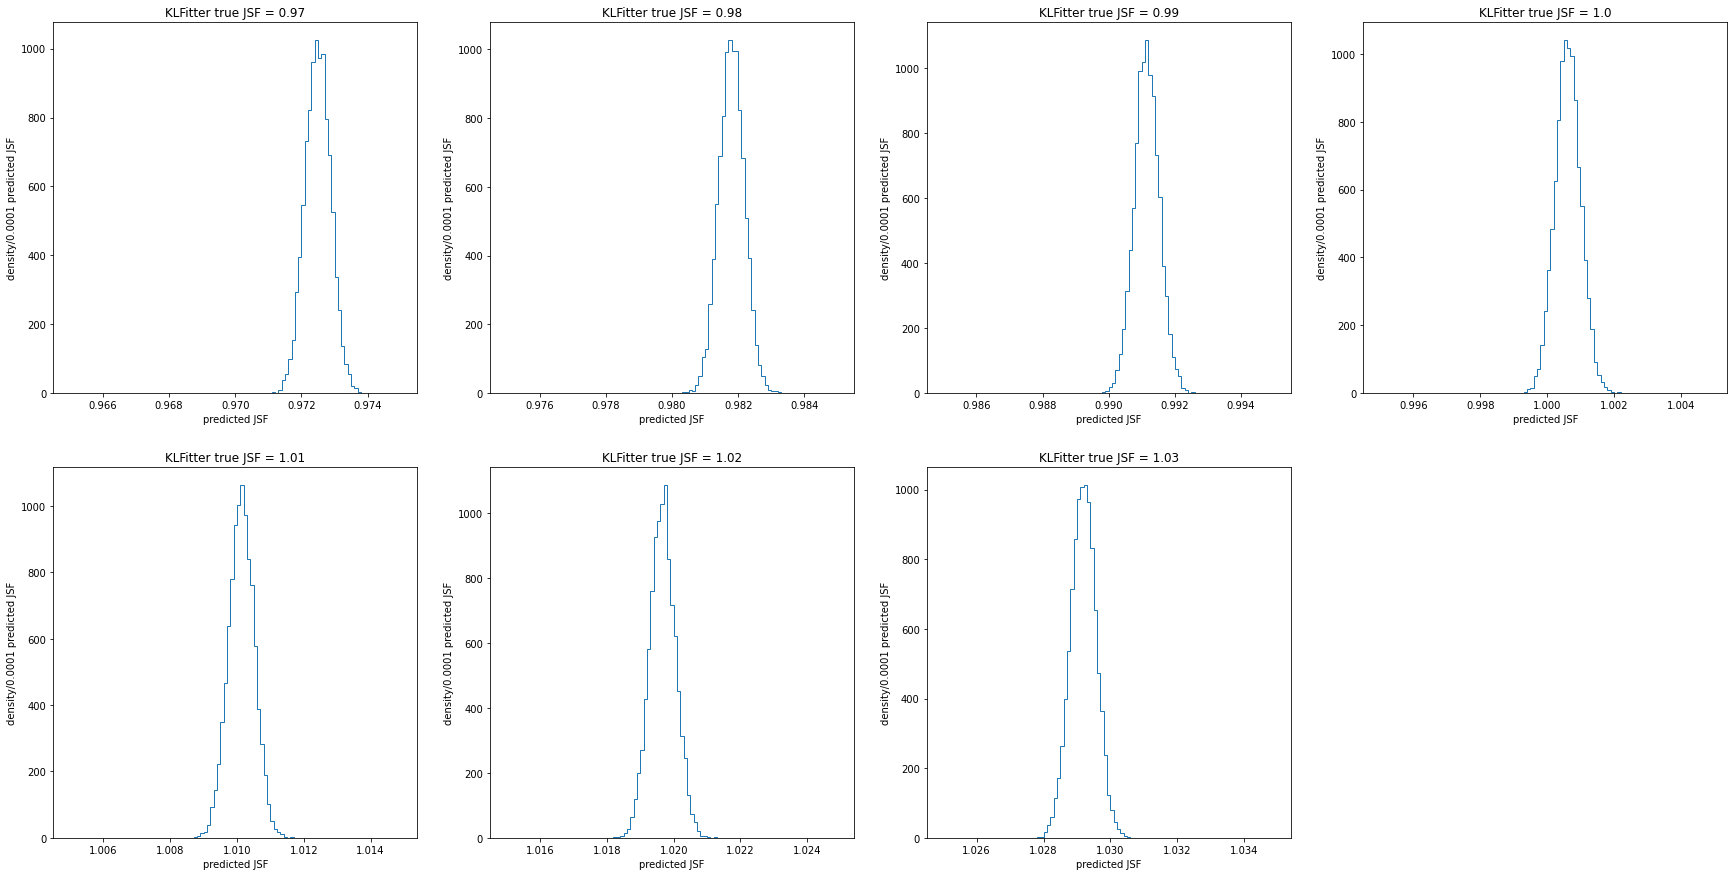

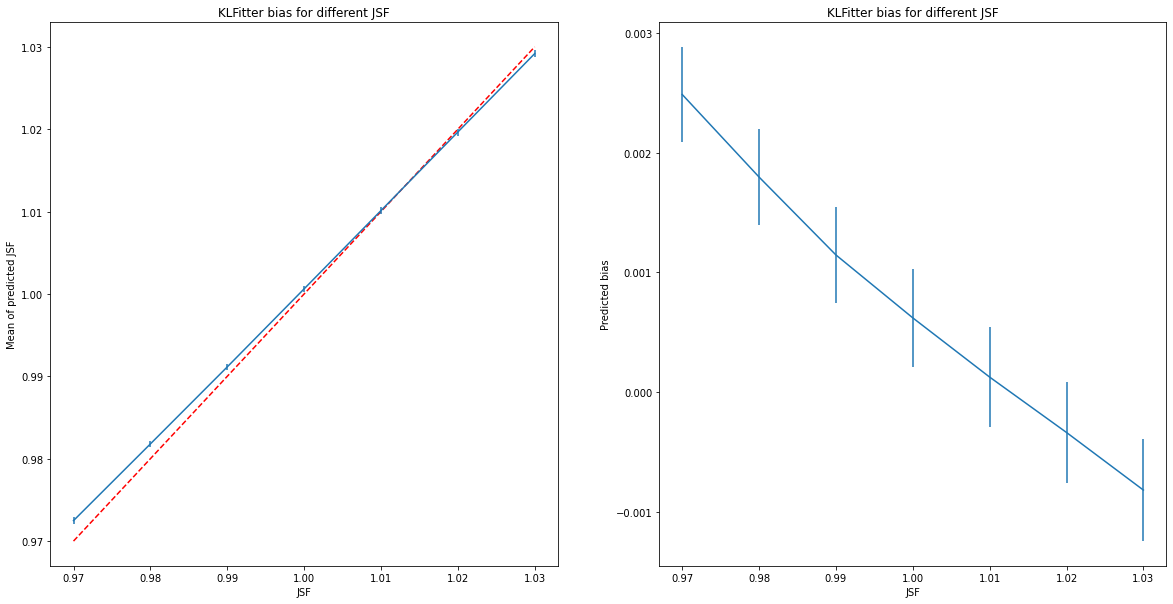

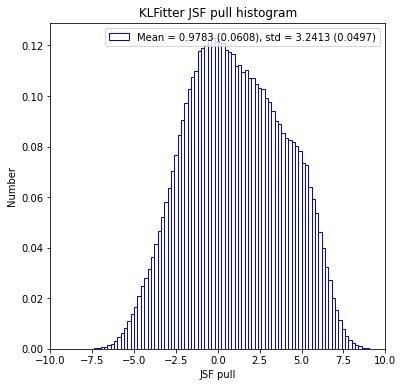

In [53]:
# Plots for KLFitter JSF
m = 173
plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(sudo_klf_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.005, JSF+0.005, 0.0001), density=True, histtype='step')
    plt.title(f'KLFitter true JSF = {JSF}')
    plt.xlabel('Extracted JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for KLFitter extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(sudo_klf_JSF_std_dic[(m, JSF)], bins=np.arange(0.00040, 0.00044, 0.000001), density=True, histtype='step')
    plt.title(f'KLFitter true JSF = {JSF}')
    plt.xlabel('Extracted JSF std')
    plt.ylabel('Density/0.000001 extracted JSF std')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for std of KLFitter extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_JSF_popt)) for JSF in JSF_arr], yerr=[np.std(sudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('KLFitter true and prediction comparison for different top mass')
plt.xlabel('JSF')
plt.ylabel('Mean of extracted JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_JSF_popt))-JSF for JSF in JSF_arr], yerr=[np.std(sudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('KLFitter bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Extracted bias')
plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter true and extracted JSF comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_JSF_popt), bins=np.arange(JSF-0.005, JSF+0.005, 0.0001), density=True, histtype='step')
    plt.title(f'KLFitter true JSF = {JSF}')
    plt.xlabel('predicted JSF')
    plt.ylabel('density/0.0001 predicted JSF')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for KLFitter predicted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_JSF_popt)) for JSF in JSF_arr], yerr=[np.std(sudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('KLFitter bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of predicted JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_JSF_popt))-JSF for JSF in JSF_arr], yerr=[np.std(sudo_klf_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('KLFitter bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Predicted bias')
plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter true and predicted JSF comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
klf_JSF_pull = [(extract_pred(sudo_klf_top_mean_dic[(m, JSF)], sudo_klf_JSF_mean_dic[(m, JSF)], *extract_pred_klf_JSF_popt)-JSF)/sudo_klf_JSF_std_dic[(m, JSF)] for m in mass for JSF in JSF_arr]
hist, bin_edges = np.histogram(klf_JSF_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), std = {popt[1]:.4f} ({perr[1]:.4f})')
klf_JSF_pull_mean, klf_JSF_pull_mean_std, klf_JSF_pull_sigma, klf_JSF_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('KLFitter JSF pull histogram')
plt.xlim(-10, 10)
plt.xlabel('JSF pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.savefig(f'plots_topmass_JSF/final_plots/KLFitter predicted JSF pull histogram.png', bbox_inches='tight')
plt.show()

In [54]:
perfect_top_arr, perfect_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = zip(*[(m, JSF, np.mean(sudo_spanet_top_mean_dic[(m, JSF)]), np.mean(sudo_spanet_JSF_mean_dic[(m, JSF)])) for m in mass for JSF in JSF_arr])
perfect_top_arr, perfect_JSF_arr, mean_extracted_top_arr, mean_extracted_JSF_arr = np.array(perfect_top_arr), np.array(perfect_JSF_arr), np.array(mean_extracted_top_arr), np.array(mean_extracted_JSF_arr)

def extract_pred(extracted_top, extracted_JSF, a, b, c, d):
    return a + b*(extracted_top-173) + c*(extracted_JSF-1) + d*(extracted_top-173)*(extracted_JSF-1)
extract_pred_top_fcn = lambda a, b, c, d: np.sum((-perfect_top_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)
extract_pred_JSF_fcn = lambda a, b, c, d: np.sum((-perfect_JSF_arr + a + b*(mean_extracted_top_arr-173) + c*(mean_extracted_JSF_arr-1) + d*(mean_extracted_top_arr-173)*(mean_extracted_JSF_arr-1))**2)

minuit = Minuit(extract_pred_top_fcn, 173, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_spanet_top_popt = list(minuit.values)
minuit = Minuit(extract_pred_JSF_fcn, 1, 1, 1, 1)
minuit.migrad()
minuit.minos()
extract_pred_spanet_JSF_popt = list(minuit.values)

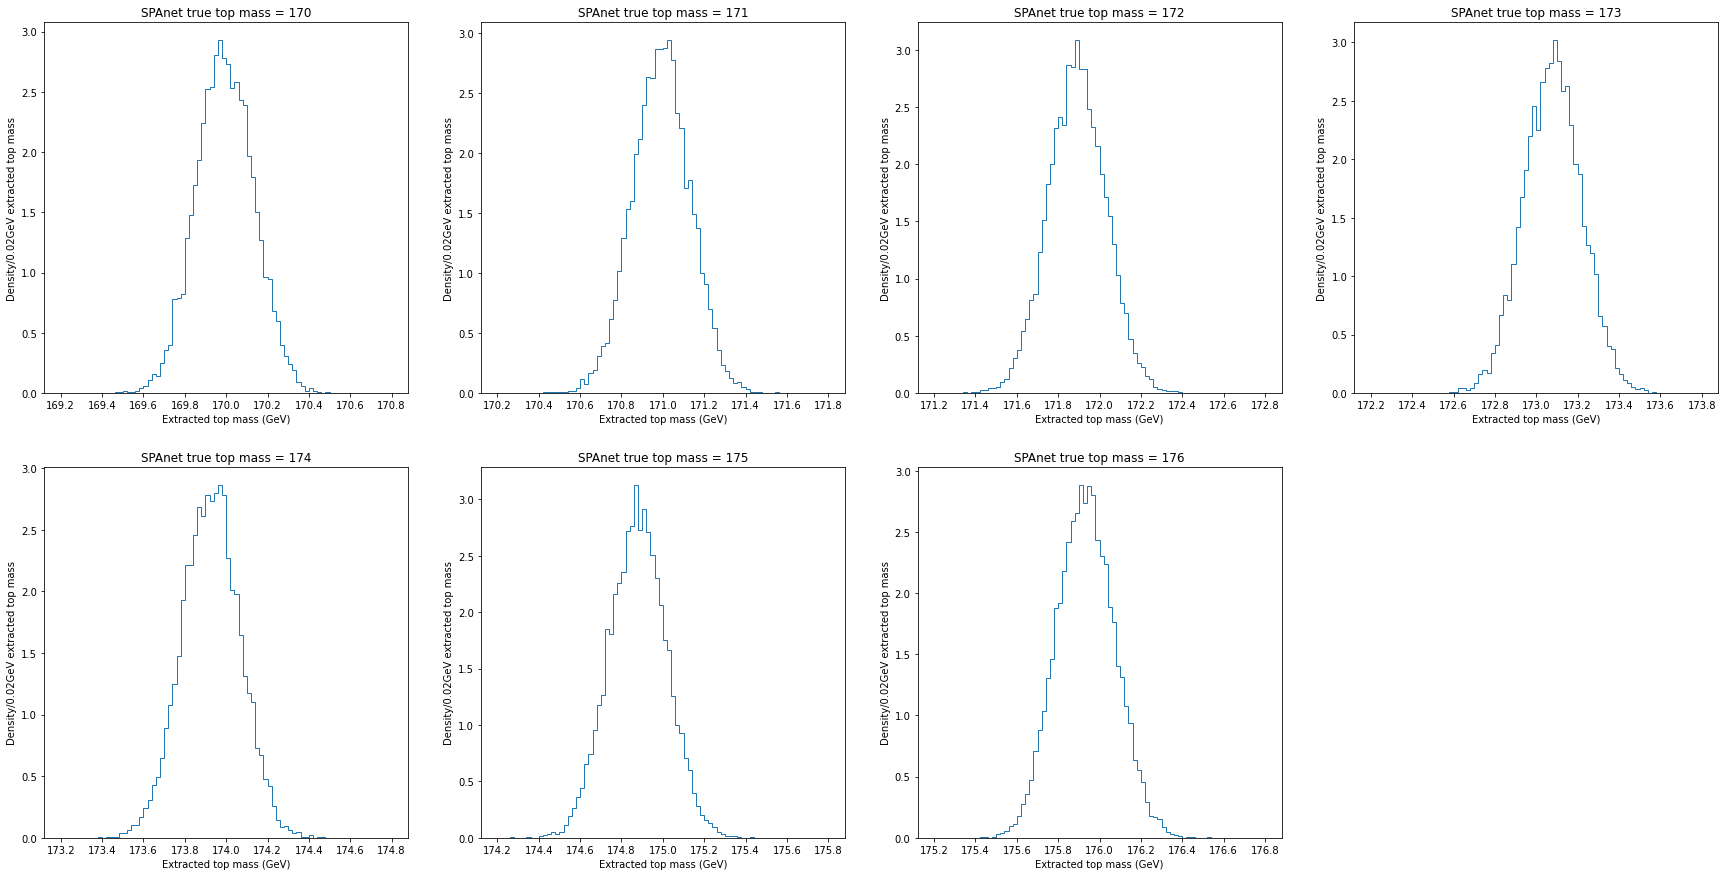

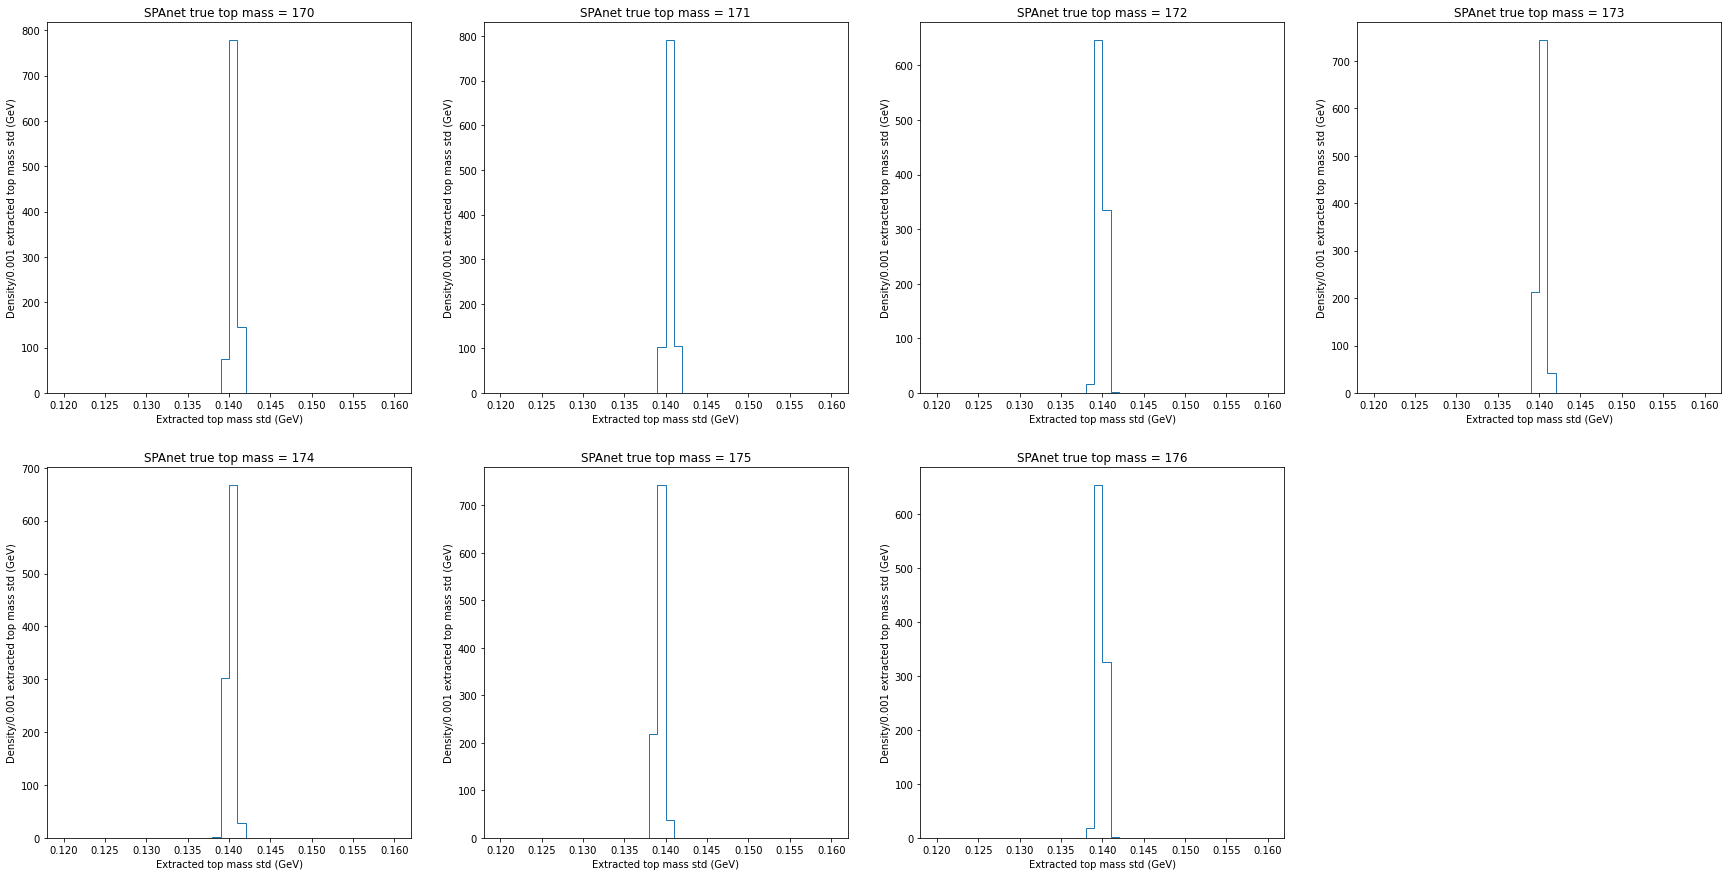

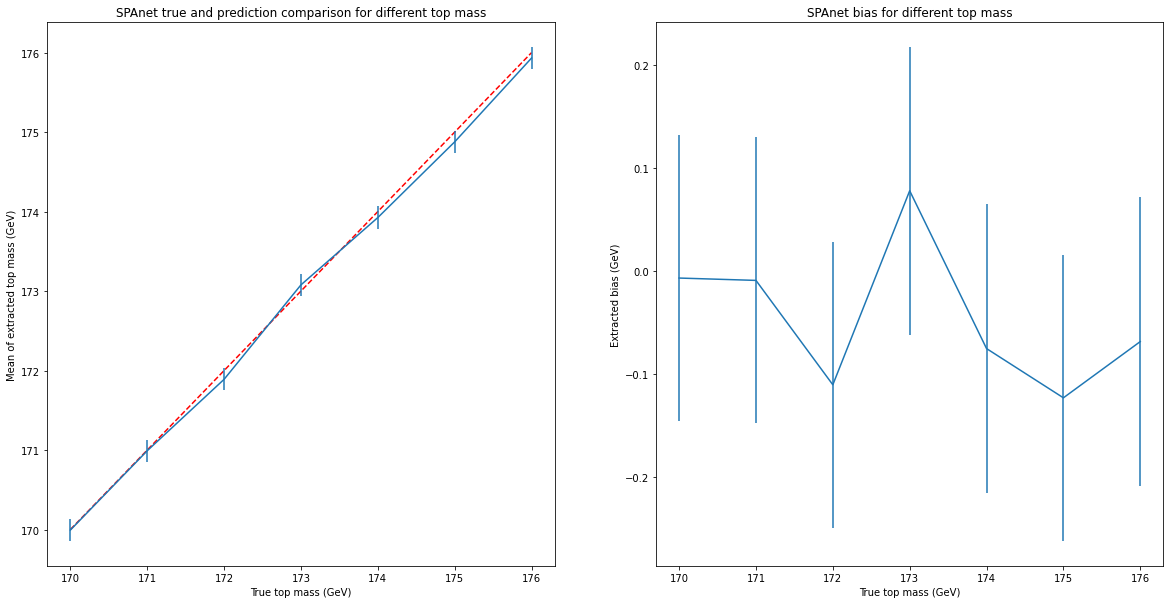

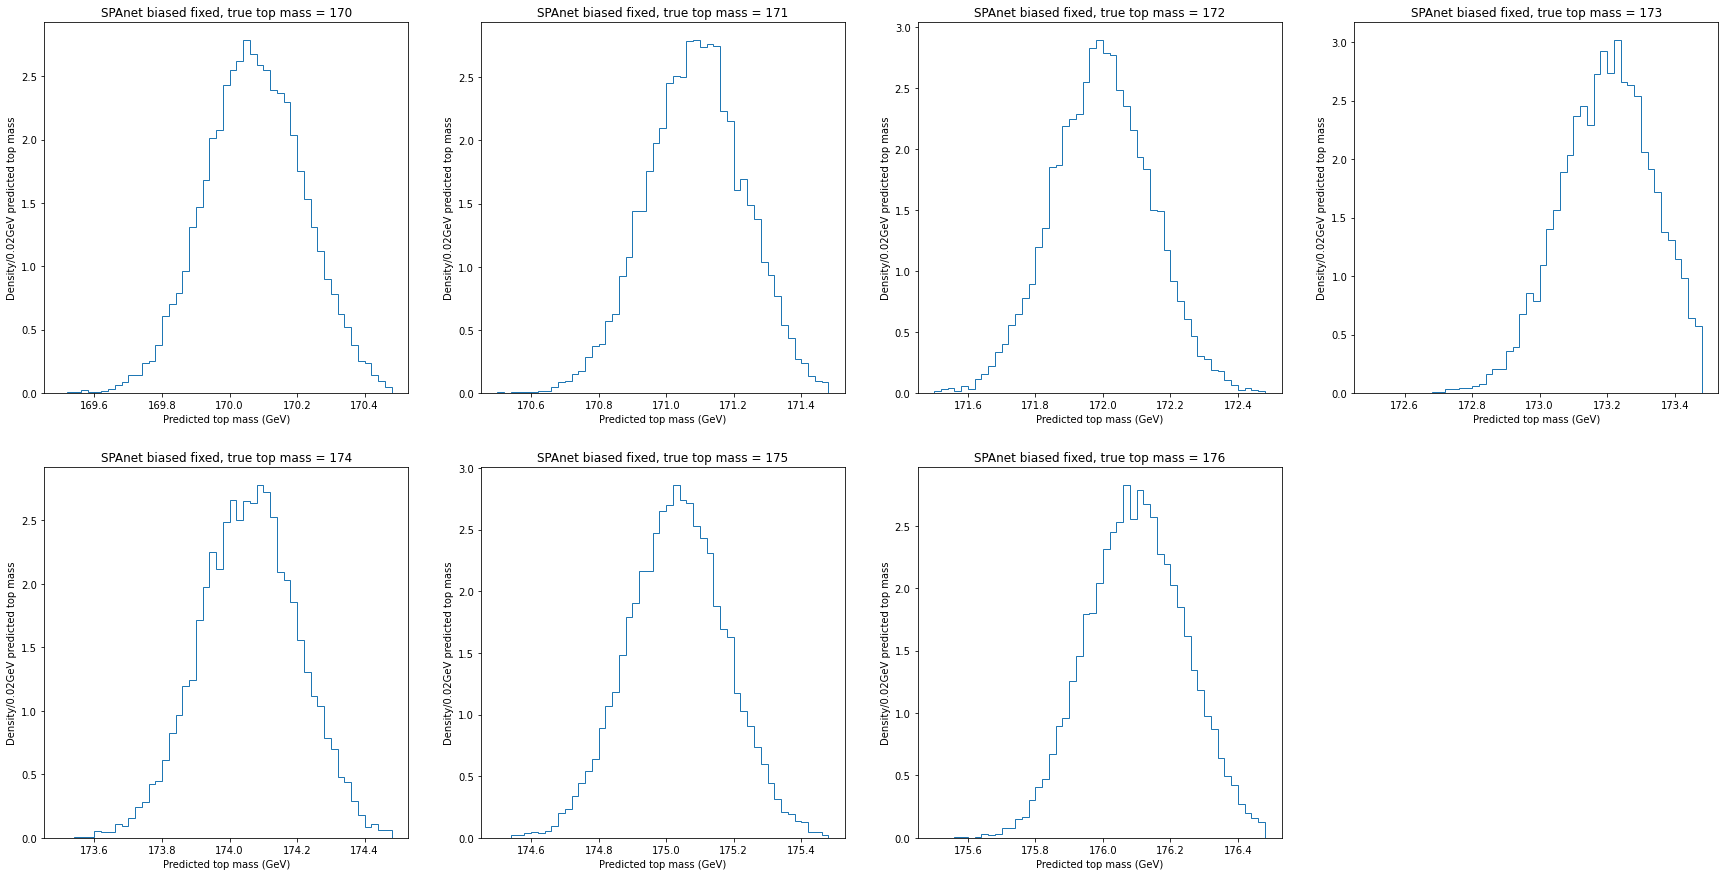

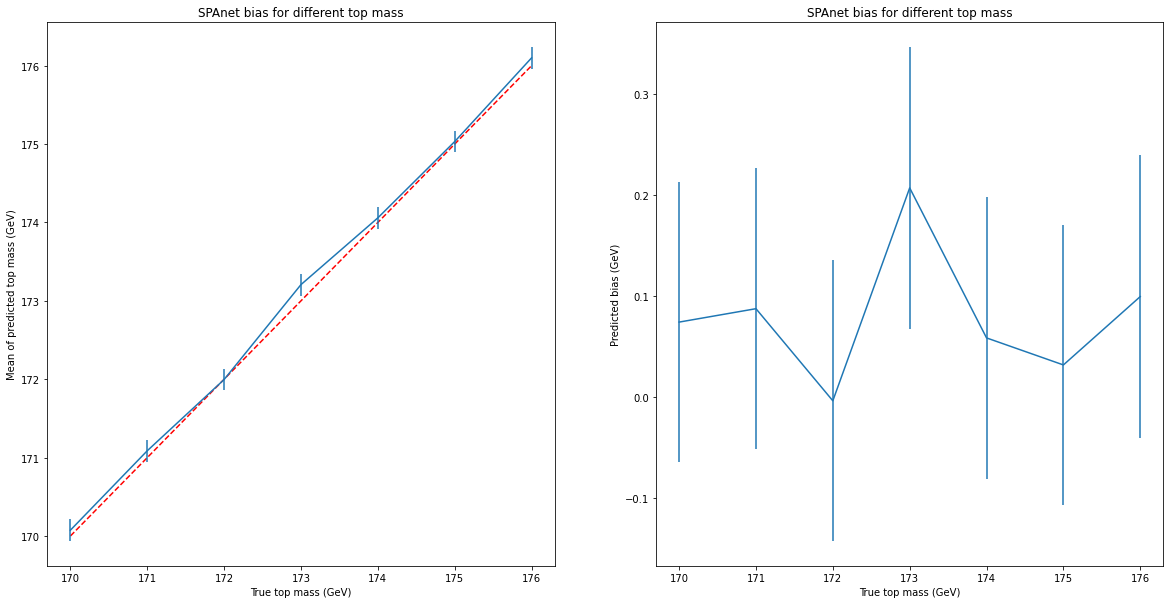

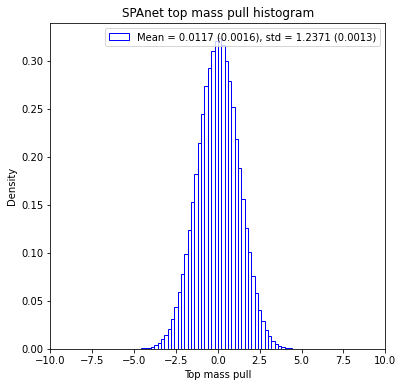

In [55]:
# Plots for SPAnet top mass
JSF = 1
plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(sudo_spanet_top_mean_dic[(m, JSF)], bins=np.arange(m-0.8, m+0.8, 0.02), density=True, histtype='step')
    plt.title(f'SPAnet true top mass = {m}')
    plt.xlabel('Extracted top mass (GeV)')
    plt.ylabel('Density/0.02GeV extracted top mass')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for SPAnet extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    plt.hist(sudo_spanet_top_std_dic[(m, JSF)], bins=np.arange(0.12, 0.16, 0.001), density=True, histtype='step')
    plt.title(f'SPAnet true top mass = {m}')
    plt.xlabel('Extracted top mass std (GeV)')
    plt.ylabel('Density/0.001 extracted top mass std (GeV)')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for SPAnet std of extracted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(sudo_spanet_top_mean_dic[(m, JSF)]) for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('SPAnet true and prediction comparison for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of extracted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(sudo_spanet_top_mean_dic[(m, JSF)])-m for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Extracted bias (GeV)')
plt.savefig(f'plots_topmass_JSF/final_plots/SPAnet true and extracted top mass comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, m in enumerate(mass):
    plt.subplot(2, 4, i+1)
    bins_top = np.arange(m-0.5, m+0.5, 0.02)
    plt.hist(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_top_popt), bins=bins_top, density=True, histtype='step')
    plt.title(f'SPAnet biased fixed, true top mass = {m}')
    plt.xlabel('Predicted top mass (GeV)')
    plt.ylabel('Density/0.02GeV predicted top mass')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for SPAnet predicted top mass.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(mass, mass, 'r--')
plt.errorbar(mass, [np.mean(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_top_popt)) for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Mean of predicted top mass (GeV)')
plt.subplot(1, 2, 2)
plt.errorbar(mass, [np.mean(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_top_popt))-m for m in mass], yerr=[np.std(sudo_spanet_top_mean_dic[(m, JSF)]) for m in mass])
plt.title('SPAnet bias for different top mass')
plt.xlabel('True top mass (GeV)')
plt.ylabel('Predicted bias (GeV)')
plt.savefig(f'plots_topmass_JSF/final_plots/SPAnet true and predicted top mass comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
spanet_top_pull = [((extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_top_popt))-m)/sudo_spanet_top_std_dic[(m, JSF)] for m in mass for JSF in JSF_arr]
hist, bin_edges = np.histogram(spanet_top_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), std = {popt[1]:.4f} ({perr[1]:.4f})')
spanet_top_pull_mean, spanet_top_pull_mean_std, spanet_top_pull_sigma, spanet_top_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('SPAnet top mass pull histogram')
plt.xlim(-10, 10)
plt.xlabel('Top mass pull')
plt.ylabel('Density')
plt.legend(loc='upper right')
plt.savefig(f'plots_topmass_JSF/final_plots/SPAnet predicted top mass pull histogram.png', bbox_inches='tight')
plt.show()

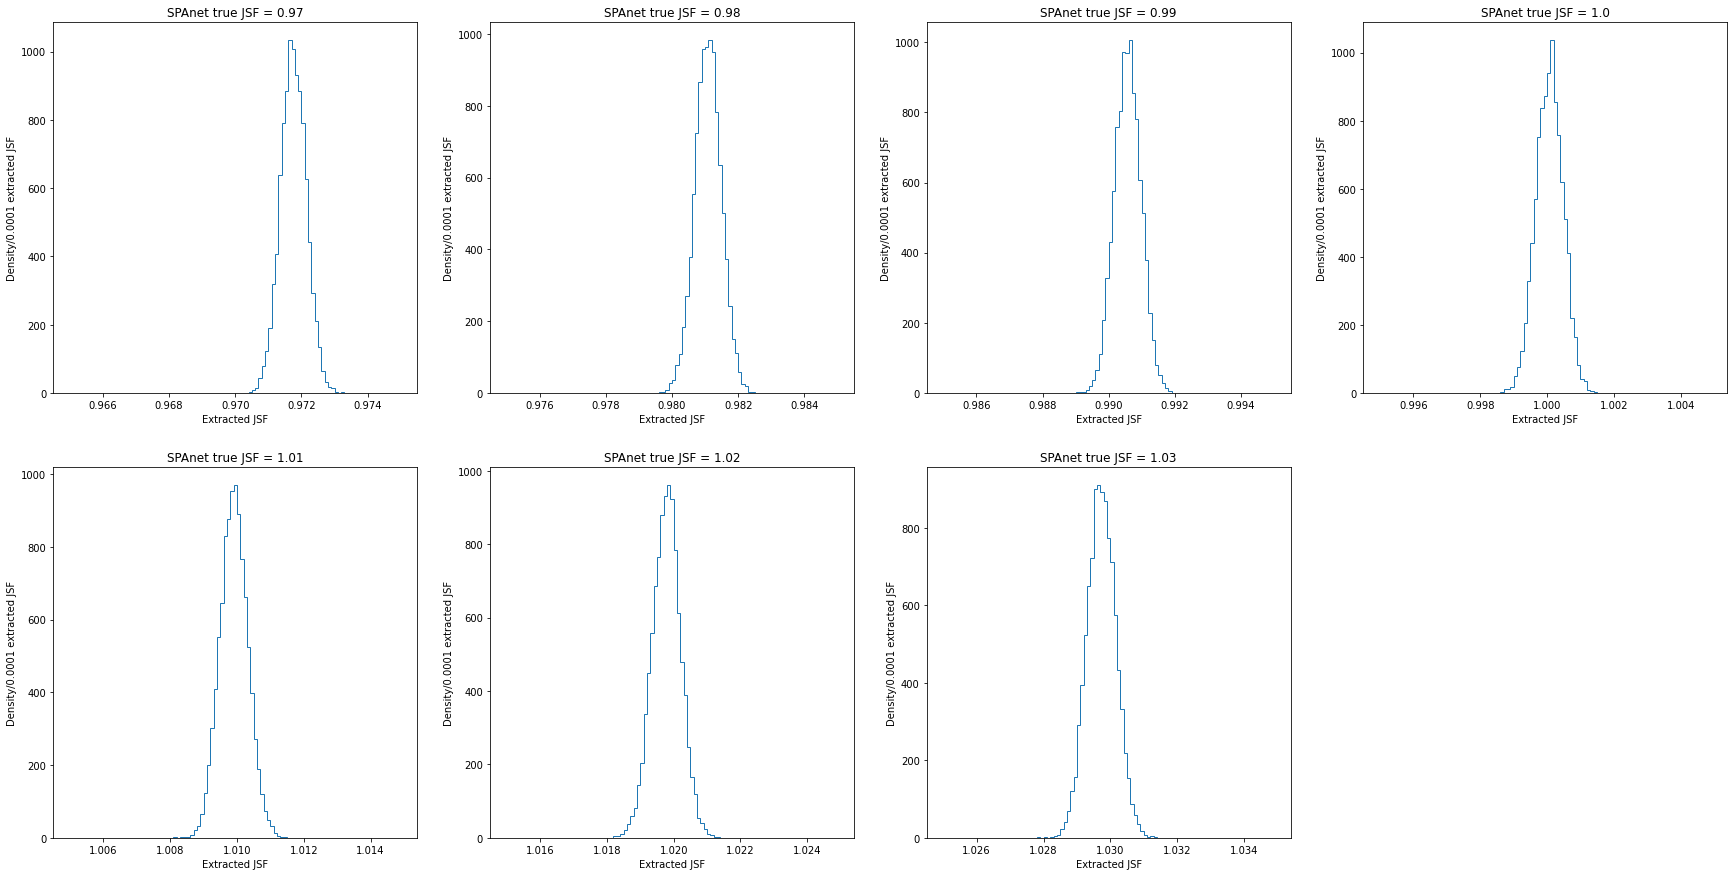

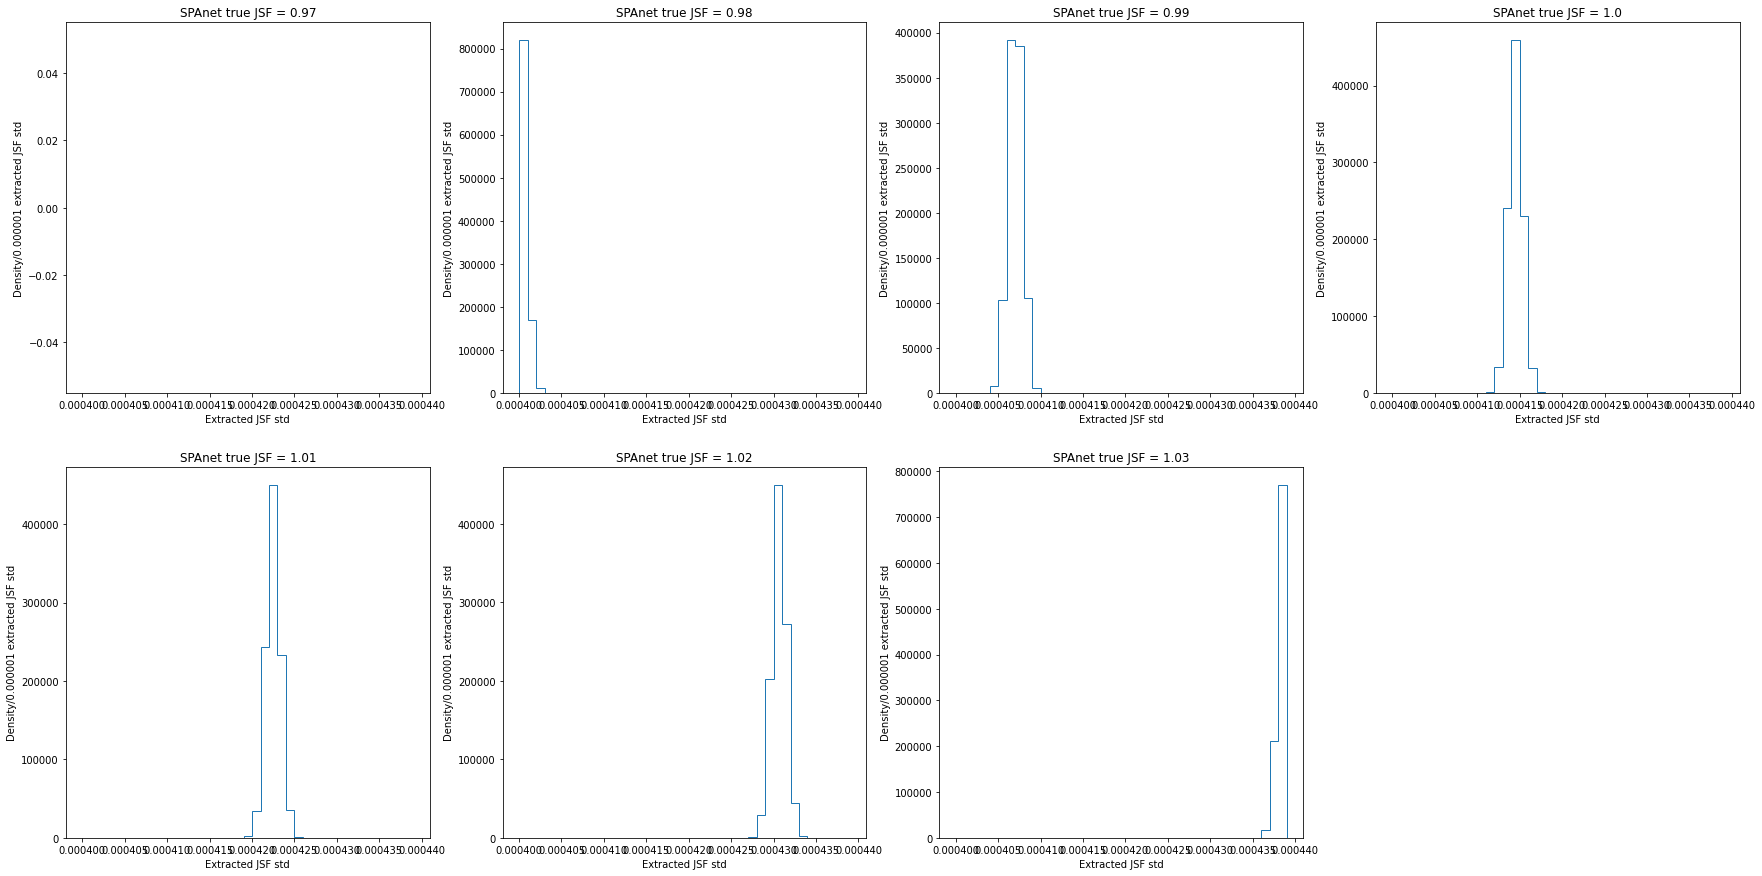

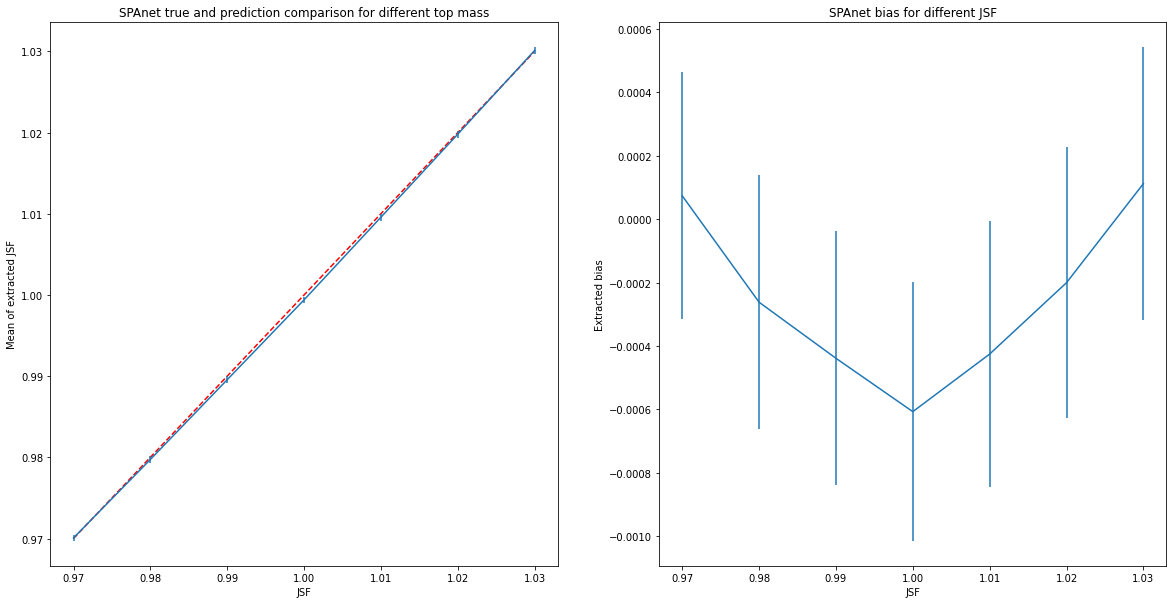

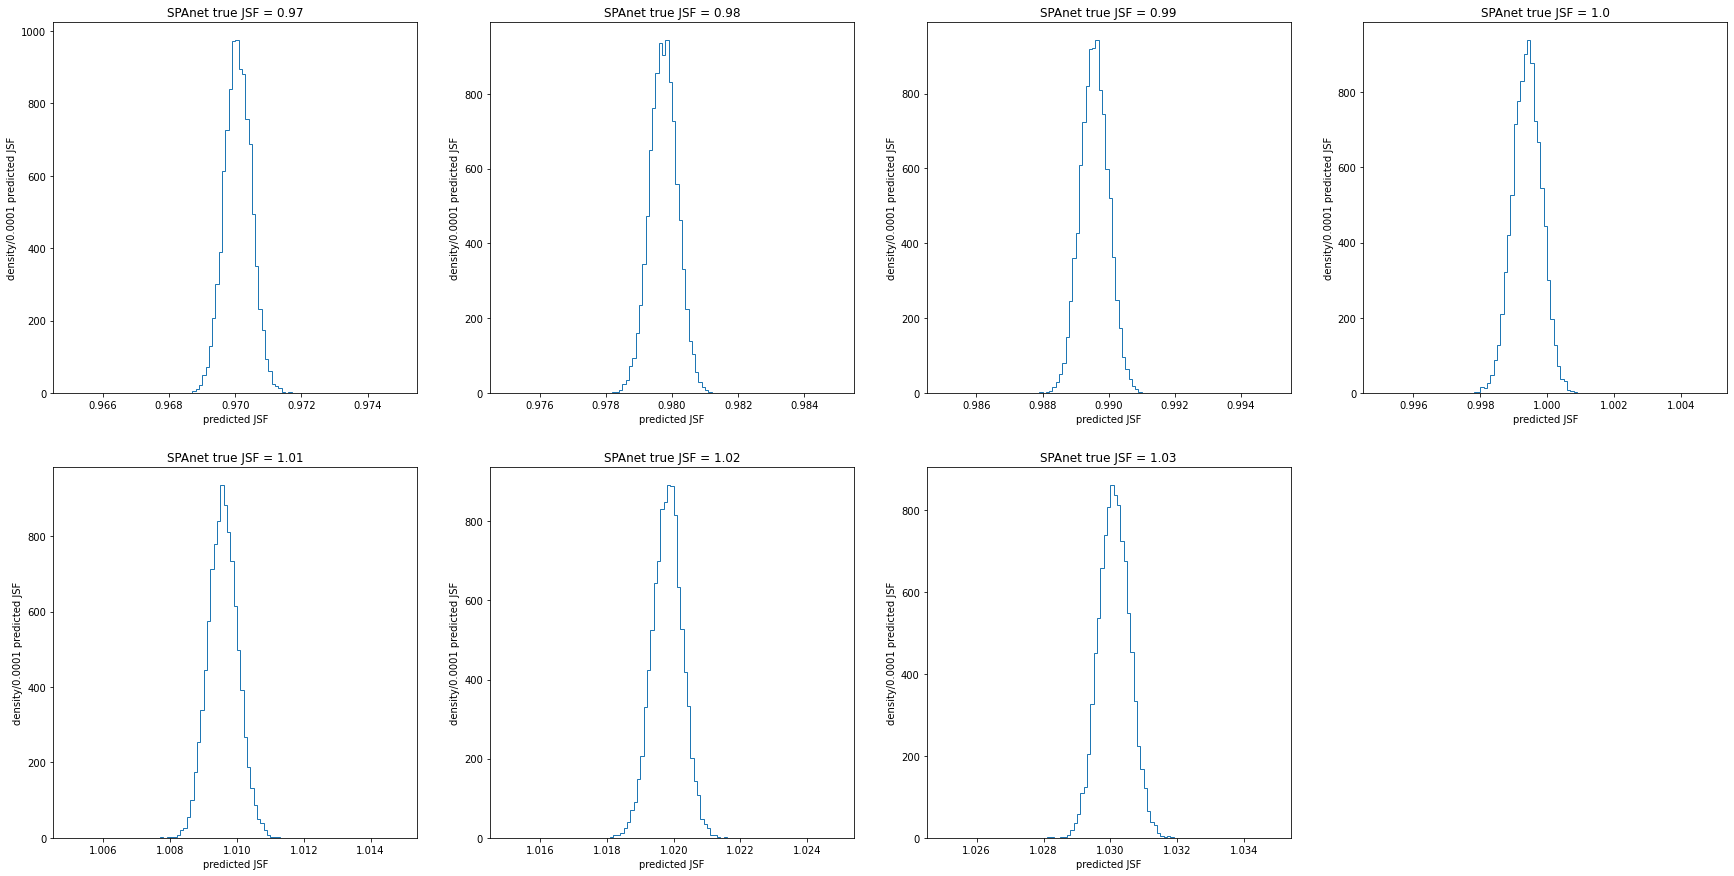

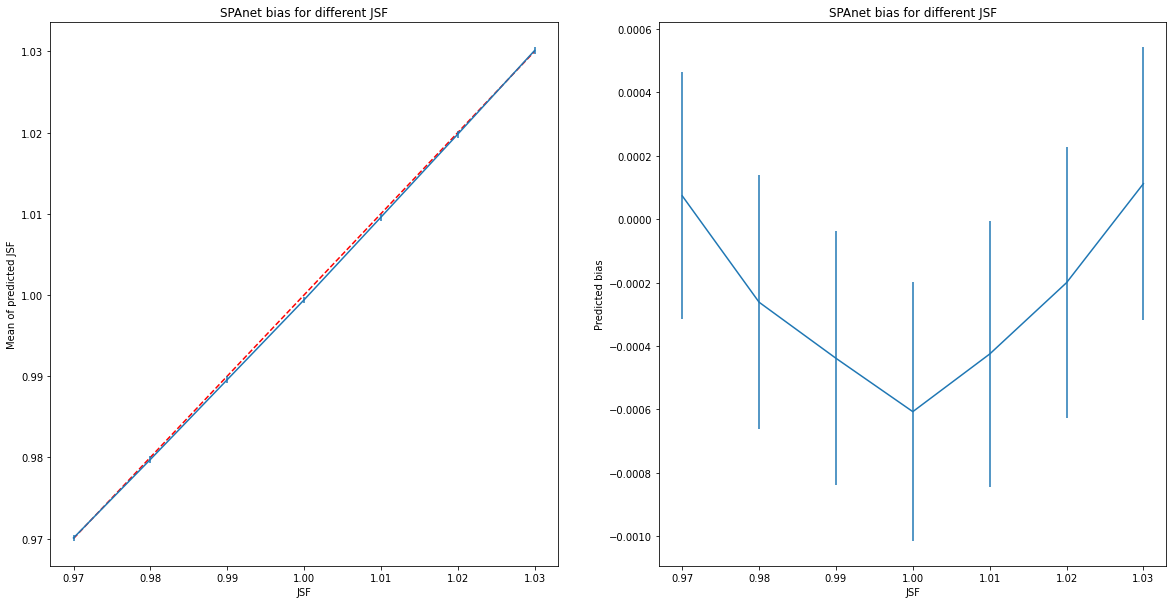

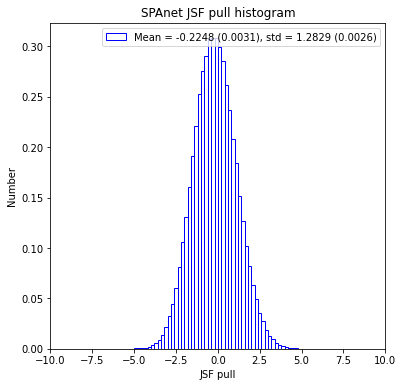

In [57]:
# Plots for SPAnet JSF
m = 173
plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(sudo_spanet_JSF_mean_dic[(m, JSF)], bins=np.arange(JSF-0.005, JSF+0.005, 0.0001), density=True, histtype='step')
    plt.title(f'SPAnet true JSF = {JSF}')
    plt.xlabel('Extracted JSF')
    plt.ylabel('Density/0.0001 extracted JSF')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for SPAnet extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(sudo_spanet_JSF_std_dic[(m, JSF)], bins=np.arange(0.00040, 0.00044, 0.000001), density=True, histtype='step')
    plt.title(f'SPAnet true JSF = {JSF}')
    plt.xlabel('Extracted JSF std')
    plt.ylabel('Density/0.000001 extracted JSF std')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for std of SPAnet extracted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_JSF_popt)) for JSF in JSF_arr], yerr=[np.std(sudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('SPAnet true and prediction comparison for different top mass')
plt.xlabel('JSF')
plt.ylabel('Mean of extracted JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_JSF_popt))-JSF for JSF in JSF_arr], yerr=[np.std(sudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('SPAnet bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Extracted bias')
plt.savefig(f'plots_topmass_JSF/final_plots/SPAnet true and extracted JSF comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(30,15))
for i, JSF in enumerate(JSF_arr):
    plt.subplot(2, 4, i+1)
    plt.hist(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_JSF_popt), bins=np.arange(JSF-0.005, JSF+0.005, 0.0001), density=True, histtype='step')
    plt.title(f'SPAnet true JSF = {JSF}')
    plt.xlabel('predicted JSF')
    plt.ylabel('density/0.0001 predicted JSF')
plt.savefig(f'plots_topmass_JSF/final_plots/Histogram for SPAnet predicted JSF.png', bbox_inches='tight')
plt.show()

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.plot(JSF_arr, JSF_arr, 'r--')
plt.errorbar(JSF_arr, [np.mean(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_JSF_popt)) for JSF in JSF_arr], yerr=[np.std(sudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('SPAnet bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Mean of predicted JSF')
plt.subplot(1, 2, 2)
plt.errorbar(JSF_arr, [np.mean(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_JSF_popt))-JSF for JSF in JSF_arr], yerr=[np.std(sudo_spanet_JSF_mean_dic[(m, JSF)]) for JSF in JSF_arr])
plt.title('SPAnet bias for different JSF')
plt.xlabel('JSF')
plt.ylabel('Predicted bias')
plt.savefig(f'plots_topmass_JSF/final_plots/SPAnet true and predicted JSF comparison.png', bbox_inches='tight')
plt.show()

plt.figure(figsize = (6, 6))
spanet_JSF_pull = [(extract_pred(sudo_spanet_top_mean_dic[(m, JSF)], sudo_spanet_JSF_mean_dic[(m, JSF)], *extract_pred_spanet_JSF_popt)-JSF)/sudo_spanet_JSF_std_dic[(m, JSF)] for m in mass for JSF in JSF_arr]
hist, bin_edges = np.histogram(spanet_JSF_pull, bins=np.arange(-10, 10, 0.2), density=True)
popt, pcov = optimize.curve_fit(gau, bin_edges[:-1]+0.1, hist)
perr = np.sqrt(np.diag(pcov))
plt.bar(bin_edges[:-1]+0.1, hist, edgecolor='b', width=0.2, color='None', label = f'Mean = {popt[0]:.4f} ({perr[0]:.4f}), std = {popt[1]:.4f} ({perr[1]:.4f})')
spanet_JSF_pull_mean, spanet_JSF_pull_mean_std, spanet_JSF_pull_sigma, spanet_JSF_pull_sigma_std = popt[0], perr[0], popt[1], perr[1]
plt.title('SPAnet JSF pull histogram')
plt.xlim(-10, 10)
plt.xlabel('JSF pull')
plt.ylabel('Number')
plt.legend(loc='upper right')
plt.savefig(f'plots_topmass_JSF/final_plots/SPAnet predicted JSF pull histogram.png', bbox_inches='tight')
plt.show()

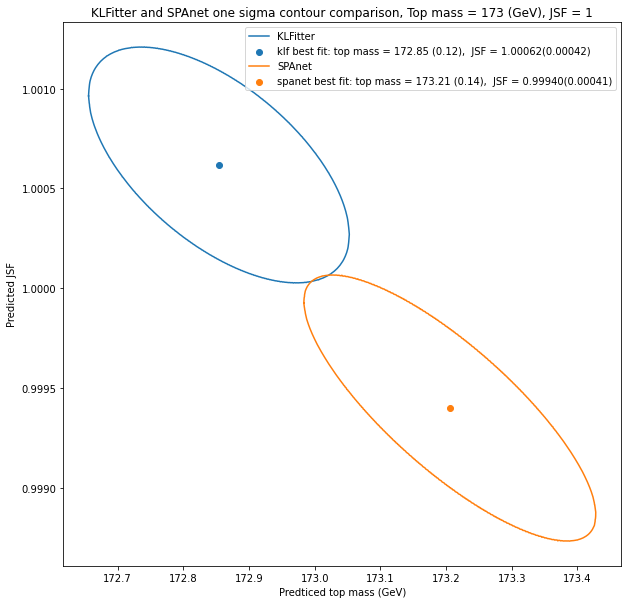

In [56]:
plt.figure(figsize=(10, 10))
m, JSF = 173, 1

reco_klf_top = reco_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
n1 = np.histogram(reco_klf_top, bins=top_bins)[0]
reco_klf_W = W_klf_dic[(m, JSF)][np.logical_and.reduce((cut_klf_dic[(m, JSF)], likeli_klf_dic[(m, JSF)]))]
n2 = np.histogram(reco_klf_W, bins=W_bins)[0]

minuit = Minuit(chi2_klf_arr_func, m=m, JSF=JSF)
minuit.migrad()
minuit.minos()
pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
x, y = np.transpose(pts)
x, y = extract_pred(x, y, *extract_pred_klf_top_popt), extract_pred(x, y, *extract_pred_klf_JSF_popt)
plt.plot(x, y, '-', label='KLFitter')
predicted_klf_top, predicted_klf_JSF = extract_pred(minuit.values['m'], minuit.values['JSF'], *extract_pred_klf_top_popt), extract_pred(minuit.values['m'], minuit.values['JSF'], *extract_pred_klf_JSF_popt)
plt.scatter(predicted_klf_top, predicted_klf_JSF, label=f'klf best fit: top mass = {predicted_klf_top:.2f} ({minuit.errors[0]:.2f}),  JSF = {predicted_klf_JSF:.5f}({ minuit.errors[1]:.5f})')

reco_spanet_top = reco_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
n1 = np.histogram(reco_spanet_top, bins=top_bins)[0]
reco_spanet_W = W_spanet_dic[(m, JSF)][np.logical_and.reduce((cut_spanet_dic[(m, JSF)], likeli_spanet_dic[(m, JSF)]))]
n2 = np.histogram(reco_spanet_W, bins=W_bins)[0]

minuit = Minuit(chi2_spanet_arr_func, m=m, JSF=JSF)
minuit.migrad()
minuit.minos()
pts = minuit.mncontour("m", "JSF", cl=1, size = 1000)
x, y = np.transpose(pts)
x, y = extract_pred(x, y, *extract_pred_spanet_top_popt), extract_pred(x, y, *extract_pred_spanet_JSF_popt)
plt.plot(x, y, '-', label='SPAnet')
predicted_spanet_top, predicted_spanet_JSF = extract_pred(minuit.values['m'], minuit.values['JSF'], *extract_pred_spanet_top_popt), extract_pred(minuit.values['m'], minuit.values['JSF'], *extract_pred_spanet_JSF_popt)
plt.scatter(predicted_spanet_top, predicted_spanet_JSF, label=f'spanet best fit: top mass = {predicted_spanet_top:.2f} ({minuit.errors[0]:.2f}),  JSF = {predicted_spanet_JSF:.5f}({minuit.errors[1]:.5f})')

plt.title(f'KLFitter and SPAnet one sigma contour comparison, Top mass = {m} (GeV), JSF = {JSF}')
plt.xlabel('Predticed top mass (GeV)')
plt.ylabel('Predicted JSF')
plt.legend(loc = 'upper right')
plt.savefig(f'plots_topmass_JSF/final_plots/Predicted contour compare.png', bbox_inches='tight')
plt.show()